参考: 

https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification

https://www.kaggle.com/code/werus23/g2net-pytorch-with-generated-data

In [1]:
# たまにgpu取れないときあるので取れないときは終わらせる
import torch
if torch.cuda.is_available() == False:
    raise Exception

In [2]:
!nvidia-smi

Sat Dec 31 15:00:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:0E:00.0 Off |                    0 |
| N/A   56C    P0    41W / 300W |      9MiB / 32508MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   

In [3]:
# papermill parameters
cfg_optimizer = "adamw" # "sam"
device_ids = [0]
epochs = 15
gradient_accumulation_steps = 1
is_syncBN = False

#lr = 5e-3  # 高すぎるみたい
lr = 4e-4

warmup_t = 3
#warmup_t = 1

min_lr_ratio = 1e-2

weight_decay = 1e-5  # 1e-6にしてもほぼ変わらない
#weight_decay = 1e-6

is_wandb = True
is_wandb = False
n_seeds = 1
cfg_seeds = [0]

cfg_apex = True
#cfg_apex = False  # ampなしにしても変わらず

#BATCH_SIZE = 2
#BATCH_SIZE = 8  # 8にしても16と変わらず学習遅くなるだけ
BATCH_SIZE = 16
#BATCH_SIZE = 32  # 32以降ぐらいからbatch上げるとepochごとのスコア安定しない
#BATCH_SIZE = 64
#BATCH_SIZE = 128
#BATCH_SIZE = 384

load_model_path = "none"
#load_model_path = "/volume/kaggle/g2net2/output/tmp/tmp_fold0_seed0_best_score.pth"
#model_cls = "CustomModel"
#model_cls = "CustomModelDrop"
model_cls = "CustomModelMultiOutput"
#model_cls = "CustomModelMultiInput"
#model_cls = "CustomModelLargeKernel"

# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook
cfg_drop_rate = 0.4
cfg_drop_path_rate = 0.2

#MODEL_NAME = ""
MODEL_NAME = "mobilenetv3_small_050"
#MODEL_NAME = "tf_efficientnetv2_b1"
#MODEL_NAME = "tf_efficientnet_b4_ap"
#MODEL_NAME = "tf_efficientnet_b5_ns"
#MODEL_NAME = "tf_efficientnet_b7_ns"
#MODEL_NAME = "seresnext101d_32x8d"
cfg_pretrained = True

n_fold = 5
#trn_fold = [0,1,2,3,4]
#is_trn_allfold = True
trn_fold = [0]
#trn_fold = "[3]"
is_trn_allfold = False

cfg_scheduler = 'CosineLRScheduler'  # warmup
#cfg_scheduler = 'CosineLRScheduler_cycle_limit3'  # warmup

# data params
cfg_ch = 2
#cfg_step = 64
cfg_step = 128
#cfg_step = 256
#cfg_step = 340
#cfg_step = 512
#cfg_step = 5760
cfg_spec_max = 4096
#cfg_spec_max = 4224  # 33 * 128
#cfg_spec_max = 5760

size_h, size_w = 360, cfg_step
#size_h, size_w = 360, 128
#size_h, size_w = 360, 256

# train+test set stat img  https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-img4096
# np.mean(p.reshape(freq, step, spec_max//step), axis=2)直後の統計値
cfg_p_mean = [2.4080, 2.3525]  # [H1, L1]
cfg_p_std = [0.6578, 0.8358]  # [H1, L1]

#normalize_type = "default-norm|ts-ma"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-max"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|ts-ma|p-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel|p-stand|ts-ma"
#normalize_type = "largekernel"

cfg_is_add_ch = False
cfg_is_train_zip_dataset = False
cfg_prob_mixup = 0.0

#cfg_prob_sample_mixup = 0.0
#cfg_prob_sample_mixup = 0.5
cfg_prob_sample_mixup = 0.8

cfg_is_sample_mixup_use_pseudo = True
#cfg_is_sample_mixup_use_pseudo = False

cfg_prob_add_sample_nega_mixup = 0.0
#cfg_prob_add_sample_nega_mixup = 0.5

#cfg_prob_mean_mixup = 0.0
cfg_prob_mean_mixup = 0.3

#cfg_prob_noise_band = 0.0
cfg_prob_noise_band = 0.3

#cfg_prob_noise_spot = 0.0
cfg_prob_noise_spot = 0.05

#cfg_prob_noise_vline = 0.0
cfg_prob_noise_vline = 0.2

#cfg_prob_noise_hband = 0.0
cfg_prob_noise_hband = 0.2
cfg_prob_noise_hband = 0.5

cfg_prob_spec_start_random = 0.0
#cfg_prob_spec_start_random = 0.5

#cfg_prob_swap_ch_nega = 0.0
cfg_prob_swap_ch_nega = 0.5

#cfg_prob_flip_nega = 0.0
cfg_prob_flip_nega = 0.5

#cfg_prob_swap_nega = 0.0
cfg_prob_swap_nega = 0.5

cfg_prob_vshift_nega = 0.0
#cfg_prob_vshift_nega = 0.5

#cfg_prob_vshift = 0.0
cfg_prob_vshift = 1.0

#cfg_freq_mask_num = 0  # マスクする横線
#cfg_time_mask_num = 0  # マスクする縦線
cfg_freq_mask_num = 2
cfg_time_mask_num = 1
cfg_freq_mask_param = 10
cfg_time_mask_param = 10
#cfg_freq_mask_param = 30
#cfg_time_mask_param = 50

cfg_cv_col = "target"
#cfg_cv_col = "freq_min//10"
#cfg_cv_col = "freq_min//10_target"

cfg_add_split_str = ""
#cfg_add_split_str = "KFold"
#cfg_add_split_str = "StratifiedKFold"

cfg_is_npy = True
#cfg_is_npy = False

FCOFF = 1e22
#FCOFF = 5e22

ADD_DIRS_STR = ""
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL, EX004_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL1, EX005_SIGNAL_ISO1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX003_NOISE2, EX004_SIGNAL, EX004_SIGNAL_ISO, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX006_SIGNAL800]"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

IS_ADD_ALL_TRAIN1 = False
#IS_ADD_ALL_TRAIN1 = True


PSEUDO_CSV = ""
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
#cfg_pseudo_max = 0.0  # pseudoの閾値なし
#cfg_pseudo_min = 0.0  # pseudoの閾値なし
#cfg_is_pseudo_hard = True
cfg_is_pseudo_hard = False

cfg_pseudo_type = ""
#cfg_pseudo_type = "real"
#cfg_pseudo_type = "sim"


ADD_PSEUDO_DIRS = ""
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"


cfg_freq_div_n = 10
#cfg_freq_div_n = 50
#cfg_freq_div_n = 100

cfg_pseudo_sim_max = cfg_pseudo_max
cfg_pseudo_sim_min = cfg_pseudo_min
#cfg_pseudo_sim_max = 0.8
#cfg_pseudo_sim_min = 0.4
#cfg_pseudo_sim_max = 0.0
#cfg_pseudo_sim_min = 0.0

cfg_pseudo_real_max = cfg_pseudo_max
cfg_pseudo_real_min = cfg_pseudo_min

is_matplotlib_agg = False
#is_matplotlib_agg = True  # 可視化なしにする

IS_MAKE_SUB = False
#IS_MAKE_SUB = True

#DEBUG = False
DEBUG = True

# ==============================================================
# kqi_3090_ex075_v2 base Parameters
# ==============================================================
add_name = "_pseudo_multioutput_freq_b5_ap_freq_div_n50"
BATCH_SIZE = 64
MODEL_NAME = "tf_efficientnet_b5_ap"
model_cls = "CustomModelMultiOutput"
epochs = 50
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
cfg_apex = True
cfg_step = 128
size_w = 128
cfg_is_sample_mixup_use_pseudo = True
cfg_add_split_str = "StratifiedKFold"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1

cfg_is_pseudo_hard = False
cfg_freq_div_n = 50
IS_ADD_ALL_TRAIN1 = False
IS_MAKE_SUB = True
n_fold = 5
#is_trn_allfold = True
#DEBUG = False
# ==============================================================

# ==============================================================
# kqi_3090_ex075_v2_tta_v3_miximp_hvflip_pseudo_lb0771_1000_simall_100ep Parameters
# ==============================================================
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 1.0 
cfg_pseudo_min = 0.0
cfg_pseudo_sim_max = 0.0
cfg_pseudo_real_max = -1
epochs = 100
# ==============================================================

#PSEUDO_CSV = "./kqi_dl/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_submission.csv"
#PSEUDO_CSV = "./kqi_dl/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep_submission_tta012.csv"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_ver25_lb0777.csv"

DEL_Outlier_Pseudo_MEAN_TH = 0
#DEL_Outlier_Pseudo_MEAN_TH = 5

DEL_Outlier_Pseudo_STD_TH = 0
#DEL_Outlier_Pseudo_STD_TH = 10

## pseudo全部入れる
#cfg_pseudo_max = 0.0
#cfg_pseudo_min = 1.0
#cfg_pseudo_sim_max = -1
#cfg_pseudo_real_max = -1

## pseudo sim全部入れる+real[<0.1,>0.9]だけ入れる
#cfg_pseudo_max = 0.9
#cfg_pseudo_min = 0.1
#cfg_pseudo_sim_max = 0
#cfg_pseudo_real_max = 0.9
#cfg_pseudo_real_min = 0.1

cfg_alb_norm_mean_th = 0  # albで画像正規化しない
#cfg_alb_norm_mean_th = DEL_Outlier_Pseudo_MEAN_TH  # これ以上の h1_mean+l1_mean を取る画像は除いて統計値出してalbで正規化する。
#cfg_alb_norm_mean_th = 1000000  # 全データで正規化

cfg_alb_norm_std_th = 0  # albで画像正規化しない
#cfg_alb_norm_std_th = DEL_Outlier_Pseudo_STD_TH  # これ以上の h1_std+l1_std を取る画像は除いて統計値出してalbで正規化する。trainの h1_std,l1_std は 0.42 ぐらいがmax値
#cfg_alb_norm_std_th = 1000000  # 全データで正規化

ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800, EX007_NONSTAT_NOISE800, EX009_NOISE_ART]"
ADD_PSEUDO_DIRS = ""

#model_cls = "CustomModelMultiOutputStride12"

cfg_prob_gauss_noise = 0.0
cfg_prob_gauss_noise = 0.5
cfg_min_snr = 5
cfg_max_snr = 20
#cfg_min_snr = 15  # https://github.com/analokmaus/kaggle-g2net-public/blob/main/configs.py
#cfg_max_snr = 30

num_workers = 8

add_name = ""

In [4]:
# Parameters
add_name = "_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 0.0
cfg_pseudo_min = 0.0
cfg_pseudo_sim_max = -1
cfg_pseudo_real_max = -1
epochs = 100
cfg_alb_norm_mean_th = 5
cfg_alb_norm_std_th = 10
DEL_Outlier_Pseudo_MEAN_TH = 5
DEL_Outlier_Pseudo_STD_TH = 10
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800, EX007_NONSTAT_NOISE800, EX007_NONSTAT_NOISE1000, EX007_NONSTAT_NOISE1200]"
ADD_PSEUDO_DIRS = ""
model_cls = "CustomModelMultiOutputStride12"
BATCH_SIZE = 64
cfg_prob_gauss_noise = 0.5
cfg_min_snr = 5
cfg_max_snr = 20
is_trn_allfold = True
is_wandb = True
DEBUG = False


In [5]:
# papermillで引数をlistで渡さなかった場合の対策
if isinstance(device_ids, int):
    device_ids = [0]
    
# trn_foldをpapermillで渡したときの対策
if type(trn_fold) is str:
    trn_fold = eval(trn_fold)
    
# 全fold学習
if is_trn_allfold:
    trn_fold = list(range(n_fold))
    
# 複数seedで学習
if n_seeds > 1:
    cfg_seeds = list(range(n_seeds))
    
# ダウンロードしたデータで事前学習する場合はfold=0のみ
if cfg_is_train_zip_dataset:
    trn_fold = [0]
    
# フラグあればch増やす
if cfg_is_add_ch:
    cfg_ch = 2 + 2 
    
# 移動平均の場合は画像の横幅-1する
if "ts-ma" in normalize_type:
    size_w -= 1
    
# フーリエ係数変える場合
if FCOFF != 1e22:
    normalize_type += f"_{str(FCOFF)}"
    
## largekernelを使う場合
#if "largekernel" in normalize_type:
#    cfg_spec_max = 5760
    
# LargeKernelモデルを使う場合
if model_cls == "CustomModelLargeKernel":
    MODEL_NAME = ""
    cfg_step = 5760
    cfg_spec_max = 5760
    size_h, size_w = 360, cfg_step
    normalize_type = "largekernel"
    cfg_prob_mean_mixup = 0.0
    cfg_prob_spec_start_random = 0.0
    cfg_time_mask_param = int( 10 * (cfg_spec_max / 128) )

In [6]:
import os
#import ipynbname
#NAME = ipynbname.name()
if DEBUG:
    NAME = f"tmp"
    #NAME = f"tmp_real"
    #NAME = f"tmp_no-alb"
    #NAME = f"tmp_VerticalFlip"
    #NAME = f"tmp_HorizontalFlip"
    #NAME = f"tmp_no-alb_EX003_NOISE01"
else:
    if "/kqi/output" in os.getcwd():
        NAME = f"kqi_3090_ex075_v2{add_name}"
    else:
        NAME = f"3090_kqi_ex075_v2{add_name}"
print(NAME)

kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN


# Directory

In [7]:
import os, sys

if "kaggle_web_client" in sys.modules:
    INPUT_DIR_TRAIN = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    INPUT_DIR_TEST = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"

elif "/work" in os.getcwd():
    INPUT_DIR_TRAIN = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    INPUT_DIR_TEST = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    OUTPUT_DIR = f"/volume/kaggle/g2net2/output/{NAME}"  # HDD
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise_gap5000"  # HDD 5000件
    EX004_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_1"  # HDD 800件
    EX005_SIGNAL_ISO1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_iso_1"  # HDD 800件
    EX006_NOISE1400 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap1400"  # HDD 1400件
    EX006_SIGNAL800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap800"  # HDD 800件
    EX006_SIGNAL_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso800"  # HDD 800件
    EX006_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap5000"  # HDD 5000件
    EX006_SIGNAL2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap2000"  # HDD 2000件
    EX006_SIGNAL_ISO2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso2000"  # HDD 2000件
    EX007_NONSTAT_NOISE800 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary800"  # HDD 800件
    EX007_NONSTAT_NOISE1000 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary1000"  # HDD 1000件
    EX007_NONSTAT_NOISE1200 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary1200"  # HDD 1200件
    
    EX008_SIGNAL_D3550_400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d3550_400"  # HDD 400件
    EX008_SIGNAL_D3550_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d3550_iso400"  # HDD 400件
    EX008_SIGNAL_D3550_800 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d3550_800"  # HDD 800件
    EX008_SIGNAL_D3550_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d3550_iso800"  # HDD 800件
    
    EX008_SIGNAL_D5075_400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso400"  # HDD 400件
    EX008_SIGNAL_D5075_800 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_800"  # HDD 800件
    EX008_SIGNAL_D5075_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso800"  # HDD 800件
    
    EX008_SIGNAL_D75100_400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d75100_400"  # HDD 400件
    EX008_SIGNAL_D75100_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d75100_iso400"  # HDD 400件
    EX008_SIGNAL_D75100_800 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d75100_800"  # HDD 800件
    EX008_SIGNAL_D75100_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d75100_iso800"  # HDD 800件
    
    EX009_NOISE_ART = f"/volume/kaggle/g2net2/pyfstat_output/ex009_generating_noise_artifacts_n_len3"  # HDD 150件ぐらい
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/volume-ssd/kaggle_g2net2/npys"  # SSD
    

elif "/kqi/output" in os.getcwd():
    INPUT_DIR_TRAIN = f"/workspace/g2net2/input"  # cp_SSD
    INPUT_DIR_TEST = f"/kqi/output/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"
    
    # ============================================
    # 生成データのパス
    # ============================================
    _dir = f"/workspace/g2net2/pyfstat_output/{normalize_type}"
    EX003_NOISE = f"{_dir}/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"{_dir}/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"{_dir}/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"{_dir}/ex003_generating_noise_gap5000"  # SSD 5000件
    EX004_SIGNAL = f"{_dir}/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"{_dir}/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"{_dir}/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"{_dir}/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"{_dir}/ex005_generating_signal_gap_1"  # SSD 800件
    EX005_SIGNAL_ISO1 = f"{_dir}/ex005_generating_signal_gap_iso_1"  # SSD 800件
    EX006_NOISE1400 = f"{_dir}/ex006_generating_noise_gap1400"  # SSD 1400件
    EX006_SIGNAL800 = f"{_dir}/ex006_generating_signal_gap800"  # SSD 800件
    EX006_SIGNAL_ISO800 = f"{_dir}/ex006_generating_signal_gap_iso800"  # SSD 800件
    EX006_NOISE5000 = f"{_dir}/ex006_generating_noise_gap5000"  # SSD 5000件
    EX006_SIGNAL2000 = f"{_dir}/ex006_generating_signal_gap2000"  # SSD 2000件
    EX006_SIGNAL_ISO2000 = f"{_dir}/ex006_generating_signal_gap_iso2000"  # SSD 2000件
    EX007_NONSTAT_NOISE800 = f"{_dir}/ex007_generating_noise_nonstationary800"  # SSD 800件
    EX007_NONSTAT_NOISE1000 = f"{_dir}/ex007_generating_noise_nonstationary1000"  # SSD 1000件
    EX007_NONSTAT_NOISE1200 = f"{_dir}/ex007_generating_noise_nonstationary1200"  # HDD 1200件

    EX008_SIGNAL_D3550_400 = f"{_dir}/ex008_generating_signal_d3550_400"  # HDD 400件
    EX008_SIGNAL_D3550_ISO400 = f"{_dir}/ex008_generating_signal_d3550_iso400"  # HDD 400件
    EX008_SIGNAL_D3550_800 = f"{_dir}/ex008_generating_signal_d3550_800"  # HDD 800件
    EX008_SIGNAL_D3550_ISO800 = f"{_dir}/ex008_generating_signal_d3550_iso800"  # HDD 800件
    
    EX008_SIGNAL_D5075_400 = f"{_dir}/ex008_generating_signal_d5075_400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"{_dir}/ex008_generating_signal_d5075_iso400"  # HDD 400件
    EX008_SIGNAL_D5075_800 = f"{_dir}/ex008_generating_signal_d5075_800"  # HDD 800件
    EX008_SIGNAL_D5075_ISO800 = f"{_dir}/ex008_generating_signal_d5075_iso800"  # HDD 800件
    
    EX008_SIGNAL_D75100_400 = f"{_dir}/ex008_generating_signal_d75100_400"  # HDD 400件
    EX008_SIGNAL_D75100_ISO400 = f"{_dir}/ex008_generating_signal_d75100_iso400"  # HDD 400件
    EX008_SIGNAL_D75100_800 = f"{_dir}/ex008_generating_signal_d75100_800"  # HDD 800件
    EX008_SIGNAL_D75100_ISO800 = f"{_dir}/ex008_generating_signal_d75100_iso800"  # HDD 800件
    
    EX009_NOISE_ART = f"{_dir}/ex009_generating_noise_artifacts_n_len3"  # SSD 150件ぐらい
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/workspace/g2net2/pyfstat_output"  # SSD
    
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN


# Data

In [8]:
import os, sys
import shutil
import cv2
import glob
import random
import h5py
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

if is_matplotlib_agg:
    import matplotlib
    matplotlib.use('Agg')
    from matplotlib import pyplot as plt
else:
    from matplotlib import pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2
from src.zip_dataset import ZipDataset
from src import largekernel

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
if cfg_is_train_zip_dataset:
    
    zip_path = f'{INPUT_DIR_TRAIN}/../g2net-generated-signals'
    zip_mod = 100
    zip_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod)
    
    # ZipDatasetのラベルをcsvにしておく
    if os.path.exists(f'{zip_path}/zip_df.csv') == False:
        zip_labels = []
        zip_paths = []
        for i, (img, y) in tqdm(enumerate(zip_dataset), total=len(zip_dataset)):
            y = int(y)
            zip_labels.append(y)
            zip_paths.append(f'{zip_path}/archive/{y}_data_{zip_mod*(1+(i)//zip_mod)}/signals_{i%zip_mod}.npy')
            if i == 14900-1:
                break
        zip_df = pd.DataFrame({"id": range(len(zip_labels)), 
                               "target": zip_labels,
                               "path": zip_paths,
                               "fold": -1,
                              })
        zip_df.to_csv(f'{zip_path}/zip_df.csv', index=False)
        

#train_df = pd.read_csv(INPUT_DIR_TRAIN + '/train_labels.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
train_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/train_summary.csv").rename(columns={"Unnamed: 0":'id'})
train_df["path"] = INPUT_DIR_TRAIN + "/train/" + train_df["id"] + ".hdf5"
train_df = train_df[train_df.target >= 0]  # Remove 3 unknowns (target = -1)
train_df["orig"] = 1  # オリジナルデータのフラグ
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
train_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/train_mean_std.csv").drop(['target'], axis=1)
train_df = pd.merge(train_df, train_ma_img_mean_std, on="id")
print("train_df.shape:", train_df.shape)
#display(train_df)
#print(train_df["freq_min//10"].max(), train_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
train_df["freq_min//N"] = train_df["freq min"] // cfg_freq_div_n
print(train_df["freq_min//N"].max(), train_df["freq_min//N"].min())

# h1_mean+l1_mean, h1_std+l1_std 列追加
train_df["h1_l1_mean"] = train_df["h1_mean"] + train_df["l1_mean"]
train_df["h1_l1_std"] = train_df["h1_std"] + train_df["l1_std"]

#test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
test_df["target"] = 0.5
test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
test_df["orig"] = 1  # オリジナルデータのフラグ
test_df["freq_min//10"] = test_df["freq min"]//10
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
test_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/test_mean_std.csv").drop(['target'], axis=1)
test_df = pd.merge(test_df, test_ma_img_mean_std, on="id")

# リアルデータ/シュミレーションデータを区別するためのタイムスタンプのブロックごとでの標準偏差の差の列を追加
# stddiff == 0 はタイムスタンプのブロックごとでの差がない（=ガウスノイズ）なのでシュミレーションデータ
# https://www.kaggle.com/code/anonamename/g2net2-winning-strategy-with-external-data?scriptVersionId=112011488
df_stat_test = pd.read_csv(f"./kaggle_dl/g2net2-winning-strategy-with-external-data_v1/df_stat_test.csv").drop(['fname'], axis=1)
test_df = pd.merge(test_df, df_stat_test, on="id")

# リアルデータとシュミレーションデータのフラグ
_real_sim_flags = test_df["h1_stddiff"] + test_df["l1_stddiff"]
_real_sim_flags = _real_sim_flags.to_numpy()
test_df["real_sim"] = np.array([1 if _f > 0 else 0 for _f in _real_sim_flags])  # リアルデータ=1,シュミレーションデータ=0
print("test real_sim_flags:")
print(test_df["real_sim"].value_counts())

print("test_df.shape:", test_df.shape)
#display(test_df)
#print(test_df["freq_min//10"].max(), test_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
test_df["freq_min//N"] = test_df["freq min"] // cfg_freq_div_n
print(test_df["freq_min//N"].max(), test_df["freq_min//N"].min())

# h1_mean+l1_mean, h1_std+l1_std 列追加
test_df["h1_l1_mean"] = test_df["h1_mean"] + test_df["l1_mean"]
test_df["h1_l1_std"] = test_df["h1_std"] + test_df["l1_std"]


train_df.shape: (600, 26)
9.0 1.0
test real_sim_flags:
0    6478
1    1497
Name: real_sim, dtype: int64
test_df.shape: (7975, 33)
10.0 0.0


In [11]:
# ==================================================
# test_dfをリアルデータ/シュミレーションデータだけにする
# ==================================================
if cfg_pseudo_type == "real":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] > 0)].reset_index(drop=True)  #  shape: (1497, xxx)
elif cfg_pseudo_type == "sim":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] == 0)].reset_index(drop=True)  #  shape: (6478, xxx)
print("test_df.shape:", test_df.shape)

test_df.shape: (7975, 36)


In [12]:
# ==================================================
# 学習に使う生成データのパスやラベルをcsvにする
# ==================================================
if ADD_DIRS_STR != "":
    add_df_all = None
    for _add_dir in eval(ADD_DIRS_STR):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
        if "generating_noise" in _add_dir:
            _target = 0
        else:
            _target = 1
        add_df = pd.DataFrame({"path": sorted(glob.glob(f"{_add_dir}/*{_suff}")), 
                               "target": _target})
        add_df["id"] = [Path(p).stem for p in add_df["path"]]
        add_df["sqrtSX"] = add_df["id"].apply(lambda x: x.split("_")[1].split("sqrtSX")[1])
        add_df["F0"] = add_df["id"].apply(lambda x: x.split("_")[2].split("F0")[1])

        if "_signal" in _add_dir:
            add_df["F1"] = add_df["id"].apply(lambda x: x.split("_")[3].split("F1")[1])
            add_df["h0deg"] = add_df["id"].apply(lambda x: x.split("_")[4].split("h0deg")[1])

        add_df["type"] = add_df["id"].apply(lambda x: x.split("_")[-1])

        # どのデータかわかるようにディレクトリの名前残しとく
        add_df["dir_name"] = Path(_add_dir).name

        if "ex003_generating_noise" in _add_dir: 
            # gapデータだけにする
            add_df = add_df[add_df["type"] == "gap"]

            ## segmentデータだけにする
            #add_df = add_df[add_df["type"] != "gap"]
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_df = pd.merge(add_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_df["freq_min//N"] = add_df["freq min"] // cfg_freq_div_n
        print(add_df["freq_min//N"].max(), add_df["freq_min//N"].min())
        
        if add_df is None:
            add_df_all = add_df
        else:
            add_df_all = pd.concat([add_df_all, add_df]).reset_index(drop=True)

    add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_df_all.shape:", add_df_all.shape)
    #display(add_df_all)
    #print(add_df_all["freq_min//10"].value_counts())
    #print(add_df_all["freq_min//10"].max(), add_df_all["freq_min//10"].min())

9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
add_df_all.shape: (11383, 24)


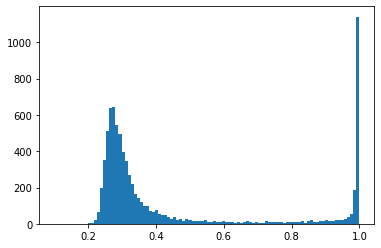

In [13]:
pseudo_df = pd.read_csv(PSEUDO_CSV)
plt.hist(pseudo_df["target"], bins=100, label="use target_real")
plt.show()

np.clip(pseudo_df['target'], 0.2, None)
10.0 0.0
(7975, 36)
(7327, 36)


0    6478
1     849
Name: real_sim, dtype: int64


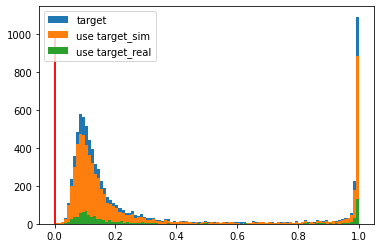

pseudo_df.shape: (7327, 36)


In [14]:
# ==================================================
# for Pseudo
# ==================================================
from sklearn.preprocessing import MinMaxScaler

if PSEUDO_CSV != "":
    pseudo_df = pd.read_csv(PSEUDO_CSV)
    pseudo_df["path"] = INPUT_DIR_TEST + "/test/" + pseudo_df["id"] + ".hdf5"
    #display(pseudo_df)
    
    if PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv":
        print("np.clip(pseudo_df['target'], 0.2, None)")
        # lb0.771のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
        
    elif PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_ver18_lb0772.csv":
        print("np.clip(pseudo_df['target'], 0.2, None)")
        # lb0.772のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
        
    elif PSEUDO_CSV == "./kqi_dl/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_submission.csv":
        print("np.clip(pseudo_df['target'], 0.21, None)")
        # lb0.774のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.21, None)
        
    elif PSEUDO_CSV == "./kqi_dl/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep_submission_tta012.csv":
        print("np.clip(pseudo_df['target'], 0.22, None)")
        # lb0.775のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.22, None)
        
    elif PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_ver25_lb0777.csv":
        print("np.clip(pseudo_df['target'], 0.22, None)")
        # lb0.775のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.22, None)
    
    pseudo_df = pd.merge(pseudo_df, test_df[["id", "real_sim"]], on="id")
    
    # 確信度0-1に正規化
    pseudo_df["target"] = MinMaxScaler().fit_transform(pseudo_df["target"].values.reshape(-1, 1))
    #display(pseudo_df)
    
    # 分布可視化
    plt.hist(pseudo_df["target"], bins=100, label="target")
    
    p_sim_df = pseudo_df[pseudo_df["real_sim"] == 0].copy()
    p_real_df = pseudo_df[pseudo_df["real_sim"] == 1].copy()
    
    # 確信度が高い低いものだけ採用。0なら全部入れる
    if cfg_pseudo_max > 0:
        pseudo_df = pseudo_df[ (pseudo_df["target"] > cfg_pseudo_max) | (pseudo_df["target"] < cfg_pseudo_min) ].reset_index(drop=True)
        #display(pseudo_df)
        
    # simデータが高い低いものだけ採用
    if cfg_pseudo_sim_max > 0:
        p_sim_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_sim_max) | (p_sim_df["target"] < cfg_pseudo_sim_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == -1:
        # -1なら追加なし
        pass
        
    # realデータが高い低いものだけ採用
    if cfg_pseudo_real_max > 0:
        p_real_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_real_max) | (p_sim_df["target"] < cfg_pseudo_real_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == -1:
        # -1なら追加なし
        pass
        
    # ハードラベルにする
    if cfg_is_pseudo_hard:
        pseudo_df.loc[pseudo_df["target"] >= 0.5, "target"] = 1
        pseudo_df.loc[pseudo_df["target"] < 0.5, "target"] = 0
        pseudo_df["target"] = pseudo_df["target"].astype(int)
        #display(pseudo_df)
        print("pseudo_df['target'].value_counts():")
        print(pseudo_df["target"].value_counts())
        pseudo_df.target.plot.hist()
        plt.show()
        
    # test setと同じサイズに変更
    pseudo_df = pd.merge(pseudo_df[["id", "target"]], test_df.drop("target", axis=1), on="id").reset_index(drop=True)
    
    # MultiOutputに使う freq_min//N 列をつくる
    pseudo_df["freq_min//N"] = pseudo_df["freq min"] // cfg_freq_div_n
    print(pseudo_df["freq_min//N"].max(), pseudo_df["freq_min//N"].min())

    # 振幅が外れ値のpseudo_label除く
    if (DEL_Outlier_Pseudo_MEAN_TH > 0) or (DEL_Outlier_Pseudo_STD_TH > 0):
        print(pseudo_df.shape)
        pseudo_df = pseudo_df[
            (pseudo_df["h1_l1_mean"] <= DEL_Outlier_Pseudo_MEAN_TH)
            & (pseudo_df["h1_l1_std"] <= DEL_Outlier_Pseudo_STD_TH)
        ].reset_index(drop=True)
        print(pseudo_df.shape)
        display(
            pseudo_df[["h1_mean", "l1_mean", "h1_std", "l1_std", "h1_l1_mean", "h1_l1_std"]]
            .describe()
            .style.background_gradient(cmap="Blues")
        )
        print(pseudo_df["real_sim"].value_counts())
        
    # 分布可視化
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==0, "target"], bins=100, label="use target_sim")
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==1, "target"], bins=100, label="use target_real")
    plt.vlines(cfg_pseudo_max, 0, 1000, colors="red")
    plt.vlines(cfg_pseudo_min, 0, 1000, colors="red")
    plt.legend()
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()
    
    pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("pseudo_df.shape:", pseudo_df.shape)
    #display(pseudo_df)
    #print(pseudo_df["freq_min//10"].value_counts())
    #print(pseudo_df["freq_min//10"].max(), pseudo_df["freq_min//10"].min())

In [15]:
# ==================================================
# for Pseudo 追加
# ==================================================
if ADD_PSEUDO_DIRS != "":
    
    add_pseudo_df = None
    for _add_dir in eval(ADD_PSEUDO_DIRS):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
    
        _add_df = pd.read_csv(_add_dir + "/df.csv")
        _add_df["path"] = _add_dir + "/" + _add_df["id"] + _suff
        
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        _add_df = pd.merge(_add_df, _sum_df, on="id")
        
        if add_pseudo_df is None:
            add_pseudo_df = _add_df
        else:
            add_pseudo_df = pd.concat([add_pseudo_df, _add_df]).reset_index(drop=True)
            
        # MultiOutputに使う freq_min//N 列をつくる
        add_pseudo_df["freq_min//N"] = add_pseudo_df["freq min"] // cfg_freq_div_n
        print(add_pseudo_df["freq_min//N"].max(), add_pseudo_df["freq_min//N"].min())

    add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_pseudo_df.shape:", add_pseudo_df.shape)
    #display(add_pseudo_df)
    #print(add_pseudo_df["freq_min//10"].value_counts())
    #print(add_pseudo_df["freq_min//10"].max(), add_pseudo_df["freq_min//10"].min())

In [16]:
#=====

In [17]:
if cfg_spec_max == 4096:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd/notebook?scriptVersionId=109593703
    # shape: (360, 4096)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 4279:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-spec-max4279?scriptVersionId=110466908
    # shape: (360, 4279)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 5760:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-largekernel-abs?scriptVersionId=111603297
    # shape: (360, 5760)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値


In [18]:
# ====================================================================================
# 前処理の helper 関数
# ====================================================================================
def get_cut_ids(ts, step: int):
    """同程度の時間幅になるタイムスタンプのインデックスを取得"""
    full_length = ts.max() - ts.min() + 1
    cut_length = full_length // step  # この時間単位でidx取得する
    cut_ids = [0] 
    _store = 0
    for i in range(1, len(ts)):
        _store += ts[i] - ts[i-1]
        if _store > cut_length:
            cut_ids.append(i)
            _store = 0
    if cut_ids[-1] != len(ts) - 1:
        cut_ids += [len(ts) - 1] 
    return cut_ids  # リストの長さはstepより少ないので注意すること


def standardization(x , mu: float, std: float, max_pixel_value=None):
    """標準化"""
    if max_pixel_value is None:
        return (x - mu) / std
    else:
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
        return (x - mu * max_pixel_value) / (std * max_pixel_value)

    
def a2p(a):
    """振幅をパワーに変換"""
    a = a[:,:]
    a = a * FCOFF
    #a = a * 1e22  # Fourier coefficient complex64  # 正規化しない場合ではこの係数だと振幅大きいデータでnanになる
    #a = a * 1e21
    #a = a * 1e20  # 振幅低くなりすぎて精度でない
    p = a.real**2 + a.imag**2  # power. shape=(360, 4224など)
    return p


def power_norm(p, norm_type: str, s: str = ""):
    """パワーを正規化"""
    if "p-norm" in norm_type:
        # normalize
        p /= np.mean(p)
    elif "p-stand" in norm_type:
        # チャネルごとの平均と標準偏差で標準化
        p = standardization(p, p.mean(), p.std())
    elif "p-common-stand" in norm_type:
        # データセット全体の統計値で標準化
        if s == "H1":
            p = standardization(p, cfg_p_mean[0], cfg_p_std[0])
        else:
            p = standardization(p, cfg_p_mean[1], cfg_p_std[1])
    elif "p-max" in norm_type:
        # 最大値で割って0-1にする
        p /= np.max(p)
        # MinMaxScaler
        #p = MinMaxScaler().fit_transform(p)
    elif "p-robustscaler" in norm_type:
        # RobustScaler
        p = RobustScaler().fit_transform(p)
    return p


def power_a_comp(p, step: int, spec_max: int, freq: int, norm_type: str):
    """パワーをtimestepsごとに平均+resizeして圧縮する"""
    if "ts-ma" in norm_type:
        ### timestepsごとに移動平均. compress 4096 -> 127
        
        # https://www.kaggle.com/anonamename/g2net2-exporing-test-train-datasets
        n_ma = spec_max//step

        # 累積合計を計算。 np.cumsum(np.array([1, 2, 3, 4, 5, 6])): [ 1  3  6 10 15 21]
        power_ma_cumsum = np.cumsum(p, axis=1)  

        # 累積合計をMA個の要素ごとの平均とる
        power_ma_cumsum_0 = np.concatenate((np.zeros((p.shape[0],1)), power_ma_cumsum), axis=1)[:,::n_ma]  

        # 累積合計を平均で引き算。numpy.diff() は受け取った配列の隣り合う要素同士の差分をとる
        p = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/n_ma  
        
    elif "ts-a" in norm_type:
        if isinstance(p, torch.Tensor):
            p = p.numpy()
        # timestepsごとに平均. compress 4096 -> 128
        p = np.mean(p.reshape(freq, step, spec_max//step), axis=2)
        
    return p

def power_img_clip(img):
    """
    H1とL1でパワーの最大値が違いすぎる画像はノイズっぽいので、最大値が小さい方のチャネルを基準にして最大値大きい方のチャネルの値をクリッピングする
    """
    #th_max = 1.5
    th_max = 2.0
    th_clip = 1.25
    #print(np.max(img[0]), np.max(img[1]))
    if (np.max(img[0]) > np.max(img[1])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[0] = np.clip(img[0], None, np.max(img[1])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[0][img[0] == np.max(img[1])*th_clip]  # クリッピング部分
        _x_other = img[0][img[0] != np.max(img[1])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[0][img[0] == np.max(img[1])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[0] = RobustScaler().fit_transform(img[0])
        
    if (np.max(img[1]) > np.max(img[0])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[1] = np.clip(img[1], None, np.max(img[0])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[1][img[1] == np.max(img[0])*th_clip]  # クリッピング部分
        _x_other = img[1][img[1] != np.max(img[0])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[1][img[1] == np.max(img[0])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[1] = RobustScaler().fit_transform(img[1])

    return img

# ====================================================================================
# 前処理のメイン関数
# ====================================================================================
def amp2power(a, s, step, spec_max, norm_type, freq, ts=None):
    """振幅をパワーに変換して前処理も実行するメイン関数"""
    
    if "spec-sequence_a" in norm_type:
        ### gap区切りでパワーを圧縮してから正規化
        # 振幅をパワーに変換
        p = a2p(a)

        # 1つ隣のタイムポイントで引き算して+1800。基本の間隔は1800なので連続して計測してる場合は0になる
        gap_length = ts[1:] - (ts[:-1] + 1800)  

        # 隣接データでタイムポイントが0以上になった1800以上空いてるデータ点のインデックスのリスト
        gap_length_nonzero_idx = np.argwhere(gap_length != 0).flatten()
        #gap_length_nonzero_idx = gap_length_nonzero_idx[::2]  # 1つ飛ばしでidx取る場合

        # gapがある時刻区切りで平均化
        p_sequence_a = np.empty((freq, len(gap_length_nonzero_idx)+1), dtype=np.float32)
        s_idx = 0
        for i, e_idx in enumerate(gap_length_nonzero_idx):
            #print(i, s_idx, e_idx, np.mean(p[:,s_idx:e_idx], axis=1).shape, p_sequence_a[:,i].shape)
            p_sequence_a[:,i] = np.mean(p[:,s_idx:e_idx], axis=1)
            s_idx = e_idx
        if e_idx != len(gap_length_nonzero_idx)-1:
            p_sequence_a[:,-1] = np.mean(p[:,e_idx:], axis=1)

        # 後続処理のためstep単位のサイズにしておく
        spec_max = step*(p_sequence_a.shape[1]//step)
        p = p_sequence_a[:,:spec_max]
    
        p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        p = power_norm(p, norm_type, s=s)  # パワーを正規化
        
    else:
        if "default-norm" in norm_type:
            ### パワーを正規化してから圧縮(public NBの前処理)
            p = a2p(a)  # 振幅をパワーに変換
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        else:
            ### パワーを圧縮してから正規化
            p = a2p(a)  # 振幅をパワーに変換
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            
    return p


# https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification
def hdf5_to_img(h_path, step, spec_max, 
                norm_type=normalize_type, 
                ch=2, 
                freq=360,
               ):
    """hdf5ファイルロードしてパワーの画像に変換する"""
    
    if "largekernel" in norm_type:
        # publicNBの前処理
        # https://www.kaggle.com/code/laeyoung/g2net-large-kernel-inference/notebook
        if "p-robustscaler" in norm_type:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=True)
        else:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=False)
        ps = largekernel.preprocess(1, power, h1_m, l1_m, is_cuda=False, is_tta=True)[0]
        
        ## パワー圧縮前に外れ値クリッピング
        #if "clip" in norm_type:
        #    ps = power_img_clip( np.stack([ ps[0], ps[1] ] ) )
        
        p_h1 = power_a_comp(ps[0], step, 5760, freq, norm_type)  # パワーを圧縮
        p_l1 = power_a_comp(ps[1], step, 5760, freq, norm_type)  # パワーを圧縮
        img = np.stack([ p_h1, p_l1 ] ).astype(np.float32)
        
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
        return img
    
    file_id = Path(h_path).stem
    img = None
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]
        
        a_h1, ts_h1 = g["H1"]['SFTs'][:], g["H1"]['timestamps_GPS'][:]
        a_l1, ts_l1 = g["L1"]['SFTs'][:], g["L1"]['timestamps_GPS'][:]
        
        ## 振幅の外れ値クリッピング
        #if "clip" in norm_type:
        #    a_clip = power_img_clip( np.stack([ a_h1, a_l1 ] ) )
        #    a_h1, a_l1 = a_clip[0], a_clip[1]
        
        if "same_ts_interval" in norm_type:
            ### H1,L1のズレを軽減するために、同じ時間間隔でパワーを平均してから正規化
            
            # 同程度の時間幅になるタイムスタンプのインデックスを取得
            h1_cut_ids = get_cut_ids(ts_h1, step+10)  # stepより小さくなるから大きめに取る
            l1_cut_ids = get_cut_ids(ts_l1, step+10)  # stepより小さくなるから大きめに取る
            #print(len(ts_h1), h1_cut_ids)
            #print(len(ts_l1), l1_cut_ids)
            
            # サイズ揃える
            n_min = min(len(h1_cut_ids), len(l1_cut_ids))
            img = np.empty((ch, freq, n_min-1), dtype=np.float32)
            p_h1 = a2p(a_h1)
            p_l1 = a2p(a_l1)
            for i in range(1, n_min):
                img[0,:,i-1] = np.mean(p_h1[:,h1_cut_ids[i-1]:h1_cut_ids[i]], axis=1)  # パワーを圧縮
                img[1,:,i-1] = np.mean(p_l1[:,l1_cut_ids[i-1]:l1_cut_ids[i]], axis=1)  # パワーを圧縮
            img[0] = power_norm(img[0], norm_type, s="H1")  # パワーを正規化
            img[1] = power_norm(img[1], norm_type, s="L1")  # パワーを正規化
            if "ts-ma" in norm_type:
                img = img[:,:,:step-1]
            else:
                img = img[:,:,:step]
            #print(img.shape)
            
        else:
            ### 振幅をパワーに変換
            p_h1 = amp2power(a_h1, "H1", step, spec_max, norm_type, freq, ts=ts_h1)
            p_l1 = amp2power(a_l1, "L1", step, spec_max, norm_type, freq, ts=ts_l1)
            # サイズ揃える
            min_len = min(p_h1.shape[1], p_l1.shape[1])
            img = np.stack([ p_h1[:,:min_len], p_l1[:,:min_len] ] ).astype(np.float32)
            
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
    return img

# Quick EDA

In [19]:
def show_1img_2ch(img):
    
    if normalize_type == "default_3ch":
        plt.figure(figsize=(20, 12))
        
        for i in range(img.shape[0]):
            plt.subplot(1, 6, i+1)
            plt.title('Spectrogram')
            plt.xlabel('time')
            plt.ylabel('frequency')
            plt.imshow(img[i])
            plt.colorbar()
            
        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()
    else:
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('H1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[0])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('L1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[1])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

In [20]:
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#
#print()
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    pass
#print(_path)
#img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
#                  norm_type=normalize_type, 
#                  ch=cfg_ch, 
#                  freq=360)
#print("img.max(), img.min():", img.max(), img.min())
#print("img.shape:", img.shape)
#print("y:", test_df.iloc[806]["target"])
#show_1img_2ch(img)
#print(img)

=> train label dist
1    400
0    200
Name: target, dtype: int64

=> train+test SFTs w
H1 SFTs w max(), min() 4887.0 4281.0
L1 SFTs w max(), min() 4878.0 4279.0

=> normalize_type: largekernel|p-robustscaler|ts-ma|clip
/workspace/g2net2/input/train/02887d232.hdf5
img.max(), img.min(): 0.9822962 -0.19541965
img.shape: (2, 360, 127)
y: 1


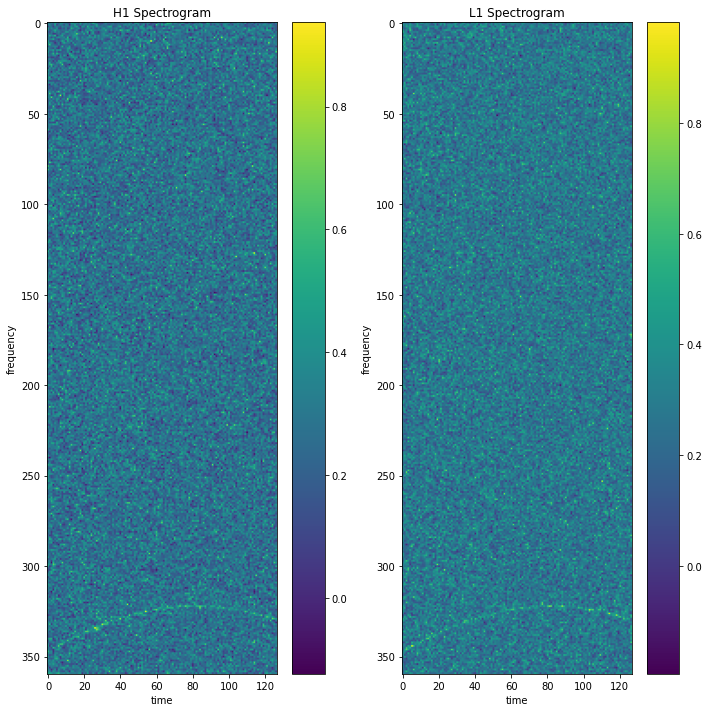

[[[0.34219623 0.19406636 0.33968183 ... 0.29579806 0.1102105  0.3908393 ]
  [0.2627544  0.41181338 0.23059689 ... 0.26045737 0.19645725 0.1854655 ]
  [0.08540688 0.28424504 0.27681243 ... 0.33344185 0.2613227  0.18201497]
  ...
  [0.3085315  0.2625543  0.02045513 ... 0.09910481 0.1792806  0.35247666]
  [0.35510463 0.41597706 0.14893036 ... 0.40289986 0.30759278 0.06087782]
  [0.51994205 0.48926663 0.46702778 ... 0.28537598 0.3311632  0.3374756 ]]

 [[0.15840635 0.24854666 0.16885151 ... 0.28289658 0.21531576 0.26101887]
  [0.5331196  0.25724554 0.448552   ... 0.5261203  0.30748698 0.29378527]
  [0.23568319 0.26001722 0.4841212  ... 0.19618055 0.42233345 0.33578017]
  ...
  [0.21250588 0.23649265 0.09281849 ... 0.19108345 0.23577474 0.19401585]
  [0.10769588 0.39410192 0.59806997 ... 0.3852973  0.14413792 0.41882324]
  [0.1973995  0.30954298 0.24057066 ... 0.21141222 0.39316136 0.37070584]]]

/kqi/output/g2net-detecting-continuous-gravitational-waves/test/0040fc1b3.hdf5
img.max(), img.m

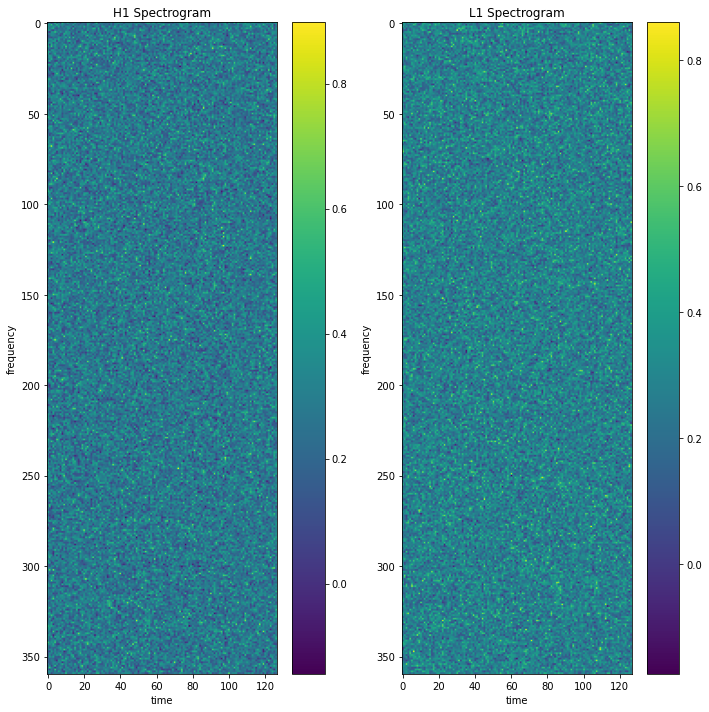

[[[0.07736786 0.3496049  0.05494046 ... 0.19155002 0.3540283  0.44152018]
  [0.4657996  0.3200271  0.5960561  ... 0.5029758  0.02926704 0.28569335]
  [0.34125388 0.345767   0.28197208 ... 0.38083768 0.1238444  0.25833604]
  ...
  [0.18503374 0.06627619 0.2811012  ... 0.2322971  0.0107666  0.34189725]
  [0.3602762  0.36871406 0.30563813 ... 0.46931154 0.3511963  0.2779731 ]
  [0.19237208 0.3398217  0.08676097 ... 0.3510688  0.10741103 0.2056939 ]]

 [[0.422007   0.36810735 0.19823812 ... 0.218259   0.16821289 0.24923775]
  [0.29640526 0.37947166 0.2150119  ... 0.4013699  0.34699437 0.19860569]
  [0.52973115 0.20094791 0.3789294  ... 0.44306642 0.08168674 0.12314453]
  ...
  [0.2782259  0.3175758  0.2978436  ... 0.36023763 0.39273003 0.19029677]
  [0.1610341  0.33252877 0.40310833 ... 0.0315484  0.3016466  0.2580458 ]
  [0.20174307 0.26652467 0.32578507 ... 0.33429092 0.38051757 0.2936849 ]]]


In [21]:
print("=> train label dist")
print(train_df.target.value_counts())
print()

print("=> train+test SFTs w")
_df = pd.concat([train_df, test_df])
print("H1 SFTs w max(), min()", _df["H1 SFTs w"].max(), _df["H1 SFTs w"].min())
print("L1 SFTs w max(), min()", _df["L1 SFTs w"].max(), _df["L1 SFTs w"].min())
print()

#normalize_type = "default-norm|p-norm|ts-a"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "spec-sequence_a|ts-ma|p-norm"
#normalize_type = "spec-sequence_a|ts-ma|p-stand"
#normalize_type = "spec-sequence_a|ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-norm"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|p-stand"
#normalize_type = "same_ts_interval|p-common-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel"

#cfg_step = 32
#cfg_step = 64
#cfg_step = 128

#cfg_spec_max = 4096
#cfg_spec_max = 4224


# 画像可視化
print("=> normalize_type:", normalize_type)

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", train_df.iloc[_i]["target"])
show_1img_2ch(img)
print(img)

print()
_path = test_df.iloc[_i]["path"]
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/a666b93a9.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d6828b59a.hdf5"
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360)
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", test_df.iloc[806]["target"])
show_1img_2ch(img)
print(img)

/workspace/g2net2/input/train/02887d232.hdf5
(2, 360, 127)


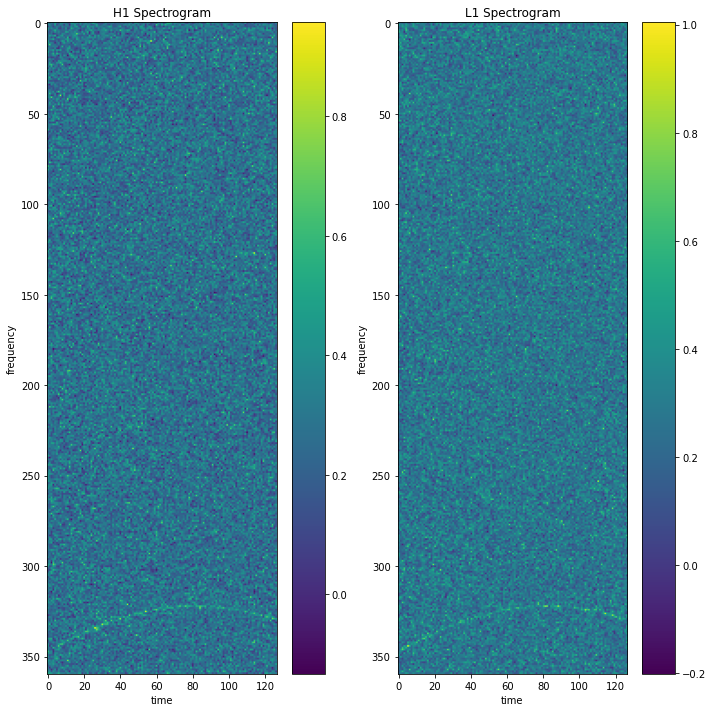

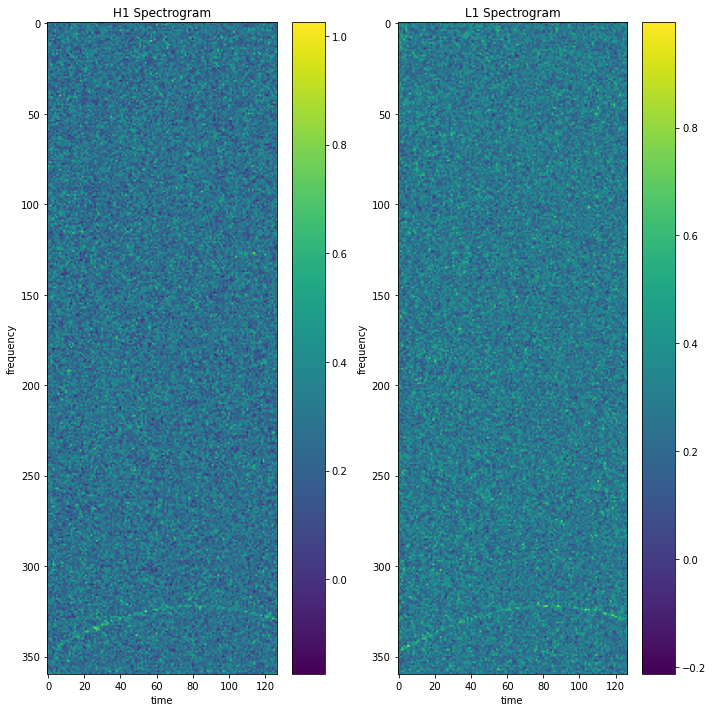

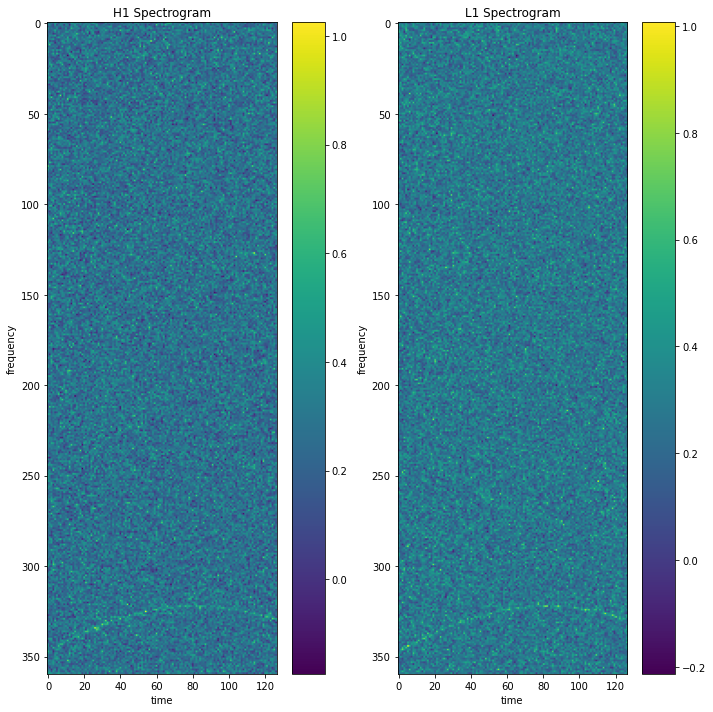

In [22]:
%reload_ext autoreload
%autoreload 2
from src import audio_augments

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )

xxx = img.copy()
print(xxx.shape)
show_1img_2ch(img)

_transform = audio_augments.GaussianNoiseSNR(min_snr=15, max_snr=30, p=1.0)  # https://github.com/analokmaus/kaggle-g2net-public/blob/main/configs.py
#_transform = audio_augments.GaussianNoiseSNR(min_snr=5.0, max_snr=20.0, p=1.0)
xxx = _transform(xxx)
show_1img_2ch(xxx)
xxx[1] = _transform(xxx[1])
show_1img_2ch(xxx)

In [23]:
#%debug

In [24]:
#=====

# To npy

In [25]:
#!rm -r {NPY_DIR}/{normalize_type}

In [26]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def hdf5_to_npy(h_paths, out_dir):
    """
    前処理したhdf5データをnpyに保存する
    """
    if cfg_is_npy and (os.path.exists(out_dir) == False): 
        os.makedirs(out_dir, exist_ok=True)
        for _path in tqdm(h_paths):
            img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                              norm_type=normalize_type, 
                              ch=cfg_ch, 
                              freq=360,
                             )
            np.save(os.path.join(out_dir, f'{Path(_path).stem}.npy'), np.array(img))
    else:
        print(f"INFO: Exist {out_dir}")


if cfg_is_npy:
    _npy_dir = f"{NPY_DIR}/{normalize_type}"
    _max_workers = multiprocessing.cpu_count()  # total CPU
    with ThreadPoolExecutor(max_workers=_max_workers, thread_name_prefix="thread") as executor:
        hdf5_to_npy(train_df["path"].to_numpy(), f"{_npy_dir}/train")
        if IS_MAKE_SUB or (PSEUDO_CSV != ""):
            hdf5_to_npy(test_df["path"].to_numpy(), f"{_npy_dir}/test")
        if ADD_DIRS_STR != "":
            for _add_dir in eval(ADD_DIRS_STR):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        if ADD_PSEUDO_DIRS != "":
            for _add_dir in eval(ADD_PSEUDO_DIRS):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        
    # path書き換え
    train_df["path"] = f"{_npy_dir}/train/" + train_df["id"] + ".npy"
    print(train_df["path"].iloc[0])  # パス確認
    if IS_MAKE_SUB:
        test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
        print(test_df["path"].iloc[0])  # パス確認
    if ADD_DIRS_STR != "":
        add_df_all["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_df_all["path"].to_numpy()
        ]
        add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_df_all["path"].iloc[0])  # パス確認
    if PSEUDO_CSV != "":
        pseudo_df["path"] = f"{_npy_dir}/test/" + pseudo_df["id"] + ".npy"
        pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(pseudo_df["path"].iloc[0])  # パス確認
    if ADD_PSEUDO_DIRS != "":
        add_pseudo_df["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_pseudo_df["path"].to_numpy()
        ]
        add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_pseudo_df["path"].iloc[0])  # パス確認

INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/train
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/test
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex003_generating_noise_2_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_noise_gap1400
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_signal_gap800
INFO: Exist /workspace/g2ne

In [27]:
#=====

# Libraries

In [28]:
import warnings
warnings.filterwarnings("ignore")  

import os
import gc
import cv2
import math
import copy
import time
import random
import shutil
import yaml
import glob
from pprint import pprint
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict
import traceback
import imagesize

# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
from PIL import Image
from matplotlib import pyplot as plt

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import torchaudio

# Utils
import pickle, joblib
from tqdm import tqdm
tqdm.pandas()

# Sklearn Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

# For Image Models
import timm
print("timm:", timm.__version__)
from timm.data import ImageDataset
from timm.data.mixup import Mixup, one_hot
from timm.data.auto_augment import rand_augment_transform
from timm.loss.cross_entropy import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from timm.scheduler import CosineLRScheduler  # warmupつきCosineAnnealingLR

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# tta
import ttach as tta

# DDP
# 何故か3090ではエラーになる
#from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

## Synchronized-BatchNorm for DP
## https://blog.shikoan.com/sync-batch-norm-pytorch/
#import sys
#sys.path.append('./Synchronized-BatchNorm-PyTorch')
#from sync_batchnorm import convert_model, DataParallelWithCallback 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TORCH_VERSION = '.'.join(torch.__version__.split('.')[:3])
print('torch:', TORCH_VERSION)

timm: 0.6.12
device: cuda
torch: 1.13.1+cu117


In [29]:
%reload_ext autoreload
%autoreload 2
from src.sam import SAM, ASAM
from src.cv_split import cv_split, cv_split_kfold

In [30]:
## timmのモデル一覧
## https://github.com/rwightman/pytorch-image-models/blob/master/results/README.md
##!pip install "git+https://github.com/rwightman/pytorch-image-models.git"
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [31]:
#def test_timm_lr_Scheduler():
#    """
#    timmのlr_Schedulerの動作確認
#    https://timm.fast.ai/SGDR#cycle_limit=2
#    """
#    from timm import create_model 
#    from timm.optim import create_optimizer
#    from types import SimpleNamespace
#    from matplotlib import pyplot as plt
#
#    def get_lr_per_epoch(scheduler, num_epoch):
#        lr_per_epoch = []
#        for epoch in range(num_epoch):
#            lr_per_epoch.append(scheduler.get_epoch_values(epoch))
#        return lr_per_epoch
#
#    model = create_model('resnet34')
#
#    num_epoch = 50
#    
#    args = SimpleNamespace()
#    args.weight_decay = 0
#    args.lr = 1e-2
#    args.opt = 'adam' 
#    args.momentum = 0.9
#
#    optimizer = create_optimizer(args, model)
#
#    scheduler = CosineLRScheduler(optimizer, 
#                                  t_initial=num_epoch//3,  # 総エポック数
#                                  lr_min=args.lr*1e-2,  # 最小学習率
#                                  warmup_t=3,  # ウォームアップ完了時のエポック数
#                                  warmup_lr_init=args.lr*1e-2,  # ウォームアップの初期学習率
#                                  warmup_prefix=True,  # Warmupが完了したタイミングの学習率をオプティマイザーで設定した基本学習率にするかどうか
#                                  cycle_limit=1,  # lr restartの回数
#                                 )
#    lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
#
#    plt.plot([i for i in range(num_epoch)], lr_per_epoch);
#    
#test_timm_lr_Scheduler()

# CFG

In [32]:
import os, yaml, shutil

class Config:
    def __init__(self):
        self.name=NAME
        self.train=True
        self.debug=DEBUG
        self.print_freq=1000
        self.is_save_per_steps=False
        self.target_col="target"
        self.num_classes=1
        self.loss = "nn.BCEWithLogitsLoss"
        
        self.model_cls=model_cls
        self.apex=cfg_apex
        self.load_model_path=load_model_path
        #self.load_model_path=f"{OUTPUT_DIR}/tmp_fold0_seed0_best_score.pth"
        #self.is_load_opt=True
        self.is_load_opt=False
        
        # ============== model params ==============
        self.model_name=MODEL_NAME
        self.size_h=size_h
        self.size_w=size_w
        self.batch_size=BATCH_SIZE
        self.gradient_accumulation_steps=gradient_accumulation_steps
        self.is_syncBN = is_syncBN
        self.pretrained = cfg_pretrained
        self.drop_rate = cfg_drop_rate
        self.drop_path_rate = cfg_drop_path_rate
        # ==========================================
        
        self.num_workers=num_workers#8#16 if "/work" in os.getcwd() else 8
        self.epochs=epochs
        self.optimizer=cfg_optimizer
        self.lr=lr
        self.warmup_lr_init=self.lr*min_lr_ratio
        self.min_lr=self.lr*min_lr_ratio
        self.weight_decay=weight_decay
        self.scheduler=cfg_scheduler  # 'CosineLRScheduler'  # warmup
        self.warmup_t=warmup_t
        self.T_max=epochs
        self.max_grad_norm=1000
        
        self.cv_col=cfg_cv_col
        self.seeds=cfg_seeds
        self.n_fold=n_fold
        self.trn_fold=trn_fold
        
        self.is_wandb=is_wandb
        self.device_ids=device_ids
        
        # ============== data params ==============
        self.step=cfg_step
        self.spec_max=cfg_spec_max
        self.ch=cfg_ch
        self.freq=360
        self.norm_type=normalize_type
        # ==========================================
        
        # 自作mixup
        self.prob_mixup = cfg_prob_mixup  # 0.0なら発生確率=0
        self.mix_alpha = 1.0
        self.is_mix_or = True
        #self.mixup_off_epoch = self.epochs-5  # 最後の5epochはmixup/cutmixなしにする
        self.mixup_off_epoch = 0  # 常にmixup/cutmixなし
        
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        self.prob_sample_mixup = cfg_prob_sample_mixup
        # sample_mixupのデータはpseudoデータだけにするか
        self.is_sample_mixup_use_pseudo = cfg_is_sample_mixup_use_pseudo
        
        # 追加データのtarget=0とオリジナルのtarget=0とのmixup確率
        self.prob_add_sample_nega_mixup = cfg_prob_add_sample_nega_mixup
        
        # データセットの移動平均のpowerとのmixupの確率
        self.prob_mean_mixup = cfg_prob_mean_mixup
        
        # ch追加するか
        self.is_add_ch = cfg_is_add_ch
        
        # スペクトログラムの開始点をランダムに変えるか
        self.prob_spec_start_random = cfg_prob_spec_start_random
        
        # test setのような縦線や横線のノイズ入れる確率
        self.prob_noise_band = cfg_prob_noise_band
        
        # test setのような外れ点ノイズ入れる確率
        self.prob_noise_spot = cfg_prob_noise_spot
        
        # test setのようなまばらな外れ縦線ノイズ入れる確率
        self.prob_noise_vline = cfg_prob_noise_vline
        
        # test setのようなまばらな外れ横バンドノイズ入れる確率
        self.prob_noise_hband = cfg_prob_noise_hband
        
        # target=0のデータのチャネル入れ替える確率
        self.prob_swap_ch_nega = cfg_prob_swap_ch_nega
        
        # target=0のデータhflipする確率
        self.prob_flip_nega = cfg_prob_flip_nega
        
        # target=0のデータ同士をシャッフルする確率
        self.prob_swap_nega = cfg_prob_swap_nega
        
        # target=0のデータをVshiftする確率
        self.prob_vshift_nega = cfg_prob_vshift_nega
        
        # データ関係なくVshiftする確率
        self.prob_vshift = cfg_prob_vshift
        
        # torchaudioで縦横cutout(マスク)する本数
        self.time_mask_num = cfg_time_mask_num  # 縦線
        self.freq_mask_num = cfg_freq_mask_num  # 横線
        self.time_mask_param = cfg_time_mask_param  # マスクの可能な最大長。[0, time_mask_param) 
        self.freq_mask_param = cfg_freq_mask_param  # マスクの可能な最大長。[0, freq_mask_param) 
        
        # zip_datasetをtrainにして学習するか
        self.is_train_zip_dataset = cfg_is_train_zip_dataset
        
        # 生成したデータは別の切り方でfold分けるときに使うKfoldのAPI名(StratifiedKFold, KFoldなど)。""なら別の切り方でfold分けない
        self.add_split_str = cfg_add_split_str
        
        # データをnpyに変換するか
        self.is_npy = cfg_is_npy
        
        # 学習に追加した生成データのディレクトリ名
        self.add_dirs_str = ADD_DIRS_STR
        
        # 学習に追加したtestの疑似ラベルに使うcsv、確信度の閾値、ハードラベルにするか
        self.pseudo_csv = PSEUDO_CSV
        self.pseudo_ths = [cfg_pseudo_max, cfg_pseudo_min]
        self.is_pseudo_hard = cfg_is_pseudo_hard
        
        # 学習に追加したtestの疑似ラベルをリアルデータ/シュミレーションデータだけにするか
        self.pseudo_type = cfg_pseudo_type
        
        # 追加の疑似ラベルのディレクトリ名
        self.add_pseudo_dirs = ADD_PSEUDO_DIRS
        
        # MultiOutputに使う列の要素。freq_min//cfg_freq_div_n の freq_min//N 列をつくる
        self.freq_div_n = cfg_freq_div_n
        
        # これ以上の h1_mean+l1_mean, h1_std+l1_std を取る画像は除いて統計値出し、その統計値でalbの正規化行う
        self.alb_norm_mean_th = cfg_alb_norm_mean_th 
        self.alb_norm_std_th = cfg_alb_norm_std_th  
        
        # GaussianNoiseSNR行う確率, ノイズの大きさ
        self.prob_gauss_noise = cfg_prob_gauss_noise
        self.max_snr = cfg_max_snr
        self.min_snr = cfg_min_snr

CFG = Config()
        
if CFG.debug:
    #CFG.seeds=[0,1,2]
    CFG.is_wandb=False
    #CFG.is_wandb=True
    CFG.print_freq=10
    CFG.epochs=1
    #CFG.epochs=5
    #CFG.warmup_t=1
    #CFG.mixup_off_epoch=3
    #CFG.epochs=1
    #CFG.mixup_off_epoch=1
    #CFG.epochs=10
    #CFG.trn_fold=[0]
    #CFG.trn_fold=[0,1,2,3,4]
#    train_df = cv_split(train_df, 0, 10, cv_col="target")
#    train_df = train_df[train_df["fold"] == 0].reset_index(drop=True)
#    print("debug train_df.shape:", train_df.shape)
#    test_df = test_df.iloc[:30]
#    print("debug test_df.shape:", test_df.shape)
    # モデル削除
    !rm -f {OUTPUT_DIR}/*pth
    
with open(OUTPUT_DIR + "/cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)
        
if len(CFG.device_ids) > 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(_) for _ in CFG.device_ids])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    CFG.batch_size = CFG.batch_size*len(CFG.device_ids)
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(CFG.device_ids[0])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    # For descriptive error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    
pprint(CFG.__dict__)

os.environ['CUDA_VISIBLE_DEVICES']: 0
{'T_max': 100,
 'add_dirs_str': '[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, '
                 'EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, '
                 'EX006_SIGNAL800, EX006_SIGNAL_ISO800, '
                 'EX007_NONSTAT_NOISE800, EX007_NONSTAT_NOISE1000, '
                 'EX007_NONSTAT_NOISE1200]',
 'add_pseudo_dirs': '',
 'add_split_str': 'StratifiedKFold',
 'alb_norm_mean_th': 5,
 'alb_norm_std_th': 10,
 'apex': True,
 'batch_size': 64,
 'ch': 2,
 'cv_col': 'target',
 'debug': False,
 'device_ids': [0],
 'drop_path_rate': 0.2,
 'drop_rate': 0.4,
 'epochs': 100,
 'freq': 360,
 'freq_div_n': 50,
 'freq_mask_num': 2,
 'freq_mask_param': 10,
 'gradient_accumulation_steps': 1,
 'is_add_ch': False,
 'is_load_opt': False,
 'is_mix_or': True,
 'is_npy': True,
 'is_pseudo_hard': False,
 'is_sample_mixup_use_pseudo': True,
 'is_save_per_steps': False,
 'is_syncBN': False,
 'is_train_zip_dataset': False,
 'is_wandb': True,
 'load_mo

# Utils

In [33]:
def init_logger(log_file=OUTPUT_DIR + '/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('> SEEDING DONE')

# Wandb

In [34]:
if CFG.is_wandb:
    import wandb
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        wandb.login(key="")  # 自分の api key でログイン  # https://wandb.ai/settings
        wandb.init(project="", entity='', name=NAME)
        wandb.config.update(CFG.__dict__)  # ハイパラ登録

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anonamename. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Dataset

In [35]:
class TrainDataset(Dataset):
    def __init__(self, train, transforms=None, 
                 is_npy=True,
                 is_add_ch=False,
                 prob_spec_start_random=0.0,
                 prob_sample_mixup=0.0,
                 is_sample_mixup_use_pseudo=CFG.is_sample_mixup_use_pseudo,
                 prob_add_sample_nega_mixup=0.0,
                 prob_mean_mixup=0.0, 
                 prob_noise_band=0.0,
                 prob_noise_spot=0.0,
                 prob_noise_vline=0.0,
                 prob_noise_hband=0.0,
                 prob_swap_ch_nega=0.0,
                 prob_flip_nega=0.0,
                 prob_swap_nega=0.0,
                 prob_vshift_nega=0.0,
                 prob_vshift=0.0,
                 time_mask_num=0,
                 freq_mask_num=0,
                 time_mask_param=CFG.time_mask_param,
                 freq_mask_param=CFG.freq_mask_param,
                 prob_gauss_noise=0.0,
                 min_snr=CFG.min_snr,
                 max_snr=CFG.max_snr,
                ):
        self.train = train
        self.file_names = train['path'].values
        self.labels = train['target'].values
        self.transforms = transforms
        
        self.labels_freq = train['freq_min//N'].values - (40 // CFG.freq_div_n)  # for MultiOutput
        
        self.orig_flags = train['orig'].values  # np.nanは追加データ
        
        self.is_npy = is_npy  # npyをロードするか
        
        self.prob_spec_start_random = prob_spec_start_random  # スペクトログラムの開始点をランダムに変える確率
        
        self.is_add_ch = is_add_ch  # ch増やすか
        
        #self.train0 = train[train["target"] == 0]   # label=0のdf
        if is_sample_mixup_use_pseudo:
            #self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
            self.train0 = pseudo_df[pseudo_df["target"] < 0.5]   # label=0のdf pseudoのデータだけでmix
            if ADD_PSEUDO_DIRS != "":
                self.train0 = pd.concat([self.train0, add_pseudo_df], ignore_index=True)
        else:
            self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
        
        self.train0_orig = train[train["target"] < 0.5].dropna(subset=['freq min']).reset_index(drop=True)  # label=0かつオリジナルデータのdf
        
        self.prob_sample_mixup = prob_sample_mixup  # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        
        self.prob_add_sample_nega_mixup = prob_add_sample_nega_mixup  # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        
        self.prob_mean_mixup = prob_mean_mixup  # データセットの移動平均のpowerとのmixup
        
        self.prob_noise_band = prob_noise_band  # test setのような縦線や横線のノイズ入れる確率
        
        self.prob_noise_spot = prob_noise_spot  # test setのような外れ点ノイズ入れる確率
        
        self.prob_noise_vline = prob_noise_vline  # test setのようなまばらな外れ縦線ノイズ入れる確率
        
        self.prob_noise_hband = prob_noise_hband  # test setのようなまばらな外れ横バンドノイズ入れる確率
        
        self.prob_swap_ch_nega = prob_swap_ch_nega # negaサンプルch入れ替える確率
        
        self.prob_flip_nega = prob_flip_nega  # negaサンプルhflipする確率
        
        self.prob_swap_nega = prob_swap_nega  # negaサンプル別の使う確率
        
        self.prob_vshift_nega = prob_vshift_nega  # negaサンプルのみ縦方向に平行移動(VShift)する確率
        
        self.prob_vshift = prob_vshift  # 縦方向に平行移動(VShift)する確率
        
        self.time_mask_num = time_mask_num # number of time masking
        self.freq_mask_num = freq_mask_num # number of frequency masking
        self.transforms_time_mask = nn.Sequential(
            # time_mask_param はマスクする幅の最大長。[0, time_mask_param) 
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param),
        )
        self.transforms_freq_mask = nn.Sequential(
            # freq_mask_param はマスクする幅の最大長。[0, freq_mask_param) 
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param),
        )
        
        # GaussianNoiseSNR行う確率, ノイズの大きさ
        self.prob_gauss_noise = prob_gauss_noise  
        self.min_snr = min_snr,
        self.max_snr = max_snr
        
    def __len__(self):
        return len(self.train)
    
    def load_img(self, path):
        if self.is_npy:
            img = np.load(path)
        else:
            img = hdf5_to_img(path, CFG.step, CFG.spec_max, 
                              norm_type=CFG.norm_type, 
                              ch=CFG.ch, 
                              freq=CFG.freq)  # (C,H,W)
        img = img.transpose(1, 2, 0)  # (H,W,C)
    
        ### 振幅の開始点をランダムに変更
        if (np.random.rand() > 1 - self.prob_spec_start_random) and (img.shape[1] > CFG.size_w):
            spec_start = img.shape[1] - CFG.size_w
            spec_start = int(np.random.uniform(low=0, high=spec_start))
            img = img[:, spec_start:spec_start+CFG.size_w, :]  # shape=(360, size_w, 2)
            #print("spec_start:", spec_start)
        
        ### 横幅のサイズはsize_wまでにする
        if CFG.size_w > 0:
            img = img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
        
        #print("img.shape:", img.shape)
        return img
    
    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        img = self.load_img(self.file_names[index])
        
        orig_flag = self.orig_flags[index]
        
        # ===============================================
        # for MultiOutput
        # ===============================================
        label_freq = self.labels_freq[index]
        label_freq = torch.tensor(label_freq, dtype=torch.long)
        label_freq = one_hot(label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
        
        # ===============================================
        # test setのような縦線や横線のノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 v_noise_band {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 v_noise_band {v_n_line}")
            
        # ===============================================
        # test setのような外れ点ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_spot:
            # H1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 0] *= _ratio  # 係数掛ける
            #print(f"{index} H1 noise_spot {n_area}")
        if np.random.rand() > 1 - self.prob_noise_spot:
            # L1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 1] *= _ratio  # 係数掛ける
            #print(f"{index} L1 noise_spot {n_area}")
            
        # ===============================================
        # test setのようなまばらな外れ縦線ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_vline:
            # H1の外れ縦線
            v_n_line = np.random.randint(1,8)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 0] += _gs_n
            #print(f"{index} H1 noise_vline {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_vline:
            # L1の外れ縦線
            v_n_line = np.random.randint(1, 5)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,1].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 1] += _gs_n
            #print(f"{index} L1 noise_vline {v_n_line}")
            
        # ===============================================
        # test setのようなまばらな外れ横バンドノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_hband:
            # H1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 0] += _gs_n
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_hband:
            # L1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 1] += _gs_n
            #print(f"{index} L1 h_noise_band {w_n_line}")
            
        # ソフトラベルの対策。negativeとみなすラベルの値
        nega_th = 0.5
        
        # ===============================================
        # VShift
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        if (np.random.rand() > 1 - self.prob_vshift):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift")
        ### Negative VShift
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_vshift_nega):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift_nega")
        
        # ===============================================
        # Negative Swap CH
        # ===============================================
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_swap_ch_nega):
            i0 = img[:,:,0].copy()
            img[:,:,0] = img[:,:,1]
            img[:,:,1] = i0
            #print("swap_ch_nega")
        
        # ===============================================
        # 前回コンペ8位のaug
        # https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275335
        # ===============================================
        # LIGO Swap は A.ChannelShuffle で実行
        
        # Negative Flip
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[:, ::-1, :].copy()  # hflip
            #print("hflip_nega")
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[::-1, :, :].copy()  # vflip
            #print("vflip_nega")
        
        # Swap with Other Negative
        if (label < nega_th) and (self.prob_swap_nega > 0.0):
            sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,0] = sample_img[:,:,0]
                #print("h1 swap_nega")
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,1] = sample_img[:,:,1]
                #print("l1 swap_nega")
            
        # ===============================================
        # Sample Mixup
        # ===============================================
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        if np.random.rand() > 1 - self.prob_sample_mixup:
            if label < nega_th:
                sample = self.train.sample()
            else:
                sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            img = (img + sample_img) / 2.0
            # mix_sample_lam の割合で混ぜる
            #mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            #img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
            
            if sample.iloc[0]['target'] >= nega_th:
                label = torch.tensor(sample.iloc[0]['target']).float()
            
            # for MultiOutput
            sample_label_freq = sample.iloc[0]['freq_min//N'] - (40 // CFG.freq_div_n)
            sample_label_freq = torch.tensor(sample_label_freq, dtype=torch.long)
            sample_label_freq = one_hot(sample_label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
            label_freq = (label_freq + sample_label_freq) / 2.0
            
            #print("sample_mixup", sample.iloc[0]['target'])
            
        # ===============================================
        # Add Data Nega Sample Mixup
        # ===============================================
        # target=0について add_data と orig_data をmixup
        if np.random.rand() > 1 - self.prob_add_sample_nega_mixup:
            if np.isnan(orig_flag):
                # orig_flagがnegaならadd_data
                if label < nega_th:
                    sample = self.train0_orig.sample()
                sample_img = self.load_img(sample.iloc[0]['path'])
                # mix_sample_lam の割合で混ぜる
                mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
                img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
                #print("add_sample_nega_mixup")
        
        # ===============================================
        # Mean Mixup
        # ===============================================
        # データセット全体の移動平均とmix
        if np.random.rand() > 1 - self.prob_mean_mixup:

            # データセット全体の移動平均の振幅をパワーに変換
            abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step), dtype=np.float32)
            if ("ts-ma" in CFG.norm_type) and (cfg_step % 64 == 0):
                # step%64=0の移動平均は1要素減る
                abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step-1), dtype=np.float32)
            abs_mean_img[0] = amp2power(a_abs_mean_h1, "H1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img[1] = amp2power(a_abs_mean_l1, "L1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img = abs_mean_img.transpose(1, 2, 0)  # (H,W,C)
            # 横幅のサイズはsize_wまでにする
            if CFG.size_w > 0:
                abs_mean_img = abs_mean_img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
            
            # mean_lam の割合で混ぜる
            mean_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            img = mean_lam*img + (1-mean_lam)*abs_mean_img
        
            # 移動平均と混ぜた分のラベルもmix
            if label < nega_th:
                label += 0.1*(1-mean_lam)
            #print("mean_mixup")
            
        # ===============================================
        # ch増やす
        # ===============================================
        if self.is_add_ch:
            img = np.stack([img[:,:,0], img[:,:,1],
                            img[:,:,0] + img[:,:,1], 
                            img[:,:,0] - img[:,:,1]])  # (C,H,W)
            img = img.transpose(1, 2, 0)  # (H,W,C)
              
        if self.transforms:
            img = self.transforms(image=img)["image"]  # (C,H,W)
            
        # ===============================================
        # GaussianNoiseSNR
        # ===============================================
        if self.prob_gauss_noise > 0.0:
            _transform = audio_augments.GaussianNoiseSNRTorch(min_snr=self.min_snr, 
                                                              max_snr=self.max_snr, 
                                                              p=self.prob_gauss_noise)  
            img = _transform(img)
            #print("GaussianNoiseSNR")

        # ===============================================
        # Torchaudio Masking
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        # imgはtorch型の(C,H,W)形式じゃないとだめ
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.time_mask_num): # time masking
                img = self.transforms_time_mask(img)
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.freq_mask_num): # frequency masking
                img = self.transforms_freq_mask(img)
            
        return img, label, label_freq

# calc_mean_std

In [36]:
%reload_ext autoreload
%autoreload 2
from src import calc_mean_std

_df = pd.concat([train_df, test_df])
print(_df.shape)

if DEBUG:
    _df = _df.iloc[:10]

# 外れ値のデータは除く
_df = _df[
    (_df["h1_l1_mean"] <= CFG.alb_norm_mean_th)
    & (_df["h1_l1_std"] <= CFG.alb_norm_std_th)
].reset_index(drop=True)
print(_df.shape)
display(_df[["h1_mean", "l1_mean", "h1_std", "l1_std", "h1_l1_mean", "h1_l1_std"]].describe().style.background_gradient(cmap="Blues"))

_dataset = TrainDataset(_df, 
                        is_npy=CFG.is_npy, 
                        is_add_ch=CFG.is_add_ch,)
_loader = DataLoader(_dataset, 
                     #batch_size=CFG.batch_size * 2, # batch_size=1でないとだめ
                     shuffle=False, 
                     num_workers=CFG.num_workers, pin_memory=False, drop_last=False)
X_MEAN, X_STD, X_MAX = calc_mean_std.calc_mean_std_max(_dataset, _loader, N_CHANNELS=CFG.ch)

(8575, 37)
(7927, 37)


==> Computing mean and std..


100%|█████████████████████████████████████████████████████████| 7927/7927 [27:48<00:00,  4.75it/s]

mean, std, max: [0.2797384  0.27972412] [0.12301076 0.12294598] [2.8376431 2.6048286]


# Transform

In [37]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            ToTensorV2(),
        ])
    elif data == 'train_norm':
        print("train_norm")
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            A.Normalize(
                mean=X_MEAN, std=X_STD, max_pixel_value=np.max(X_MAX),
                p=1.0,
            ),
            ToTensorV2(),
        ])
    elif data == 'valid_norm':
        print("valid_norm")
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            A.Normalize(
                mean=X_MEAN, std=X_STD, max_pixel_value=np.max(X_MAX),
                p=1.0,
            ),
            ToTensorV2(),
        ])
    #elif data == 'tta1':
    #    return A.Compose([
    #        A.Resize(CFG.size_h, CFG.size_w),
    #        A.ChannelShuffle(always_apply=True, p=1.0),
    #        ToTensorV2(),
    #    ])

In [38]:
def mixup(x, y, alpha):
    """
    Usage:
        x, y = batch["x"], batch["y"]
        x, y_mixs = mixup(x, y.long(), 1.0)
        y_hat = model(x.float())
        loss = criterion(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + criterion(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])
    """
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.7)
    x = lam*x + (1-lam)*shuffled_x
    ys = (y, shuffled_y, lam)

    return x, ys

# Dataloader check

torch.Size([15, 2, 360, 127]) torch.Size([15]) torch.Size([15, 1, 11])


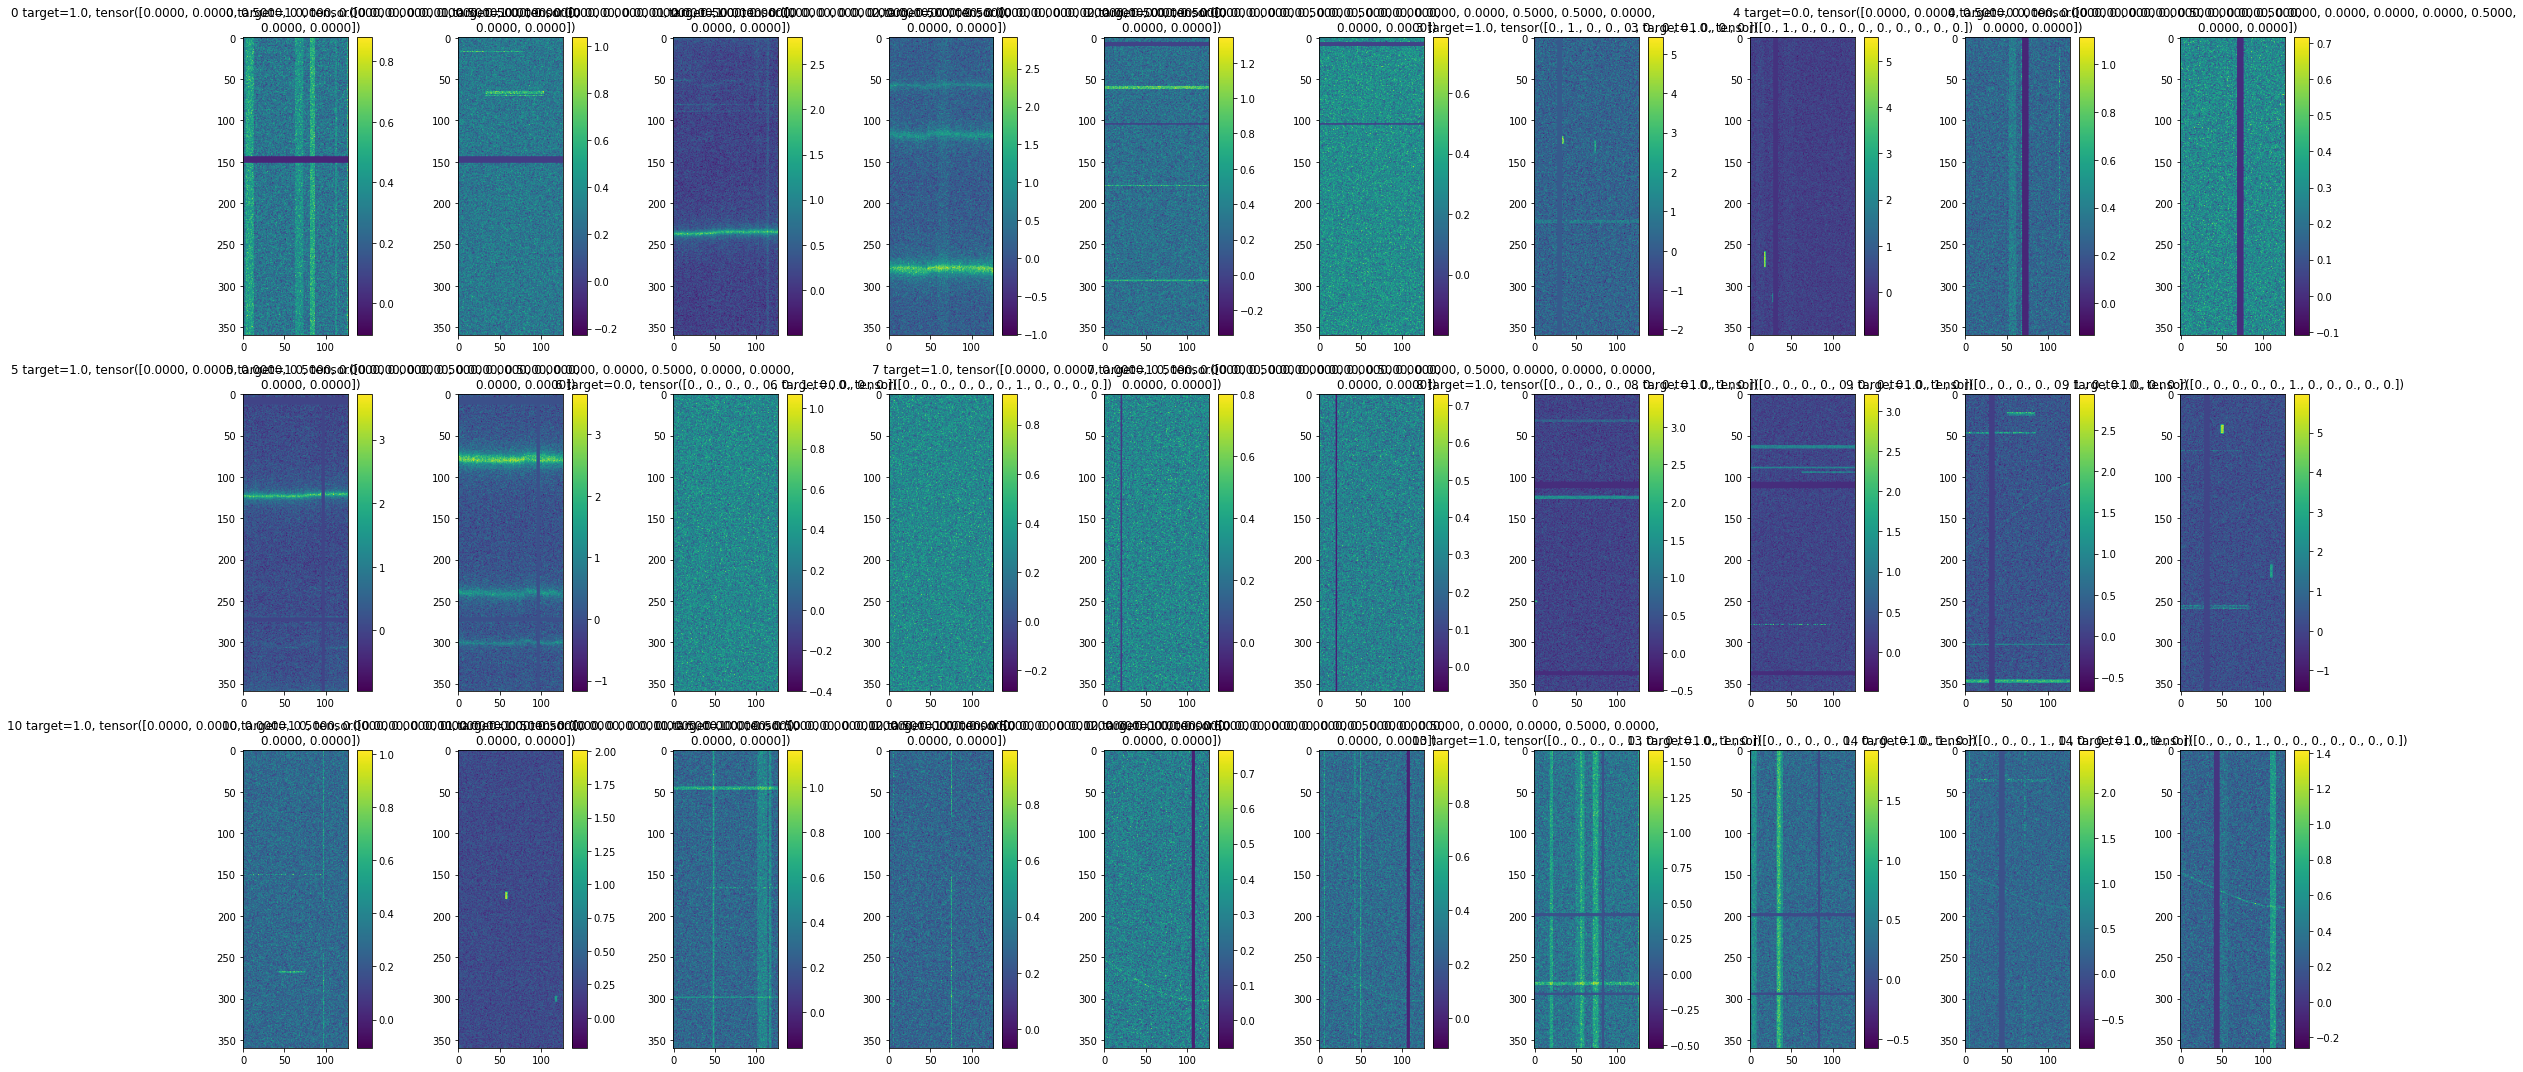

In [39]:
#%%time
# timeでファイルioに時間かかるか確認
if CFG.is_train_zip_dataset:
    train_dataset = ZipDataset(
        path=f"{zip_path}/archive", mod=zip_mod, transforms=get_transforms(data="train")
    )
else:
    train_dataset = TrainDataset(
        train_df,
        #pd.concat([train_df, add_df_all]),
        transforms=get_transforms(data="train"),
        #transforms=get_transforms(data="train_norm"),
        is_npy=CFG.is_npy,
        is_add_ch=CFG.is_add_ch,
        prob_spec_start_random=CFG.prob_spec_start_random,
        prob_sample_mixup=CFG.prob_sample_mixup,
        prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
        prob_mean_mixup=CFG.prob_mean_mixup,
        prob_noise_band=CFG.prob_noise_band,
        prob_noise_spot=CFG.prob_noise_spot,
        prob_noise_vline=CFG.prob_noise_vline,
        prob_noise_hband=CFG.prob_noise_hband,
        prob_swap_ch_nega=CFG.prob_swap_ch_nega,
        prob_flip_nega=CFG.prob_flip_nega,
        prob_swap_nega=CFG.prob_swap_nega,
        prob_vshift_nega=CFG.prob_vshift_nega,
        prob_vshift=CFG.prob_vshift,
        time_mask_num=CFG.time_mask_num,
        freq_mask_num=CFG.freq_mask_num,
        prob_gauss_noise=1,#CFG.prob_gauss_noise,
    )
    #train_dataset = TrainDataset(
    #    #train_df,
    #    pd.concat([train_df, add_df_all]),
    #    transforms=get_transforms(data="train"),
    #    is_npy=CFG.is_npy,
    #    #is_add_ch=True,
    #    #prob_spec_start_random=1.0,
    #    prob_add_sample_nega_mixup=1.0,
    #    prob_sample_mixup=1.0,
    #    prob_mean_mixup=1.0,
    #    prob_noise_band=1.0,
    #    prob_noise_spot=1.0,
    #    prob_noise_vline=1.0,
    #    prob_noise_hband=1.0,
    #    #prob_swap_ch_nega=1.0,
    #    #prob_flip_nega=1.0,
    #    #prob_swap_nega=1.0,
    #    #prob_vshift_nega=1.0,
    #    #prob_vshift=1.0,
    #    #time_mask_num=5,
    #    #freq_mask_num=5,
    #    prob_gauss_noise=1.0,
    #)
train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True,
    #collate_fn=mixup_collate_fn,
)
for step, (images, labels, labels_freq) in enumerate(train_loader):
    print(images.shape, labels.shape, labels_freq.shape)
    
    if normalize_type == "largekernel":
        plt.figure(figsize=(30,25))
    else:
        plt.figure(figsize=(30,15))
    i = 1
    for idx, (im, la, la_f) in enumerate(zip(images, labels, labels_freq)):
        #print(la_f.shape)
        #print(la_f.squeeze().shape)
        im = im.transpose(0, 1).transpose(1, 2)  # (H,W,C)
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,0])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,1])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if i > 30:
            break
            
    plt.tight_layout()
    plt.show()
    break

In [40]:
#%debug

In [41]:
#=====

# Model

In [42]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch)        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModel(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [43]:
# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook を参考にdropout入れて過学習避ける
class CustomModelDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch, 
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [44]:
class CustomModelMultiOutput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [45]:
class CustomModelMultiOutputDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch,
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutputDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [46]:
from src import layer_edit
class CustomModelMultiOutputStride12(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)
        
        # 最初の conv レイヤーのモデル ストライドをfirst_strideに変更
        self.net = layer_edit.patch_first_conv_stride(self.net, first_stride=(1,2))
        
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // cfg.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

In [47]:
from src import layer_edit
class CustomModelMultiOutputStride11(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)
        
        # 最初の conv レイヤーのモデル ストライドをfirst_strideに変更
        self.net = layer_edit.patch_first_conv_stride(self.net, first_stride=(1,1))
        
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // cfg.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2


In [48]:
#=====

In [49]:
class CustomModelAddEmb(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features+(500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, CFG.num_classes)  # embを1次元増やす
        )
    def forward(self, x, add_x):
        feat = self.net(x)
        #print(feat.shape, add_x.shape)
        y = self.head( torch.cat((feat, add_x), 1) )
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelAddEmb(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#add_x = torch.rand(CFG.batch_size, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)
#o = m(x.cuda(), add_x.cuda())
#print(o, o.shape)
##m

In [50]:
#=====

In [51]:
class CustomModelMultiInput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net1 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2) 
        self.net2 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2)
        self.head = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net1.num_features + self.net2.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        
        x1 = x[:, :CFG.ch//2, :, :]
        x2 = x[:, CFG.ch//2:, :, :]
        #print(x1.shape, x2.shape)
        
        feat1 = self.net1(x1)
        feat2 = self.net2(x2)
        y = self.head( torch.cat((feat1, feat2), 1) )
        #print(feat1.shape, feat2.shape, y.shape)
        
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelMultiInput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [52]:
#=====

In [53]:
class CustomModelLargeKernel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            pth = "/volume/kaggle/g2net2/kaggle_dl/g2net-detecting-continuous-gravitational-waves-v0/model_best.pth"
        else:
            pth = ""
        self.net = largekernel.get_model(
            model_name="tf_efficientnetv2_b0",
            path=pth,
            conv_in_chans=32
        )
        self.net.classifier = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelLargeKernel().cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [54]:
#=====

In [55]:
# https://github.com/sinpcw/kaggle-whale2/blob/master/models.py
def loadpth(pth: str, map_location=None) -> OrderedDict:
    """
    パラメータロードのヘルパー関数.
    DataParallel化したモデルは module.xxxx という形式で保存されるため読込み時にmodule.から始まる場合はそれを取除く.
    """
    ostate = torch.load(pth, map_location=map_location)['model']
    nstate = OrderedDict()
    for k, v in ostate.items():
        if k.startswith('module.'):
            nstate[k[len('module.'):]] = v
        else:
            nstate[k] = v
    return nstate

# Metric

In [56]:
def get_score(labels: np.ndarray, predictions: np.ndarray):
    # predictions が nan になったときの対策
    try:
        return roc_auc_score(labels, predictions)
    except:
        return 0.0

# Helper

In [57]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [58]:
def forward_step(step, losses, batch_size, model, criterion, images, labels, prob_mixup, optimizer, scaler, optimizer_step,
                 labels_freq, criterion2):  # for MultiOutput
    """
    SAMは2回forward必要だからforwardの処理（loss計算+backward）切り出す
    """
    # SAM 1st/2nd Path
    optimizer.step = optimizer_step
    
    # ===========================================
    # model forward for mixup
    # ===========================================
    if np.random.rand() > 1 - prob_mixup:
        x, y_mixs = mixup(images, labels.long(), CFG.mix_alpha)  # y_mixs=(target, shuffled_target, lambda)
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(x.float())  # for MultiOutput
                if CFG.is_mix_or:
                    y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                    loss = criterion(outputs, y_mix_or.float())
                else:
                    loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
        else:
            outputs, outputs2 = model(x.float())  # for MultiOutput
            if CFG.is_mix_or:
                y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                loss = criterion(outputs, y_mix_or.float())
            else:
                loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
    else:
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
                loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
        else:
            outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
            loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
            
    loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
    loss = (loss + loss2) / 2.0  # for MultiOutput
    
    # ===========================================
    # record loss
    # ===========================================
    losses.update(loss.item(), batch_size)  # loggerにloss保存
    if CFG.gradient_accumulation_steps > 1:
        loss = loss / CFG.gradient_accumulation_steps  # normalize loss to account for batch accumulation
    if CFG.apex:
        scaler.scale(loss).backward()  # 各パラメータの勾配を算出
    else:
        loss.backward()  # 誤差逆伝播して各パラメータの勾配を算出
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)  # 勾配クリッピング
    
    # ===========================================
    # optimizer step
    # ===========================================
    if (step + 1) % CFG.gradient_accumulation_steps == 0:
        if CFG.apex:
            scaler.step(optimizer)  # 勾配の情報を用いたパラメータの更新
            scaler.update()
        else:
            optimizer.step()  # 勾配の情報を用いたパラメータの更新
        optimizer.zero_grad()  # 勾配情報の初期化
        
    return optimizer, scaler, losses, grad_norm

In [59]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             prob_mixup=False, mixup_fn=None,
             criterion2=None):  # for MultiOutput
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    else:
        scaler = None
    losses = AverageMeter()
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        ## ===========================================
        ## timm mixup/cutmix
        ## ===========================================
        #if mixup_fn is not None:
        #    images, labels = mixup_fn(images, labels)
        #else:
        #    labels = one_hot(labels, CFG.num_classes, device=device)
        
        if isinstance(optimizer, SAM) or isinstance(optimizer, ASAM):
            optimizer, scaler, _, _ = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                   prob_mixup, optimizer, scaler, 
                                                   optimizer.first_step,
                                                   labels_freq, criterion2)  # for MultiOutput
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.second_step,
                                                                labels_freq, criterion2)  # for MultiOutput
        else:
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.step,
                                                                labels_freq, criterion2)  # for MultiOutput
            
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.4e}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=optimizer.param_groups[0]["lr"]))
        
        if CFG.is_save_per_steps:
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                OUTPUT_DIR + "/per_steps.pth",
            )

    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [60]:
@torch.inference_mode()  # pytorch >= 1.9
def valid_fn(valid_loader, model, criterion, device, 
             criterion2):  # for MultiOutput
    model.eval()
    losses = AverageMeter()
    preds = []
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(valid_loader):  # for MultiOutput
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        # ===========================================
        # compute loss
        # ===========================================
        with torch.no_grad():
            # for MultiOutput
            outputs, outputs2 = model(images)  # logit
        loss = criterion(outputs, labels)
        loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
        loss = (loss + loss2) / 2.0  # for MultiOutput
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        ## ===========================================
        ## record topk index
        ## ===========================================
        #_, tk = torch.topk(outputs, 5, dim=1)
        #topk_indexs = tk.to('cpu').detach().numpy()
        #preds.append(topk_indexs[:,0])  # top1
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, predictions

# Train loop

In [61]:
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold}, seed: {seed} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    if CFG.is_train_zip_dataset:
        train_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod, transforms=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, is_npy=False, transforms=get_transforms(data='valid'))
    else:
        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            train_transforms_type = 'train_norm'
            valid_transforms_type = 'valid_norm'
        else:
            train_transforms_type = 'train'
            valid_transforms_type = 'valid'
        train_dataset = TrainDataset(train_folds, 
                                     transforms=get_transforms(data=train_transforms_type), 
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                     prob_spec_start_random=CFG.prob_spec_start_random,
                                     prob_sample_mixup=CFG.prob_sample_mixup,
                                     prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
                                     prob_mean_mixup=CFG.prob_mean_mixup,
                                     prob_noise_band=CFG.prob_noise_band,
                                     prob_noise_spot=CFG.prob_noise_spot,
                                     prob_noise_vline=CFG.prob_noise_vline,
                                     prob_noise_hband=CFG.prob_noise_hband,
                                     prob_swap_ch_nega=CFG.prob_swap_ch_nega,
                                     prob_flip_nega=CFG.prob_flip_nega,
                                     prob_swap_nega=CFG.prob_swap_nega,
                                     prob_vshift_nega=CFG.prob_vshift_nega,
                                     prob_vshift=CFG.prob_vshift,
                                     time_mask_num=CFG.time_mask_num,
                                     freq_mask_num=CFG.freq_mask_num,
                                     prob_gauss_noise=CFG.prob_gauss_noise,
                                     min_snr=CFG.min_snr,
                                     max_snr=CFG.max_snr,
                                    )
        valid_dataset = TrainDataset(valid_folds, 
                                     transforms=get_transforms(data=valid_transforms_type),
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                    )
    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineLRScheduler':
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
        elif CFG.scheduler=='CosineLRScheduler_cycle_limit3':
            _cycle_limit = 3
            # https://timm.fast.ai/SGDR#cycle_limit=2
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs//_cycle_limit, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True,
                                          cycle_limit=_cycle_limit,
                                         )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = eval(CFG.model_cls)(pretrained=CFG.pretrained)
    
    if os.path.exists(CFG.load_model_path):
        LOGGER.info("=> loading checkpoint '{}'".format(CFG.load_model_path))
        states = torch.load(CFG.load_model_path, map_location=torch.device("cpu"))
        if len(CFG.device_ids) > 1:
            model.load_state_dict( loadpth(CFG.load_model_path, map_location=torch.device("cpu")) )
        else:
            model.load_state_dict(states["model"])
    
    if len(CFG.device_ids) > 1:
        if CFG.is_syncBN:
            # https://blog.shikoan.com/sync-batch-norm-pytorch/
            model = convert_model(model).to(device) # Batch NormをSync Batch Normに変換
            model = DataParallelWithCallback(model, device_ids=CFG.device_ids) # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids} use SyncBN")
        else:
            model.to(device)
            model = nn.DataParallel(model, device_ids=CFG.device_ids)  # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids}")
        # https://aru47.hatenablog.com/entry/2020/11/06/225052
        cudnn.benchmark = True
    else:
        model.to(device)

    if CFG.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == "adamw":
        optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'nesterov':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay, nesterov=True)
    elif CFG.optimizer == 'sam':
        optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=CFG.lr, weight_decay=CFG.weight_decay, rho=0.05)
        
    scheduler = get_scheduler(optimizer)
    
    if os.path.exists(CFG.load_model_path):
        if CFG.is_load_opt:
            LOGGER.info("=> loading optimizer and scheduler")
            optimizer.load_state_dict(states["optimizer"])
            scheduler.load_state_dict(states["scheduler"])

    if CFG.is_wandb:
        # wandbでpytorchのモデル監視
        wandb.watch(model)
            
    # ====================================================
    # loop
    # ====================================================
    train_criterion = eval(CFG.loss)().to(device)
    valid_criterion = eval(CFG.loss)().to(device)
    # for MultiOutput
    train_criterion2 = nn.CrossEntropyLoss().to(device)
    valid_criterion2 = nn.CrossEntropyLoss().to(device)
    
    best_score = -np.inf
    best_loss = np.inf
    
    #mixup_fn = Mixup(**CFG.mixup_args)
    mixup_fn = None
    prob_mixup = CFG.prob_mixup
    
    for epoch in range(CFG.epochs):
        
        # mixup_off_epoch以上はmixup/cutmixなしにする
        if epoch >= CFG.mixup_off_epoch:
            mixup_fn = None
            prob_mixup = 0.0
            #LOGGER.info(f'Epoch {epoch+1} - mixup_fn=None')
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, train_criterion, optimizer, epoch, scheduler, device, 
                            prob_mixup=prob_mixup,
                            criterion2=train_criterion2)  # for MultiOutput

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, valid_criterion, device,
                                       valid_criterion2)  # for MultiOutput
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineLRScheduler):
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler.step(epoch+1)
            
        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - lr: {optimizer.param_groups[0]["lr"]:.4e}')
       
        if CFG.is_wandb:
            # save log wandb
            wandb.log({f"[fold{fold}] epoch": epoch+1,
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] lr": optimizer.param_groups[0]["lr"]})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
            
    valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth', map_location=torch.device('cpu'))['preds'].tolist()
    #valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth', map_location=torch.device('cpu'))['preds'].tolist()

    return valid_folds

# Main

In [62]:
def get_result(result_df, preds_col="preds", add_info=""):
    labels = result_df[CFG.target_col].values
    preds = result_df[preds_col].values
    preds = np.array([np.array(p) for p in preds])
    score = get_score(labels, preds)
    LOGGER.info(f'{add_info}Score: {score:<.4f}')
    return score
    

def main(df):
    if CFG.train:
        oof_scores = []
        for seed in CFG.seeds:
            seed_torch(seed)
            
            # 生成データロード
            if ADD_DIRS_STR != "":
                add_df = pd.read_csv(f"{OUTPUT_DIR}/add_data.csv")
                if CFG.debug:
                    add_df = cv_split_kfold(add_df, 0, 10)
                    add_df = add_df[add_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_df.shape: {str(add_df.shape)}")

                # cv_split
                if CFG.add_split_str == "":
                    folds = pd.concat([df, add_df], ignore_index=True)
                    folds = cv_split(folds, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                else:
                    # オリジナルデータと生成データは別の切り方でfold分ける
                    if CFG.add_split_str == "KFold":
                        add_df = cv_split_kfold(add_df, seed, CFG.n_fold)
                    else:
                        add_df = cv_split(add_df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold

                    folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                    folds = pd.concat([folds, add_df], ignore_index=True) 
                    
                # 生成データのtarget=1はすべてtrainに使う
                if IS_ADD_ALL_TRAIN1:
                    _orig_folds = folds.dropna(subset=['freq_min//10_target'])
                    _add_folds = folds.dropna(subset=['type'])
                    _add_target0 = _add_folds[_add_folds[CFG.target_col] == 0]
                    _add_target1 = _add_folds[_add_folds[CFG.target_col] == 1]
                    _add_target1["fold"] = -1    
                    folds = pd.concat([_orig_folds, _add_target0, _add_target1]).reset_index(drop=True)
                    print(folds.groupby(['fold', CFG.target_col]).size())

            else:
                folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                
            # zip_df.csvでfinetuneする場合
            if CFG.is_train_zip_dataset:
                folds = pd.read_csv(f'{zip_path}/zip_df.csv')                
                df["fold"] = 0
                folds = pd.concat([folds, df], ignore_index=True)
                
            # 疑似ラベル全foldのtrainに入れる
            if PSEUDO_CSV != "":
                pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/pseudo_df.csv")
                if CFG.debug:
                    pseudo_df = cv_split_kfold(pseudo_df, 0, 30)
                    pseudo_df = pseudo_df[pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"pseudo_df.shape: {str(pseudo_df.shape)}")
                pseudo_df["fold"] = -1
                folds = pd.concat([folds, pseudo_df], ignore_index=True)
            if ADD_PSEUDO_DIRS != "":
                add_pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv")
                if CFG.debug:
                    add_pseudo_df = cv_split_kfold(add_pseudo_df, 0, 30)
                    add_pseudo_df = add_pseudo_df[add_pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_pseudo_df.shape: {str(add_pseudo_df.shape)}")
                add_pseudo_df["fold"] = -1
                folds = pd.concat([folds, add_pseudo_df], ignore_index=True)
                
            folds.to_csv(OUTPUT_DIR +f"/folds_seed{seed}.csv", index=False)
            LOGGER.info(f"folds.shape: {str(folds.shape)}")
            
            # train fold
            scores = []
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(folds, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} seed: {seed} result ==========")
                    _score = get_result(_oof_df, add_info=f"fold{fold} ")
                    scores.append(_score)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            # CV result
            LOGGER.info(f"========== CV ==========")
            LOGGER.info(f'macro mean folds Score ± std: {np.mean(scores):<.4f} ± {np.std(scores):<.4f}')
            oof_score = get_result(oof_df, add_info=f"oof ")
            oof_scores.append(oof_score)
            # save result
            oof_df.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}.csv', index=False)
            
            if CFG.is_wandb:
                # save log wandb
                wandb.log({f"[fold{str(CFG.trn_fold)}] best_score": oof_score})
            
            plt.hist(oof_df["preds"], bins=100)
            plt.show()
            plt.clf()  # メモリ解放
            plt.close()
            
        if len(oof_scores) > 1:
            LOGGER.info(f'seed macro mean oof Score ± std: {np.mean(oof_scores):<.4f} ± {np.std(oof_scores):<.4f}') 

add_df.shape: (11383, 24)
pseudo_df.shape: (7327, 36)


> SEEDING DONE
fold0: (2277,)
fold1: (2277,)
fold2: (2277,)
fold3: (2276,)
fold4: (2276,)
fold  target
0     0         1477
      1          800
1     0         1477
      1          800
2     0         1477
      1          800
3     0         1476
      1          800
4     0         1476
      1          800
dtype: int64
fold0: (120,)
fold1: (120,)
fold2: (120,)
fold3: (120,)
fold4: (120,)
fold  target
0     0         40
      1         80
1     0         40
      1         80
2     0         40
      1         80
3     0         40
      1         80
4     0         40
      1         80
dtype: int64


folds.shape: (19310, 44)
========== fold: 0, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/264] Elapsed 0m 5s (remain 22m 58s) Loss: 1.5430(1.5430) Grad: 45046.4727  LR: 4.0000e-06  
Epoch: [1][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.5198(1.5356) Grad: 44990.4961  LR: 4.0000e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 29s) Loss: 1.5571(1.5571) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.5148(1.5292) 


Epoch 1 - avg_train_loss: 1.5356  avg_val_loss: 1.5292  time: 201s
Epoch 1 - Score: 0.6609
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6609 Model
Epoch 1 - Save Best Loss: 1.5292 Model


Epoch: [2][0/264] Elapsed 0m 3s (remain 14m 0s) Loss: 1.5286(1.5286) Grad: 49310.3281  LR: 1.3600e-04  
Epoch: [2][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3565(1.4082) Grad: 39316.0234  LR: 1.3600e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2924(1.2924) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1987(1.2751) 


Epoch 2 - avg_train_loss: 1.4082  avg_val_loss: 1.2751  time: 199s
Epoch 2 - Score: 0.8716
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8716 Model
Epoch 2 - Save Best Loss: 1.2751 Model


Epoch: [3][0/264] Elapsed 0m 3s (remain 13m 34s) Loss: 1.3390(1.3390) Grad: 37916.0352  LR: 2.6800e-04  
Epoch: [3][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3388(1.3731) Grad: 24561.7441  LR: 2.6800e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2625(1.2625) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1676(1.2546) 


Epoch 3 - avg_train_loss: 1.3731  avg_val_loss: 1.2546  time: 200s
Epoch 3 - Score: 0.8816
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8816 Model
Epoch 3 - Save Best Loss: 1.2546 Model


Epoch: [4][0/264] Elapsed 0m 4s (remain 19m 32s) Loss: 1.3740(1.3740) Grad: 25356.2852  LR: 4.0000e-04  
Epoch: [4][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3923(1.3678) Grad: 27017.1973  LR: 4.0000e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2545(1.2545) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1588(1.2559) 


Epoch 4 - avg_train_loss: 1.3678  avg_val_loss: 1.2559  time: 203s
Epoch 4 - Score: 0.8928
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8928 Model


Epoch: [5][0/264] Elapsed 0m 3s (remain 13m 51s) Loss: 1.3879(1.3879) Grad: 26790.0254  LR: 3.9990e-04  
Epoch: [5][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3665(1.3592) Grad: 28348.9629  LR: 3.9990e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2143(1.2143) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1830(1.2465) 


Epoch 5 - avg_train_loss: 1.3592  avg_val_loss: 1.2465  time: 199s
Epoch 5 - Score: 0.8835
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Loss: 1.2465 Model


Epoch: [6][0/264] Elapsed 0m 4s (remain 17m 42s) Loss: 1.3717(1.3717) Grad: 26434.2734  LR: 3.9961e-04  
Epoch: [6][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3755(1.3517) Grad: 39176.2734  LR: 3.9961e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2658(1.2658) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3037(1.2955) 


Epoch 6 - avg_train_loss: 1.3517  avg_val_loss: 1.2955  time: 200s
Epoch 6 - Score: 0.8488
Epoch 6 - lr: 3.9912e-04


Epoch: [7][0/264] Elapsed 0m 3s (remain 16m 14s) Loss: 1.4137(1.4137) Grad: 49159.0312  LR: 3.9912e-04  
Epoch: [7][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3567(1.3502) Grad: 12099.7139  LR: 3.9912e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2549(1.2549) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1810(1.2444) 


Epoch 7 - avg_train_loss: 1.3502  avg_val_loss: 1.2444  time: 200s
Epoch 7 - Score: 0.8891
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Loss: 1.2444 Model


Epoch: [8][0/264] Elapsed 0m 2s (remain 12m 42s) Loss: 1.3308(1.3308) Grad: 19098.0762  LR: 3.9844e-04  
Epoch: [8][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3674(1.3415) Grad: 19981.7637  LR: 3.9844e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2195(1.2195) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1461(1.2327) 


Epoch 8 - avg_train_loss: 1.3415  avg_val_loss: 1.2327  time: 200s
Epoch 8 - Score: 0.8894
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Loss: 1.2327 Model


Epoch: [9][0/264] Elapsed 0m 3s (remain 15m 34s) Loss: 1.3601(1.3601) Grad: 24585.6465  LR: 3.9756e-04  
Epoch: [9][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3694(1.3421) Grad: 25673.6621  LR: 3.9756e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1999(1.1999) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1416(1.2225) 


Epoch 9 - avg_train_loss: 1.3421  avg_val_loss: 1.2225  time: 200s
Epoch 9 - Score: 0.8923
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Loss: 1.2225 Model


Epoch: [10][0/264] Elapsed 0m 3s (remain 13m 28s) Loss: 1.3292(1.3292) Grad: 23166.0820  LR: 3.9649e-04  
Epoch: [10][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3337(1.3390) Grad: 21424.3145  LR: 3.9649e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2614(1.2614) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1249(1.2306) 


Epoch 10 - avg_train_loss: 1.3390  avg_val_loss: 1.2306  time: 200s
Epoch 10 - Score: 0.8911
Epoch 10 - lr: 3.9523e-04


Epoch: [11][0/264] Elapsed 0m 3s (remain 15m 14s) Loss: 1.3480(1.3480) Grad: 28751.0371  LR: 3.9523e-04  
Epoch: [11][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3160(1.3362) Grad: 19215.7461  LR: 3.9523e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2757(1.2757) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1444(1.2284) 


Epoch 11 - avg_train_loss: 1.3362  avg_val_loss: 1.2284  time: 200s
Epoch 11 - Score: 0.8838
Epoch 11 - lr: 3.9378e-04


Epoch: [12][0/264] Elapsed 0m 3s (remain 14m 44s) Loss: 1.3204(1.3204) Grad: 18519.6719  LR: 3.9378e-04  
Epoch: [12][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3324(1.3411) Grad: 7992.2295  LR: 3.9378e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2454(1.2454) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1544(1.2357) 


Epoch 12 - avg_train_loss: 1.3411  avg_val_loss: 1.2357  time: 201s
Epoch 12 - Score: 0.8928
Epoch 12 - lr: 3.9214e-04
Epoch 12 - Save Best Score: 0.8928 Model


Epoch: [13][0/264] Elapsed 0m 3s (remain 15m 17s) Loss: 1.3150(1.3150) Grad: 16628.1719  LR: 3.9214e-04  
Epoch: [13][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3147(1.3358) Grad: 25156.9102  LR: 3.9214e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2773(1.2773) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1223(1.2285) 


Epoch 13 - avg_train_loss: 1.3358  avg_val_loss: 1.2285  time: 198s
Epoch 13 - Score: 0.8999
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Score: 0.8999 Model


Epoch: [14][0/264] Elapsed 0m 2s (remain 12m 12s) Loss: 1.3084(1.3084) Grad: 19474.8711  LR: 3.9031e-04  
Epoch: [14][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3769(1.3326) Grad: 25447.0684  LR: 3.9031e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1936(1.1936) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1448(1.2147) 


Epoch 14 - avg_train_loss: 1.3326  avg_val_loss: 1.2147  time: 201s
Epoch 14 - Score: 0.9036
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Score: 0.9036 Model
Epoch 14 - Save Best Loss: 1.2147 Model


Epoch: [15][0/264] Elapsed 0m 3s (remain 16m 32s) Loss: 1.3791(1.3791) Grad: 24140.4062  LR: 3.8829e-04  
Epoch: [15][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3561(1.3332) Grad: 25002.2891  LR: 3.8829e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1862(1.1862) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1689(1.2351) 


Epoch 15 - avg_train_loss: 1.3332  avg_val_loss: 1.2351  time: 201s
Epoch 15 - Score: 0.8998
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/264] Elapsed 0m 4s (remain 17m 33s) Loss: 1.3500(1.3500) Grad: 25052.9062  LR: 3.8610e-04  
Epoch: [16][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3488(1.3305) Grad: 24349.3770  LR: 3.8610e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3409(1.3409) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1215(1.2259) 


Epoch 16 - avg_train_loss: 1.3305  avg_val_loss: 1.2259  time: 202s
Epoch 16 - Score: 0.8898
Epoch 16 - lr: 3.8372e-04


Epoch: [17][0/264] Elapsed 0m 3s (remain 16m 1s) Loss: 1.3192(1.3192) Grad: 23792.5898  LR: 3.8372e-04  
Epoch: [17][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3003(1.3330) Grad: 20680.9453  LR: 3.8372e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1719(1.1719) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1438(1.2095) 


Epoch 17 - avg_train_loss: 1.3330  avg_val_loss: 1.2095  time: 200s
Epoch 17 - Score: 0.8968
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Loss: 1.2095 Model


Epoch: [18][0/264] Elapsed 0m 3s (remain 14m 34s) Loss: 1.3107(1.3107) Grad: 22383.8477  LR: 3.8116e-04  
Epoch: [18][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3528(1.3282) Grad: 18436.4297  LR: 3.8116e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2331(1.2331) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1336(1.2185) 


Epoch 18 - avg_train_loss: 1.3282  avg_val_loss: 1.2185  time: 199s
Epoch 18 - Score: 0.8950
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/264] Elapsed 0m 3s (remain 15m 31s) Loss: 1.3516(1.3516) Grad: 16307.2666  LR: 3.7842e-04  
Epoch: [19][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3252(1.3265) Grad: 23087.5547  LR: 3.7842e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2509(1.2509) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1130(1.2103) 


Epoch 19 - avg_train_loss: 1.3265  avg_val_loss: 1.2103  time: 201s
Epoch 19 - Score: 0.8949
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/264] Elapsed 0m 3s (remain 16m 35s) Loss: 1.3338(1.3338) Grad: 23538.4043  LR: 3.7551e-04  
Epoch: [20][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3603(1.3272) Grad: 21522.8105  LR: 3.7551e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3009(1.3009) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1163(1.2127) 


Epoch 20 - avg_train_loss: 1.3272  avg_val_loss: 1.2127  time: 200s
Epoch 20 - Score: 0.8934
Epoch 20 - lr: 3.7243e-04


Epoch: [21][0/264] Elapsed 0m 3s (remain 15m 29s) Loss: 1.3820(1.3820) Grad: 21761.2578  LR: 3.7243e-04  
Epoch: [21][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3037(1.3249) Grad: 21119.8789  LR: 3.7243e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2758(1.2758) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1231(1.2109) 


Epoch 21 - avg_train_loss: 1.3249  avg_val_loss: 1.2109  time: 200s
Epoch 21 - Score: 0.8895
Epoch 21 - lr: 3.6918e-04


Epoch: [22][0/264] Elapsed 0m 3s (remain 14m 21s) Loss: 1.2799(1.2799) Grad: 13889.9736  LR: 3.6918e-04  
Epoch: [22][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3803(1.3337) Grad: 13045.5273  LR: 3.6918e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2052(1.2052) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1100(1.2089) 


Epoch 22 - avg_train_loss: 1.3337  avg_val_loss: 1.2089  time: 200s
Epoch 22 - Score: 0.8980
Epoch 22 - lr: 3.6576e-04
Epoch 22 - Save Best Loss: 1.2089 Model


Epoch: [23][0/264] Elapsed 0m 3s (remain 14m 29s) Loss: 1.3344(1.3344) Grad: 21342.2617  LR: 3.6576e-04  
Epoch: [23][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3776(1.3277) Grad: 37072.0508  LR: 3.6576e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1992(1.1992) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1095(1.2048) 


Epoch 23 - avg_train_loss: 1.3277  avg_val_loss: 1.2048  time: 201s
Epoch 23 - Score: 0.8998
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Loss: 1.2048 Model


Epoch: [24][0/264] Elapsed 0m 3s (remain 16m 38s) Loss: 1.3752(1.3752) Grad: 19857.1523  LR: 3.6219e-04  
Epoch: [24][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3078(1.3213) Grad: 18139.5059  LR: 3.6219e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2330(1.2330) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1155(1.2045) 


Epoch 24 - avg_train_loss: 1.3213  avg_val_loss: 1.2045  time: 200s
Epoch 24 - Score: 0.8953
Epoch 24 - lr: 3.5845e-04
Epoch 24 - Save Best Loss: 1.2045 Model


Epoch: [25][0/264] Elapsed 0m 3s (remain 14m 15s) Loss: 1.3263(1.3263) Grad: 22850.1602  LR: 3.5845e-04  
Epoch: [25][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2829(1.3228) Grad: 18816.7109  LR: 3.5845e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2634(1.2634) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1187(1.2244) 


Epoch 25 - avg_train_loss: 1.3228  avg_val_loss: 1.2244  time: 200s
Epoch 25 - Score: 0.8916
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/264] Elapsed 0m 2s (remain 12m 41s) Loss: 1.3461(1.3461) Grad: 20426.8418  LR: 3.5456e-04  
Epoch: [26][263/264] Elapsed 3m 7s (remain 0m 0s) Loss: 1.2612(1.3234) Grad: 15118.1445  LR: 3.5456e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1960(1.1960) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1110(1.2092) 


Epoch 26 - avg_train_loss: 1.3234  avg_val_loss: 1.2092  time: 196s
Epoch 26 - Score: 0.9008
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/264] Elapsed 0m 3s (remain 14m 4s) Loss: 1.2807(1.2807) Grad: 17934.3086  LR: 3.5052e-04  
Epoch: [27][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3030(1.3221) Grad: 17562.3477  LR: 3.5052e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1784(1.1784) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1191(1.2027) 


Epoch 27 - avg_train_loss: 1.3221  avg_val_loss: 1.2027  time: 202s
Epoch 27 - Score: 0.9025
Epoch 27 - lr: 3.4634e-04
Epoch 27 - Save Best Loss: 1.2027 Model


Epoch: [28][0/264] Elapsed 0m 3s (remain 14m 48s) Loss: 1.3122(1.3122) Grad: 19551.1914  LR: 3.4634e-04  
Epoch: [28][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3205(1.3210) Grad: 20997.4902  LR: 3.4634e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2251(1.2251) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1086(1.2043) 


Epoch 28 - avg_train_loss: 1.3210  avg_val_loss: 1.2043  time: 201s
Epoch 28 - Score: 0.8979
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/264] Elapsed 0m 3s (remain 16m 29s) Loss: 1.3693(1.3693) Grad: 25423.8027  LR: 3.4201e-04  
Epoch: [29][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3375(1.3185) Grad: 27142.0352  LR: 3.4201e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.1766(1.1766) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1170(1.2157) 


Epoch 29 - avg_train_loss: 1.3185  avg_val_loss: 1.2157  time: 201s
Epoch 29 - Score: 0.9041
Epoch 29 - lr: 3.3754e-04
Epoch 29 - Save Best Score: 0.9041 Model


Epoch: [30][0/264] Elapsed 0m 3s (remain 14m 14s) Loss: 1.3338(1.3338) Grad: 21672.7441  LR: 3.3754e-04  
Epoch: [30][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2989(1.3228) Grad: 27649.6387  LR: 3.3754e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2316(1.2316) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1122(1.1991) 


Epoch 30 - avg_train_loss: 1.3228  avg_val_loss: 1.1991  time: 201s
Epoch 30 - Score: 0.8966
Epoch 30 - lr: 3.3294e-04
Epoch 30 - Save Best Loss: 1.1991 Model


Epoch: [31][0/264] Elapsed 0m 3s (remain 14m 59s) Loss: 1.3220(1.3220) Grad: 21328.1113  LR: 3.3294e-04  
Epoch: [31][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2917(1.3178) Grad: 10612.5752  LR: 3.3294e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2081(1.2081) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3315(1.2764) 


Epoch 31 - avg_train_loss: 1.3178  avg_val_loss: 1.2764  time: 200s
Epoch 31 - Score: 0.8643
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/264] Elapsed 0m 3s (remain 16m 25s) Loss: 1.3309(1.3309) Grad: 16211.7676  LR: 3.2821e-04  
Epoch: [32][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3531(1.3206) Grad: 21796.3594  LR: 3.2821e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2609(1.2609) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1085(1.1980) 


Epoch 32 - avg_train_loss: 1.3206  avg_val_loss: 1.1980  time: 200s
Epoch 32 - Score: 0.8919
Epoch 32 - lr: 3.2336e-04
Epoch 32 - Save Best Loss: 1.1980 Model


Epoch: [33][0/264] Elapsed 0m 3s (remain 14m 19s) Loss: 1.3406(1.3406) Grad: 17573.7773  LR: 3.2336e-04  
Epoch: [33][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2833(1.3156) Grad: 16907.3262  LR: 3.2336e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2283(1.2283) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1046(1.1948) 


Epoch 33 - avg_train_loss: 1.3156  avg_val_loss: 1.1948  time: 201s
Epoch 33 - Score: 0.8975
Epoch 33 - lr: 3.1838e-04
Epoch 33 - Save Best Loss: 1.1948 Model


Epoch: [34][0/264] Elapsed 0m 3s (remain 14m 17s) Loss: 1.2975(1.2975) Grad: 20068.6465  LR: 3.1838e-04  
Epoch: [34][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3278(1.3180) Grad: 20801.2832  LR: 3.1838e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2587(1.2587) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1050(1.1863) 


Epoch 34 - avg_train_loss: 1.3180  avg_val_loss: 1.1863  time: 199s
Epoch 34 - Score: 0.8977
Epoch 34 - lr: 3.1329e-04
Epoch 34 - Save Best Loss: 1.1863 Model


Epoch: [35][0/264] Elapsed 0m 3s (remain 13m 15s) Loss: 1.3091(1.3091) Grad: 15875.4268  LR: 3.1329e-04  
Epoch: [35][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2957(1.3187) Grad: 19724.2012  LR: 3.1329e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1730(1.1730) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1092(1.2142) 


Epoch 35 - avg_train_loss: 1.3187  avg_val_loss: 1.2142  time: 200s
Epoch 35 - Score: 0.8992
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/264] Elapsed 0m 3s (remain 14m 3s) Loss: 1.3439(1.3439) Grad: 23383.0527  LR: 3.0809e-04  
Epoch: [36][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3284(1.3141) Grad: 16424.9668  LR: 3.0809e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1923(1.1923) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1111(1.1947) 


Epoch 36 - avg_train_loss: 1.3141  avg_val_loss: 1.1947  time: 200s
Epoch 36 - Score: 0.9016
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/264] Elapsed 0m 3s (remain 13m 54s) Loss: 1.3054(1.3054) Grad: 17520.8750  LR: 3.0279e-04  
Epoch: [37][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2740(1.3148) Grad: 20141.1738  LR: 3.0279e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1807(1.1807) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1298(1.2066) 


Epoch 37 - avg_train_loss: 1.3148  avg_val_loss: 1.2066  time: 200s
Epoch 37 - Score: 0.9086
Epoch 37 - lr: 2.9739e-04
Epoch 37 - Save Best Score: 0.9086 Model


Epoch: [38][0/264] Elapsed 0m 3s (remain 14m 52s) Loss: 1.2856(1.2856) Grad: 18017.4570  LR: 2.9739e-04  
Epoch: [38][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3062(1.3143) Grad: 18996.5488  LR: 2.9739e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2005(1.2005) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2258(1.2418) 


Epoch 38 - avg_train_loss: 1.3143  avg_val_loss: 1.2418  time: 201s
Epoch 38 - Score: 0.9043
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/264] Elapsed 0m 3s (remain 14m 38s) Loss: 1.3497(1.3497) Grad: 27614.5039  LR: 2.9189e-04  
Epoch: [39][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2671(1.3130) Grad: 21836.5117  LR: 2.9189e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2514(1.2514) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1076(1.2002) 


Epoch 39 - avg_train_loss: 1.3130  avg_val_loss: 1.2002  time: 200s
Epoch 39 - Score: 0.8958
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/264] Elapsed 0m 3s (remain 15m 19s) Loss: 1.3527(1.3527) Grad: 16748.0215  LR: 2.8630e-04  
Epoch: [40][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3858(1.3169) Grad: 22687.1152  LR: 2.8630e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1969(1.1969) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1170(1.1877) 


Epoch 40 - avg_train_loss: 1.3169  avg_val_loss: 1.1877  time: 201s
Epoch 40 - Score: 0.9006
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/264] Elapsed 0m 3s (remain 13m 57s) Loss: 1.2286(1.2286) Grad: 18044.6484  LR: 2.8064e-04  
Epoch: [41][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3230(1.3150) Grad: 30750.3945  LR: 2.8064e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1809(1.1809) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2414(1.2550) 


Epoch 41 - avg_train_loss: 1.3150  avg_val_loss: 1.2550  time: 201s
Epoch 41 - Score: 0.9051
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/264] Elapsed 0m 3s (remain 15m 36s) Loss: 1.3529(1.3529) Grad: 20395.0215  LR: 2.7489e-04  
Epoch: [42][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3214(1.3110) Grad: 19939.3633  LR: 2.7489e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2114(1.2114) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1129(1.1837) 


Epoch 42 - avg_train_loss: 1.3110  avg_val_loss: 1.1837  time: 200s
Epoch 42 - Score: 0.9020
Epoch 42 - lr: 2.6907e-04
Epoch 42 - Save Best Loss: 1.1837 Model


Epoch: [43][0/264] Elapsed 0m 3s (remain 15m 59s) Loss: 1.3367(1.3367) Grad: 20793.5176  LR: 2.6907e-04  
Epoch: [43][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2813(1.3082) Grad: 18896.1191  LR: 2.6907e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.1717(1.1717) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1129(1.1751) 


Epoch 43 - avg_train_loss: 1.3082  avg_val_loss: 1.1751  time: 201s
Epoch 43 - Score: 0.9007
Epoch 43 - lr: 2.6319e-04
Epoch 43 - Save Best Loss: 1.1751 Model


Epoch: [44][0/264] Elapsed 0m 3s (remain 14m 48s) Loss: 1.2996(1.2996) Grad: 20438.7012  LR: 2.6319e-04  
Epoch: [44][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3139(1.3108) Grad: 23572.5020  LR: 2.6319e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.1863(1.1863) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3038(1.2575) 


Epoch 44 - avg_train_loss: 1.3108  avg_val_loss: 1.2575  time: 200s
Epoch 44 - Score: 0.8720
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/264] Elapsed 0m 4s (remain 20m 28s) Loss: 1.2957(1.2957) Grad: 20268.5078  LR: 2.5724e-04  
Epoch: [45][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3357(1.3098) Grad: 19485.0469  LR: 2.5724e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1690(1.1690) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2788(1.2384) 


Epoch 45 - avg_train_loss: 1.3098  avg_val_loss: 1.2384  time: 199s
Epoch 45 - Score: 0.8557
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/264] Elapsed 0m 3s (remain 16m 24s) Loss: 1.3546(1.3546) Grad: 17067.0547  LR: 2.5124e-04  
Epoch: [46][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3207(1.3077) Grad: 15534.3682  LR: 2.5124e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1894(1.1894) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1480(1.2117) 


Epoch 46 - avg_train_loss: 1.3077  avg_val_loss: 1.2117  time: 201s
Epoch 46 - Score: 0.9088
Epoch 46 - lr: 2.4519e-04
Epoch 46 - Save Best Score: 0.9088 Model


Epoch: [47][0/264] Elapsed 0m 3s (remain 14m 5s) Loss: 1.2879(1.2879) Grad: 22174.8867  LR: 2.4519e-04  
Epoch: [47][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3121(1.3138) Grad: 19977.9316  LR: 2.4519e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2034(1.2034) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1118(1.2064) 


Epoch 47 - avg_train_loss: 1.3138  avg_val_loss: 1.2064  time: 200s
Epoch 47 - Score: 0.9062
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/264] Elapsed 0m 3s (remain 15m 59s) Loss: 1.2123(1.2123) Grad: 17932.9824  LR: 2.3910e-04  
Epoch: [48][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3442(1.3095) Grad: 22910.9043  LR: 2.3910e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2809(1.2809) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1799(1.2514) 


Epoch 48 - avg_train_loss: 1.3095  avg_val_loss: 1.2514  time: 201s
Epoch 48 - Score: 0.8856
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/264] Elapsed 0m 3s (remain 17m 10s) Loss: 1.3229(1.3229) Grad: 21325.1934  LR: 2.3297e-04  
Epoch: [49][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3117(1.3057) Grad: 21832.1055  LR: 2.3297e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2291(1.2291) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1079(1.1715) 


Epoch 49 - avg_train_loss: 1.3057  avg_val_loss: 1.1715  time: 201s
Epoch 49 - Score: 0.8989
Epoch 49 - lr: 2.2682e-04
Epoch 49 - Save Best Loss: 1.1715 Model


Epoch: [50][0/264] Elapsed 0m 4s (remain 18m 46s) Loss: 1.3406(1.3406) Grad: 23312.5957  LR: 2.2682e-04  
Epoch: [50][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2191(1.3089) Grad: 16766.9609  LR: 2.2682e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1899(1.1899) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1128(1.1952) 


Epoch 50 - avg_train_loss: 1.3089  avg_val_loss: 1.1952  time: 201s
Epoch 50 - Score: 0.9020
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/264] Elapsed 0m 3s (remain 17m 5s) Loss: 1.3153(1.3153) Grad: 25437.8320  LR: 2.2063e-04  
Epoch: [51][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2864(1.3048) Grad: 15942.9805  LR: 2.2063e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2023(1.2023) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1078(1.1821) 


Epoch 51 - avg_train_loss: 1.3048  avg_val_loss: 1.1821  time: 200s
Epoch 51 - Score: 0.8993
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/264] Elapsed 0m 3s (remain 14m 33s) Loss: 1.3079(1.3079) Grad: 17781.8652  LR: 2.1443e-04  
Epoch: [52][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3200(1.3085) Grad: 24255.4453  LR: 2.1443e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1555(1.1555) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1139(1.1817) 


Epoch 52 - avg_train_loss: 1.3085  avg_val_loss: 1.1817  time: 199s
Epoch 52 - Score: 0.9034
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/264] Elapsed 0m 3s (remain 16m 39s) Loss: 1.3064(1.3064) Grad: 18017.1895  LR: 2.0822e-04  
Epoch: [53][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2991(1.3049) Grad: 26944.9199  LR: 2.0822e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1797(1.1797) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1144(1.2096) 


Epoch 53 - avg_train_loss: 1.3049  avg_val_loss: 1.2096  time: 201s
Epoch 53 - Score: 0.9090
Epoch 53 - lr: 2.0200e-04
Epoch 53 - Save Best Score: 0.9090 Model


Epoch: [54][0/264] Elapsed 0m 2s (remain 11m 45s) Loss: 1.2682(1.2682) Grad: 22713.4297  LR: 2.0200e-04  
Epoch: [54][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3248(1.3085) Grad: 18088.4824  LR: 2.0200e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2158(1.2158) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1133(1.1803) 


Epoch 54 - avg_train_loss: 1.3085  avg_val_loss: 1.1803  time: 200s
Epoch 54 - Score: 0.8994
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/264] Elapsed 0m 3s (remain 15m 4s) Loss: 1.2708(1.2708) Grad: 17617.0430  LR: 1.9578e-04  
Epoch: [55][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3390(1.3058) Grad: 18407.3281  LR: 1.9578e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2343(1.2343) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1130(1.1766) 


Epoch 55 - avg_train_loss: 1.3058  avg_val_loss: 1.1766  time: 201s
Epoch 55 - Score: 0.9019
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/264] Elapsed 0m 3s (remain 14m 54s) Loss: 1.3062(1.3062) Grad: 19767.8535  LR: 1.8957e-04  
Epoch: [56][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3135(1.3041) Grad: 25490.3730  LR: 1.8957e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1702(1.1702) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1204(1.1943) 


Epoch 56 - avg_train_loss: 1.3041  avg_val_loss: 1.1943  time: 200s
Epoch 56 - Score: 0.9044
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/264] Elapsed 0m 3s (remain 16m 17s) Loss: 1.3379(1.3379) Grad: 19581.3164  LR: 1.8337e-04  
Epoch: [57][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2956(1.3044) Grad: 8819.4023  LR: 1.8337e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1760(1.1760) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1284(1.2119) 


Epoch 57 - avg_train_loss: 1.3044  avg_val_loss: 1.2119  time: 201s
Epoch 57 - Score: 0.9107
Epoch 57 - lr: 1.7718e-04
Epoch 57 - Save Best Score: 0.9107 Model


Epoch: [58][0/264] Elapsed 0m 3s (remain 14m 24s) Loss: 1.2965(1.2965) Grad: 15165.9707  LR: 1.7718e-04  
Epoch: [58][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3037(1.3040) Grad: 20213.5664  LR: 1.7718e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2117(1.2117) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1135(1.1799) 


Epoch 58 - avg_train_loss: 1.3040  avg_val_loss: 1.1799  time: 199s
Epoch 58 - Score: 0.9000
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/264] Elapsed 0m 4s (remain 17m 53s) Loss: 1.2745(1.2745) Grad: 17928.5215  LR: 1.7103e-04  
Epoch: [59][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3531(1.3023) Grad: 30995.1641  LR: 1.7103e-04  
EVAL: [0/19] Elapsed 0m 0s (remain 0m 17s) Loss: 1.2270(1.2270) 
EVAL: [18/19] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2653(1.2535) 


Epoch 59 - avg_train_loss: 1.3023  avg_val_loss: 1.2535  time: 201s
Epoch 59 - Score: 0.8011
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/264] Elapsed 0m 2s (remain 11m 31s) Loss: 1.2575(1.2575) Grad: 20292.9297  LR: 1.6490e-04  
Epoch: [60][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2578(1.3035) Grad: 26071.7480  LR: 1.6490e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1524(1.1524) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2801(1.2476) 


Epoch 60 - avg_train_loss: 1.3035  avg_val_loss: 1.2476  time: 199s
Epoch 60 - Score: 0.8963
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/264] Elapsed 0m 3s (remain 16m 42s) Loss: 1.3322(1.3322) Grad: 14498.3086  LR: 1.5881e-04  
Epoch: [61][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3203(1.3047) Grad: 27609.1113  LR: 1.5881e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2315(1.2315) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1044(1.1676) 


Epoch 61 - avg_train_loss: 1.3047  avg_val_loss: 1.1676  time: 199s
Epoch 61 - Score: 0.9022
Epoch 61 - lr: 1.5276e-04
Epoch 61 - Save Best Loss: 1.1676 Model


Epoch: [62][0/264] Elapsed 0m 3s (remain 17m 3s) Loss: 1.3189(1.3189) Grad: 20615.4727  LR: 1.5276e-04  
Epoch: [62][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2632(1.3044) Grad: 11583.6074  LR: 1.5276e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2104(1.2104) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1045(1.1744) 


Epoch 62 - avg_train_loss: 1.3044  avg_val_loss: 1.1744  time: 199s
Epoch 62 - Score: 0.8988
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/264] Elapsed 0m 3s (remain 15m 57s) Loss: 1.2544(1.2544) Grad: 20812.3301  LR: 1.4676e-04  
Epoch: [63][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2903(1.3027) Grad: 22467.8496  LR: 1.4676e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1747(1.1747) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1269(1.2444) 


Epoch 63 - avg_train_loss: 1.3027  avg_val_loss: 1.2444  time: 199s
Epoch 63 - Score: 0.9119
Epoch 63 - lr: 1.4081e-04
Epoch 63 - Save Best Score: 0.9119 Model


Epoch: [64][0/264] Elapsed 0m 3s (remain 15m 55s) Loss: 1.2709(1.2709) Grad: 17464.9336  LR: 1.4081e-04  
Epoch: [64][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3176(1.3005) Grad: 18083.2227  LR: 1.4081e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1789(1.1789) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1160(1.1969) 


Epoch 64 - avg_train_loss: 1.3005  avg_val_loss: 1.1969  time: 201s
Epoch 64 - Score: 0.9077
Epoch 64 - lr: 1.3493e-04


Epoch: [65][0/264] Elapsed 0m 3s (remain 16m 20s) Loss: 1.2889(1.2889) Grad: 15606.6631  LR: 1.3493e-04  
Epoch: [65][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3212(1.3016) Grad: 20867.1426  LR: 1.3493e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.1640(1.1640) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1086(1.1857) 


Epoch 65 - avg_train_loss: 1.3016  avg_val_loss: 1.1857  time: 201s
Epoch 65 - Score: 0.9053
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/264] Elapsed 0m 3s (remain 14m 56s) Loss: 1.2819(1.2819) Grad: 17857.9473  LR: 1.2911e-04  
Epoch: [66][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2468(1.2994) Grad: 21383.0430  LR: 1.2911e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2066(1.2066) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1114(1.1683) 


Epoch 66 - avg_train_loss: 1.2994  avg_val_loss: 1.1683  time: 201s
Epoch 66 - Score: 0.8966
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/264] Elapsed 0m 3s (remain 15m 14s) Loss: 1.2574(1.2574) Grad: 26239.5078  LR: 1.2336e-04  
Epoch: [67][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3043(1.3028) Grad: 21263.1309  LR: 1.2336e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1805(1.1805) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1112(1.1734) 


Epoch 67 - avg_train_loss: 1.3028  avg_val_loss: 1.1734  time: 200s
Epoch 67 - Score: 0.8991
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/264] Elapsed 0m 3s (remain 15m 31s) Loss: 1.3034(1.3034) Grad: 25482.4473  LR: 1.1770e-04  
Epoch: [68][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3079(1.2986) Grad: 24571.7773  LR: 1.1770e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1666(1.1666) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1218(1.2022) 


Epoch 68 - avg_train_loss: 1.2986  avg_val_loss: 1.2022  time: 201s
Epoch 68 - Score: 0.9117
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/264] Elapsed 0m 3s (remain 15m 27s) Loss: 1.3071(1.3071) Grad: 18104.1758  LR: 1.1211e-04  
Epoch: [69][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2501(1.2975) Grad: 20179.0430  LR: 1.1211e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2333(1.2333) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1074(1.1877) 


Epoch 69 - avg_train_loss: 1.2975  avg_val_loss: 1.1877  time: 200s
Epoch 69 - Score: 0.8998
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/264] Elapsed 0m 3s (remain 15m 47s) Loss: 1.3308(1.3308) Grad: 20635.5957  LR: 1.0661e-04  
Epoch: [70][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2923(1.2983) Grad: 17377.3535  LR: 1.0661e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1871(1.1871) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1158(1.1800) 


Epoch 70 - avg_train_loss: 1.2983  avg_val_loss: 1.1800  time: 200s
Epoch 70 - Score: 0.9059
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/264] Elapsed 0m 3s (remain 15m 36s) Loss: 1.3077(1.3077) Grad: 36816.3008  LR: 1.0121e-04  
Epoch: [71][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3314(1.2988) Grad: 23383.8789  LR: 1.0121e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2021(1.2021) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1105(1.1724) 


Epoch 71 - avg_train_loss: 1.2988  avg_val_loss: 1.1724  time: 199s
Epoch 71 - Score: 0.9023
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/264] Elapsed 0m 3s (remain 13m 39s) Loss: 1.2518(1.2518) Grad: 22043.8945  LR: 9.5906e-05  
Epoch: [72][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3117(1.2979) Grad: 29054.4141  LR: 9.5906e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2284(1.2284) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1072(1.1828) 


Epoch 72 - avg_train_loss: 1.2979  avg_val_loss: 1.1828  time: 200s
Epoch 72 - Score: 0.9022
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/264] Elapsed 0m 3s (remain 15m 29s) Loss: 1.2856(1.2856) Grad: 16732.1328  LR: 9.0707e-05  
Epoch: [73][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3041(1.2965) Grad: 17730.4395  LR: 9.0707e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2181(1.2181) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1056(1.1636) 


Epoch 73 - avg_train_loss: 1.2965  avg_val_loss: 1.1636  time: 199s
Epoch 73 - Score: 0.9040
Epoch 73 - lr: 8.5619e-05
Epoch 73 - Save Best Loss: 1.1636 Model


Epoch: [74][0/264] Elapsed 0m 3s (remain 16m 15s) Loss: 1.3612(1.3612) Grad: 25764.3926  LR: 8.5619e-05  
Epoch: [74][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2996(1.2954) Grad: 31993.9863  LR: 8.5619e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1971(1.1971) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1099(1.1641) 


Epoch 74 - avg_train_loss: 1.2954  avg_val_loss: 1.1641  time: 200s
Epoch 74 - Score: 0.9032
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/264] Elapsed 0m 3s (remain 16m 25s) Loss: 1.2769(1.2769) Grad: 16983.9082  LR: 8.0644e-05  
Epoch: [75][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2706(1.2953) Grad: 25741.5723  LR: 8.0644e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2201(1.2201) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1145(1.1750) 


Epoch 75 - avg_train_loss: 1.2953  avg_val_loss: 1.1750  time: 198s
Epoch 75 - Score: 0.9038
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/264] Elapsed 0m 3s (remain 14m 57s) Loss: 1.3039(1.3039) Grad: 30892.8164  LR: 7.5790e-05  
Epoch: [76][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2508(1.2958) Grad: 20949.5586  LR: 7.5790e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1908(1.1908) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2454(1.2207) 


Epoch 76 - avg_train_loss: 1.2958  avg_val_loss: 1.2207  time: 198s
Epoch 76 - Score: 0.8750
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/264] Elapsed 0m 3s (remain 14m 30s) Loss: 1.2373(1.2373) Grad: 36855.0273  LR: 7.1060e-05  
Epoch: [77][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3765(1.2960) Grad: 24803.9609  LR: 7.1060e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.1838(1.1838) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1102(1.1752) 


Epoch 77 - avg_train_loss: 1.2960  avg_val_loss: 1.1752  time: 200s
Epoch 77 - Score: 0.9105
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/264] Elapsed 0m 3s (remain 16m 39s) Loss: 1.3338(1.3338) Grad: 23854.0977  LR: 6.6460e-05  
Epoch: [78][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2565(1.2943) Grad: 20966.9922  LR: 6.6460e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1808(1.1808) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1128(1.1837) 


Epoch 78 - avg_train_loss: 1.2943  avg_val_loss: 1.1837  time: 201s
Epoch 78 - Score: 0.9114
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/264] Elapsed 0m 3s (remain 16m 49s) Loss: 1.3108(1.3108) Grad: 19404.1230  LR: 6.1993e-05  
Epoch: [79][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2799(1.2955) Grad: 24238.9219  LR: 6.1993e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.1588(1.1588) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1114(1.1808) 


Epoch 79 - avg_train_loss: 1.2955  avg_val_loss: 1.1808  time: 201s
Epoch 79 - Score: 0.9133
Epoch 79 - lr: 5.7664e-05
Epoch 79 - Save Best Score: 0.9133 Model


Epoch: [80][0/264] Elapsed 0m 3s (remain 15m 56s) Loss: 1.3172(1.3172) Grad: 25336.1504  LR: 5.7664e-05  
Epoch: [80][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3386(1.2952) Grad: 25247.3594  LR: 5.7664e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1784(1.1784) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1081(1.1773) 


Epoch 80 - avg_train_loss: 1.2952  avg_val_loss: 1.1773  time: 201s
Epoch 80 - Score: 0.9087
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/264] Elapsed 0m 3s (remain 16m 18s) Loss: 1.2944(1.2944) Grad: 43820.7695  LR: 5.3478e-05  
Epoch: [81][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2827(1.2947) Grad: 26337.3301  LR: 5.3478e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1923(1.1923) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1076(1.1691) 


Epoch 81 - avg_train_loss: 1.2947  avg_val_loss: 1.1691  time: 201s
Epoch 81 - Score: 0.9062
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/264] Elapsed 0m 3s (remain 15m 19s) Loss: 1.2417(1.2417) Grad: 22938.1836  LR: 4.9438e-05  
Epoch: [82][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3393(1.2968) Grad: 20327.8789  LR: 4.9438e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2333(1.2333) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1125(1.1703) 


Epoch 82 - avg_train_loss: 1.2968  avg_val_loss: 1.1703  time: 200s
Epoch 82 - Score: 0.9021
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/264] Elapsed 0m 2s (remain 11m 29s) Loss: 1.2106(1.2106) Grad: 20140.6953  LR: 4.5549e-05  
Epoch: [83][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2842(1.2904) Grad: 20469.5918  LR: 4.5549e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1983(1.1983) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1082(1.1638) 


Epoch 83 - avg_train_loss: 1.2904  avg_val_loss: 1.1638  time: 198s
Epoch 83 - Score: 0.9052
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/264] Elapsed 0m 4s (remain 20m 7s) Loss: 1.2580(1.2580) Grad: 23056.8359  LR: 4.1815e-05  
Epoch: [84][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2634(1.2945) Grad: 19691.0449  LR: 4.1815e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1523(1.1523) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1157(1.1818) 


Epoch 84 - avg_train_loss: 1.2945  avg_val_loss: 1.1818  time: 202s
Epoch 84 - Score: 0.9134
Epoch 84 - lr: 3.8238e-05
Epoch 84 - Save Best Score: 0.9134 Model


Epoch: [85][0/264] Elapsed 0m 3s (remain 14m 21s) Loss: 1.3348(1.3348) Grad: 27449.8340  LR: 3.8238e-05  
Epoch: [85][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2573(1.2928) Grad: 22116.4902  LR: 3.8238e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2193(1.2193) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1081(1.1769) 


Epoch 85 - avg_train_loss: 1.2928  avg_val_loss: 1.1769  time: 199s
Epoch 85 - Score: 0.9025
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/264] Elapsed 0m 4s (remain 18m 38s) Loss: 1.2662(1.2662) Grad: 48329.7695  LR: 3.4823e-05  
Epoch: [86][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2546(1.2921) Grad: 22962.8574  LR: 3.4823e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2003(1.2003) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1103(1.1737) 


Epoch 86 - avg_train_loss: 1.2921  avg_val_loss: 1.1737  time: 201s
Epoch 86 - Score: 0.9095
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/264] Elapsed 0m 2s (remain 12m 41s) Loss: 1.1928(1.1928) Grad: 23095.0039  LR: 3.1573e-05  
Epoch: [87][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2780(1.2935) Grad: 18787.3047  LR: 3.1573e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.1556(1.1556) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1760(1.2061) 


Epoch 87 - avg_train_loss: 1.2935  avg_val_loss: 1.2061  time: 198s
Epoch 87 - Score: 0.9102
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/264] Elapsed 0m 3s (remain 14m 55s) Loss: 1.2262(1.2262) Grad: 23191.3340  LR: 2.8491e-05  
Epoch: [88][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3380(1.2943) Grad: 21078.4199  LR: 2.8491e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2037(1.2037) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1108(1.1640) 


Epoch 88 - avg_train_loss: 1.2943  avg_val_loss: 1.1640  time: 200s
Epoch 88 - Score: 0.9026
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/264] Elapsed 0m 3s (remain 14m 51s) Loss: 1.2896(1.2896) Grad: 20931.6484  LR: 2.5581e-05  
Epoch: [89][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2579(1.2917) Grad: 22131.5918  LR: 2.5581e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2033(1.2033) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1130(1.1690) 


Epoch 89 - avg_train_loss: 1.2917  avg_val_loss: 1.1690  time: 200s
Epoch 89 - Score: 0.9028
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/264] Elapsed 0m 3s (remain 16m 40s) Loss: 1.3090(1.3090) Grad: 27869.2207  LR: 2.2844e-05  
Epoch: [90][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2783(1.2931) Grad: 9623.3633  LR: 2.2844e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2081(1.2081) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1123(1.1688) 


Epoch 90 - avg_train_loss: 1.2931  avg_val_loss: 1.1688  time: 200s
Epoch 90 - Score: 0.9036
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/264] Elapsed 0m 3s (remain 14m 58s) Loss: 1.2485(1.2485) Grad: 19418.6992  LR: 2.0285e-05  
Epoch: [91][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3770(1.2939) Grad: 26390.3809  LR: 2.0285e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2130(1.2130) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1119(1.1659) 


Epoch 91 - avg_train_loss: 1.2939  avg_val_loss: 1.1659  time: 201s
Epoch 91 - Score: 0.9022
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/264] Elapsed 0m 4s (remain 18m 27s) Loss: 1.2610(1.2610) Grad: 21909.5527  LR: 1.7904e-05  
Epoch: [92][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2599(1.2918) Grad: 28033.7891  LR: 1.7904e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1963(1.1963) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1111(1.1627) 


Epoch 92 - avg_train_loss: 1.2918  avg_val_loss: 1.1627  time: 201s
Epoch 92 - Score: 0.9040
Epoch 92 - lr: 1.5706e-05
Epoch 92 - Save Best Loss: 1.1627 Model


Epoch: [93][0/264] Elapsed 0m 2s (remain 12m 42s) Loss: 1.2623(1.2623) Grad: 18452.8438  LR: 1.5706e-05  
Epoch: [93][263/264] Elapsed 3m 8s (remain 0m 0s) Loss: 1.3187(1.2902) Grad: 20049.9082  LR: 1.5706e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1969(1.1969) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1120(1.1672) 


Epoch 93 - avg_train_loss: 1.2902  avg_val_loss: 1.1672  time: 197s
Epoch 93 - Score: 0.9043
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/264] Elapsed 0m 3s (remain 13m 21s) Loss: 1.3250(1.3250) Grad: 22515.5312  LR: 1.3691e-05  
Epoch: [94][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2617(1.2899) Grad: 17455.2383  LR: 1.3691e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2099(1.2099) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1107(1.1667) 


Epoch 94 - avg_train_loss: 1.2899  avg_val_loss: 1.1667  time: 198s
Epoch 94 - Score: 0.9023
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/264] Elapsed 0m 3s (remain 15m 5s) Loss: 1.3150(1.3150) Grad: 21581.7324  LR: 1.1862e-05  
Epoch: [95][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3233(1.2916) Grad: 21319.5078  LR: 1.1862e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1563(1.1563) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1191(1.1847) 


Epoch 95 - avg_train_loss: 1.2916  avg_val_loss: 1.1847  time: 200s
Epoch 95 - Score: 0.9139
Epoch 95 - lr: 1.0221e-05
Epoch 95 - Save Best Score: 0.9139 Model


Epoch: [96][0/264] Elapsed 0m 3s (remain 13m 35s) Loss: 1.2824(1.2824) Grad: 16964.2715  LR: 1.0221e-05  
Epoch: [96][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3043(1.2918) Grad: 20214.7500  LR: 1.0221e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2057(1.2057) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1107(1.1646) 


Epoch 96 - avg_train_loss: 1.2918  avg_val_loss: 1.1646  time: 199s
Epoch 96 - Score: 0.9046
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/264] Elapsed 0m 3s (remain 14m 21s) Loss: 1.2861(1.2861) Grad: 28303.7402  LR: 8.7685e-06  
Epoch: [97][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2636(1.2925) Grad: 20451.6836  LR: 8.7685e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1573(1.1573) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2238(1.2275) 


Epoch 97 - avg_train_loss: 1.2925  avg_val_loss: 1.2275  time: 201s
Epoch 97 - Score: 0.9035
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/264] Elapsed 0m 3s (remain 17m 28s) Loss: 1.3127(1.3127) Grad: 29415.4414  LR: 7.5071e-06  
Epoch: [98][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2759(1.2886) Grad: 23416.6133  LR: 7.5071e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2154(1.2154) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1113(1.1659) 


Epoch 98 - avg_train_loss: 1.2886  avg_val_loss: 1.1659  time: 201s
Epoch 98 - Score: 0.9022
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/264] Elapsed 0m 3s (remain 14m 9s) Loss: 1.2488(1.2488) Grad: 22855.9707  LR: 6.4377e-06  
Epoch: [99][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3000(1.2895) Grad: 25381.8203  LR: 6.4377e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1493(1.1493) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1895(1.1981) 


Epoch 99 - avg_train_loss: 1.2895  avg_val_loss: 1.1981  time: 199s
Epoch 99 - Score: 0.9072
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/264] Elapsed 0m 5s (remain 23m 37s) Loss: 1.2875(1.2875) Grad: 30779.5332  LR: 5.5613e-06  
Epoch: [100][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2735(1.2911) Grad: 30341.6973  LR: 5.5613e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2038(1.2038) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1110(1.1640) 


Epoch 100 - avg_train_loss: 1.2911  avg_val_loss: 1.1640  time: 201s
Epoch 100 - Score: 0.9035
Epoch 100 - lr: 4.8787e-06
========== fold: 0 seed: 0 result ==========
fold0 Score: 0.9139
========== fold: 1, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/264] Elapsed 0m 3s (remain 13m 44s) Loss: 1.5600(1.5600) Grad: 46327.5000  LR: 4.0000e-06  
Epoch: [1][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.5252(1.5382) Grad: 49148.7461  LR: 4.0000e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.5542(1.5542) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.4817(1.5222) 


Epoch 1 - avg_train_loss: 1.5382  avg_val_loss: 1.5222  time: 201s
Epoch 1 - Score: 0.6984
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6984 Model
Epoch 1 - Save Best Loss: 1.5222 Model


Epoch: [2][0/264] Elapsed 0m 3s (remain 13m 57s) Loss: 1.5347(1.5347) Grad: 43444.3750  LR: 1.3600e-04  
Epoch: [2][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3778(1.4097) Grad: 60226.7695  LR: 1.3600e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3220(1.3220) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3748(1.3356) 


Epoch 2 - avg_train_loss: 1.4097  avg_val_loss: 1.3356  time: 202s
Epoch 2 - Score: 0.8198
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8198 Model
Epoch 2 - Save Best Loss: 1.3356 Model


Epoch: [3][0/264] Elapsed 0m 3s (remain 14m 20s) Loss: 1.3991(1.3991) Grad: 54525.8398  LR: 2.6800e-04  
Epoch: [3][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3307(1.3780) Grad: 31855.3125  LR: 2.6800e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2914(1.2914) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2361(1.2754) 


Epoch 3 - avg_train_loss: 1.3780  avg_val_loss: 1.2754  time: 200s
Epoch 3 - Score: 0.8728
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8728 Model
Epoch 3 - Save Best Loss: 1.2754 Model


Epoch: [4][0/264] Elapsed 0m 3s (remain 17m 21s) Loss: 1.3582(1.3582) Grad: 32703.6758  LR: 4.0000e-04  
Epoch: [4][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3347(1.3673) Grad: 34987.6562  LR: 4.0000e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3780(1.3780) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1928(1.2734) 


Epoch 4 - avg_train_loss: 1.3673  avg_val_loss: 1.2734  time: 201s
Epoch 4 - Score: 0.8484
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Loss: 1.2734 Model


Epoch: [5][0/264] Elapsed 0m 3s (remain 15m 9s) Loss: 1.3482(1.3482) Grad: nan  LR: 3.9990e-04  
Epoch: [5][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3652(1.3668) Grad: 11863.3340  LR: 3.9990e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2605(1.2605) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2170(1.2736) 


Epoch 5 - avg_train_loss: 1.3668  avg_val_loss: 1.2736  time: 199s
Epoch 5 - Score: 0.8825
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8825 Model


Epoch: [6][0/264] Elapsed 0m 3s (remain 15m 3s) Loss: 1.3569(1.3569) Grad: 23973.5410  LR: 3.9961e-04  
Epoch: [6][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3641(1.3501) Grad: 22290.0117  LR: 3.9961e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2586(1.2586) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1678(1.2426) 


Epoch 6 - avg_train_loss: 1.3501  avg_val_loss: 1.2426  time: 199s
Epoch 6 - Score: 0.8875
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.8875 Model
Epoch 6 - Save Best Loss: 1.2426 Model


Epoch: [7][0/264] Elapsed 0m 3s (remain 15m 44s) Loss: 1.3461(1.3461) Grad: 23761.8984  LR: 3.9912e-04  
Epoch: [7][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3295(1.3456) Grad: 17703.6484  LR: 3.9912e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3025(1.3025) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1737(1.2455) 


Epoch 7 - avg_train_loss: 1.3456  avg_val_loss: 1.2455  time: 200s
Epoch 7 - Score: 0.8960
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Score: 0.8960 Model


Epoch: [8][0/264] Elapsed 0m 3s (remain 15m 0s) Loss: 1.3440(1.3440) Grad: 19312.8809  LR: 3.9844e-04  
Epoch: [8][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3572(1.3435) Grad: 31711.4941  LR: 3.9844e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3335(1.3335) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1581(1.2350) 


Epoch 8 - avg_train_loss: 1.3435  avg_val_loss: 1.2350  time: 199s
Epoch 8 - Score: 0.8878
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Loss: 1.2350 Model


Epoch: [9][0/264] Elapsed 0m 4s (remain 17m 37s) Loss: 1.3390(1.3390) Grad: 29364.5820  LR: 3.9756e-04  
Epoch: [9][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3724(1.3394) Grad: 29111.3223  LR: 3.9756e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3287(1.3287) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1567(1.2324) 


Epoch 9 - avg_train_loss: 1.3394  avg_val_loss: 1.2324  time: 201s
Epoch 9 - Score: 0.8953
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Loss: 1.2324 Model


Epoch: [10][0/264] Elapsed 0m 5s (remain 24m 34s) Loss: 1.3467(1.3467) Grad: 25474.0293  LR: 3.9649e-04  
Epoch: [10][263/264] Elapsed 3m 14s (remain 0m 0s) Loss: 1.3111(1.3391) Grad: 22403.8672  LR: 3.9649e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2512(1.2512) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1758(1.2365) 


Epoch 10 - avg_train_loss: 1.3391  avg_val_loss: 1.2365  time: 203s
Epoch 10 - Score: 0.9090
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Score: 0.9090 Model


Epoch: [11][0/264] Elapsed 0m 3s (remain 17m 2s) Loss: 1.3551(1.3551) Grad: 33203.6328  LR: 3.9523e-04  
Epoch: [11][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3111(1.3366) Grad: 25356.8789  LR: 3.9523e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2989(1.2989) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1492(1.2299) 


Epoch 11 - avg_train_loss: 1.3366  avg_val_loss: 1.2299  time: 202s
Epoch 11 - Score: 0.9043
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Loss: 1.2299 Model


Epoch: [12][0/264] Elapsed 0m 3s (remain 16m 3s) Loss: 1.3255(1.3255) Grad: 16800.2598  LR: 3.9378e-04  
Epoch: [12][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3397(1.3349) Grad: 20534.4883  LR: 3.9378e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2872(1.2872) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2945(1.2845) 


Epoch 12 - avg_train_loss: 1.3349  avg_val_loss: 1.2845  time: 201s
Epoch 12 - Score: 0.8629
Epoch 12 - lr: 3.9214e-04


Epoch: [13][0/264] Elapsed 0m 3s (remain 15m 12s) Loss: 1.3323(1.3323) Grad: 19911.8770  LR: 3.9214e-04  
Epoch: [13][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3509(1.3361) Grad: 23185.3281  LR: 3.9214e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3276(1.3276) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1201(1.2306) 


Epoch 13 - avg_train_loss: 1.3361  avg_val_loss: 1.2306  time: 201s
Epoch 13 - Score: 0.8981
Epoch 13 - lr: 3.9031e-04


Epoch: [14][0/264] Elapsed 0m 3s (remain 15m 35s) Loss: 1.3085(1.3085) Grad: 20328.3320  LR: 3.9031e-04  
Epoch: [14][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3485(1.3319) Grad: 17007.1016  LR: 3.9031e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3176(1.3176) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1254(1.2231) 


Epoch 14 - avg_train_loss: 1.3319  avg_val_loss: 1.2231  time: 200s
Epoch 14 - Score: 0.8986
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Loss: 1.2231 Model


Epoch: [15][0/264] Elapsed 0m 3s (remain 14m 26s) Loss: 1.3571(1.3571) Grad: 18497.3340  LR: 3.8829e-04  
Epoch: [15][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3323(1.3332) Grad: 23877.1074  LR: 3.8829e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3314(1.3314) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1540(1.2310) 


Epoch 15 - avg_train_loss: 1.3332  avg_val_loss: 1.2310  time: 200s
Epoch 15 - Score: 0.8931
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/264] Elapsed 0m 3s (remain 16m 9s) Loss: 1.3626(1.3626) Grad: 28993.7090  LR: 3.8610e-04  
Epoch: [16][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3597(1.3320) Grad: 22980.9922  LR: 3.8610e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3422(1.3422) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1411(1.2288) 


Epoch 16 - avg_train_loss: 1.3320  avg_val_loss: 1.2288  time: 202s
Epoch 16 - Score: 0.8998
Epoch 16 - lr: 3.8372e-04


Epoch: [17][0/264] Elapsed 0m 3s (remain 15m 17s) Loss: 1.3659(1.3659) Grad: 44832.7773  LR: 3.8372e-04  
Epoch: [17][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3202(1.3322) Grad: 23849.4551  LR: 3.8372e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2821(1.2821) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1321(1.2186) 


Epoch 17 - avg_train_loss: 1.3322  avg_val_loss: 1.2186  time: 201s
Epoch 17 - Score: 0.9009
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Loss: 1.2186 Model


Epoch: [18][0/264] Elapsed 0m 3s (remain 16m 39s) Loss: 1.3128(1.3128) Grad: 16839.5508  LR: 3.8116e-04  
Epoch: [18][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3866(1.3288) Grad: 20835.9004  LR: 3.8116e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3089(1.3089) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1415(1.2113) 


Epoch 18 - avg_train_loss: 1.3288  avg_val_loss: 1.2113  time: 201s
Epoch 18 - Score: 0.8979
Epoch 18 - lr: 3.7842e-04
Epoch 18 - Save Best Loss: 1.2113 Model


Epoch: [19][0/264] Elapsed 0m 3s (remain 14m 11s) Loss: 1.3193(1.3193) Grad: 19424.2246  LR: 3.7842e-04  
Epoch: [19][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2897(1.3291) Grad: 23410.9824  LR: 3.7842e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2844(1.2844) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1220(1.2177) 


Epoch 19 - avg_train_loss: 1.3291  avg_val_loss: 1.2177  time: 200s
Epoch 19 - Score: 0.9052
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/264] Elapsed 0m 4s (remain 18m 27s) Loss: 1.3543(1.3543) Grad: 20930.1387  LR: 3.7551e-04  
Epoch: [20][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.4058(1.3293) Grad: 20056.6855  LR: 3.7551e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3222(1.3222) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1290(1.2139) 


Epoch 20 - avg_train_loss: 1.3293  avg_val_loss: 1.2139  time: 201s
Epoch 20 - Score: 0.8969
Epoch 20 - lr: 3.7243e-04


Epoch: [21][0/264] Elapsed 0m 3s (remain 16m 1s) Loss: 1.3440(1.3440) Grad: 16201.4111  LR: 3.7243e-04  
Epoch: [21][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3596(1.3285) Grad: 34680.1562  LR: 3.7243e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2659(1.2659) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1278(1.2037) 


Epoch 21 - avg_train_loss: 1.3285  avg_val_loss: 1.2037  time: 199s
Epoch 21 - Score: 0.9073
Epoch 21 - lr: 3.6918e-04
Epoch 21 - Save Best Loss: 1.2037 Model


Epoch: [22][0/264] Elapsed 0m 3s (remain 16m 29s) Loss: 1.3224(1.3224) Grad: 18130.1133  LR: 3.6918e-04  
Epoch: [22][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3421(1.3230) Grad: 21656.0859  LR: 3.6918e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2509(1.2509) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3608(1.3079) 


Epoch 22 - avg_train_loss: 1.3230  avg_val_loss: 1.3079  time: 201s
Epoch 22 - Score: 0.8949
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/264] Elapsed 0m 3s (remain 14m 31s) Loss: 1.3066(1.3066) Grad: 19381.8867  LR: 3.6576e-04  
Epoch: [23][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3035(1.3238) Grad: 20709.4863  LR: 3.6576e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3007(1.3007) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1197(1.2181) 


Epoch 23 - avg_train_loss: 1.3238  avg_val_loss: 1.2181  time: 200s
Epoch 23 - Score: 0.9013
Epoch 23 - lr: 3.6219e-04


Epoch: [24][0/264] Elapsed 0m 3s (remain 15m 27s) Loss: 1.3580(1.3580) Grad: 14578.3184  LR: 3.6219e-04  
Epoch: [24][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2942(1.3209) Grad: 18260.0332  LR: 3.6219e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2816(1.2816) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1305(1.2066) 


Epoch 24 - avg_train_loss: 1.3209  avg_val_loss: 1.2066  time: 200s
Epoch 24 - Score: 0.9060
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/264] Elapsed 0m 3s (remain 15m 8s) Loss: 1.3391(1.3391) Grad: 23630.1250  LR: 3.5845e-04  
Epoch: [25][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3106(1.3223) Grad: 22632.8496  LR: 3.5845e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3019(1.3019) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1116(1.2120) 


Epoch 25 - avg_train_loss: 1.3223  avg_val_loss: 1.2120  time: 200s
Epoch 25 - Score: 0.9072
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/264] Elapsed 0m 3s (remain 15m 3s) Loss: 1.3240(1.3240) Grad: 19703.1562  LR: 3.5456e-04  
Epoch: [26][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3569(1.3246) Grad: 19389.3027  LR: 3.5456e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3386(1.3386) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1292(1.2097) 


Epoch 26 - avg_train_loss: 1.3246  avg_val_loss: 1.2097  time: 201s
Epoch 26 - Score: 0.9003
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/264] Elapsed 0m 3s (remain 16m 13s) Loss: 1.3274(1.3274) Grad: 16650.6348  LR: 3.5052e-04  
Epoch: [27][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3275(1.3233) Grad: 19364.4062  LR: 3.5052e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2818(1.2818) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1314(1.2059) 


Epoch 27 - avg_train_loss: 1.3233  avg_val_loss: 1.2059  time: 201s
Epoch 27 - Score: 0.9050
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/264] Elapsed 0m 3s (remain 15m 40s) Loss: 1.2600(1.2600) Grad: 17319.7539  LR: 3.4634e-04  
Epoch: [28][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2893(1.3230) Grad: 12547.9219  LR: 3.4634e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2378(1.2378) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3240(1.2777) 


Epoch 28 - avg_train_loss: 1.3230  avg_val_loss: 1.2777  time: 201s
Epoch 28 - Score: 0.8718
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/264] Elapsed 0m 3s (remain 13m 34s) Loss: 1.3447(1.3447) Grad: 16816.4043  LR: 3.4201e-04  
Epoch: [29][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3718(1.3208) Grad: 39465.0703  LR: 3.4201e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2382(1.2382) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1212(1.2061) 


Epoch 29 - avg_train_loss: 1.3208  avg_val_loss: 1.2061  time: 198s
Epoch 29 - Score: 0.9074
Epoch 29 - lr: 3.3754e-04


Epoch: [30][0/264] Elapsed 0m 3s (remain 16m 42s) Loss: 1.3635(1.3635) Grad: 21770.3574  LR: 3.3754e-04  
Epoch: [30][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3074(1.3175) Grad: 16733.4805  LR: 3.3754e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2250(1.2250) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1169(1.2139) 


Epoch 30 - avg_train_loss: 1.3175  avg_val_loss: 1.2139  time: 201s
Epoch 30 - Score: 0.9048
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/264] Elapsed 0m 3s (remain 13m 18s) Loss: 1.3012(1.3012) Grad: 18600.9219  LR: 3.3294e-04  
Epoch: [31][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3186(1.3196) Grad: 19595.8086  LR: 3.3294e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2969(1.2969) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1252(1.2035) 


Epoch 31 - avg_train_loss: 1.3196  avg_val_loss: 1.2035  time: 199s
Epoch 31 - Score: 0.8983
Epoch 31 - lr: 3.2821e-04
Epoch 31 - Save Best Loss: 1.2035 Model


Epoch: [32][0/264] Elapsed 0m 3s (remain 16m 53s) Loss: 1.3298(1.3298) Grad: 23935.1523  LR: 3.2821e-04  
Epoch: [32][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3414(1.3191) Grad: 20192.4922  LR: 3.2821e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2897(1.2897) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1194(1.2080) 


Epoch 32 - avg_train_loss: 1.3191  avg_val_loss: 1.2080  time: 201s
Epoch 32 - Score: 0.9013
Epoch 32 - lr: 3.2336e-04


Epoch: [33][0/264] Elapsed 0m 3s (remain 13m 51s) Loss: 1.3446(1.3446) Grad: 20095.8301  LR: 3.2336e-04  
Epoch: [33][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3581(1.3198) Grad: 18037.3613  LR: 3.2336e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3161(1.3161) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1340(1.1962) 


Epoch 33 - avg_train_loss: 1.3198  avg_val_loss: 1.1962  time: 201s
Epoch 33 - Score: 0.8986
Epoch 33 - lr: 3.1838e-04
Epoch 33 - Save Best Loss: 1.1962 Model


Epoch: [34][0/264] Elapsed 0m 4s (remain 21m 44s) Loss: 1.3412(1.3412) Grad: 25181.6816  LR: 3.1838e-04  
Epoch: [34][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2833(1.3188) Grad: 21205.7207  LR: 3.1838e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2094(1.2094) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1844(1.2253) 


Epoch 34 - avg_train_loss: 1.3188  avg_val_loss: 1.2253  time: 203s
Epoch 34 - Score: 0.9155
Epoch 34 - lr: 3.1329e-04
Epoch 34 - Save Best Score: 0.9155 Model


Epoch: [35][0/264] Elapsed 0m 3s (remain 15m 2s) Loss: 1.2912(1.2912) Grad: 14966.4941  LR: 3.1329e-04  
Epoch: [35][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2970(1.3181) Grad: 19642.8613  LR: 3.1329e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2197(1.2197) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1247(1.2067) 


Epoch 35 - avg_train_loss: 1.3181  avg_val_loss: 1.2067  time: 201s
Epoch 35 - Score: 0.9105
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/264] Elapsed 0m 3s (remain 17m 1s) Loss: 1.3476(1.3476) Grad: 18213.8887  LR: 3.0809e-04  
Epoch: [36][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2600(1.3189) Grad: 18426.2910  LR: 3.0809e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3188(1.3188) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1208(1.2001) 


Epoch 36 - avg_train_loss: 1.3189  avg_val_loss: 1.2001  time: 201s
Epoch 36 - Score: 0.8949
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/264] Elapsed 0m 3s (remain 14m 55s) Loss: 1.3028(1.3028) Grad: 19500.5898  LR: 3.0279e-04  
Epoch: [37][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3069(1.3157) Grad: 21004.0781  LR: 3.0279e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2439(1.2439) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1151(1.2005) 


Epoch 37 - avg_train_loss: 1.3157  avg_val_loss: 1.2005  time: 201s
Epoch 37 - Score: 0.9082
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/264] Elapsed 0m 3s (remain 16m 43s) Loss: 1.3717(1.3717) Grad: 21054.4902  LR: 2.9739e-04  
Epoch: [38][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3182(1.3150) Grad: 17953.6523  LR: 2.9739e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2350(1.2350) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1195(1.2066) 


Epoch 38 - avg_train_loss: 1.3150  avg_val_loss: 1.2066  time: 200s
Epoch 38 - Score: 0.9089
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/264] Elapsed 0m 3s (remain 15m 4s) Loss: 1.3311(1.3311) Grad: 24277.5371  LR: 2.9189e-04  
Epoch: [39][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3725(1.3141) Grad: 20534.4297  LR: 2.9189e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2541(1.2541) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1194(1.1836) 


Epoch 39 - avg_train_loss: 1.3141  avg_val_loss: 1.1836  time: 202s
Epoch 39 - Score: 0.9082
Epoch 39 - lr: 2.8630e-04
Epoch 39 - Save Best Loss: 1.1836 Model


Epoch: [40][0/264] Elapsed 0m 3s (remain 15m 5s) Loss: 1.3258(1.3258) Grad: 18512.3145  LR: 2.8630e-04  
Epoch: [40][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2954(1.3104) Grad: 15712.0049  LR: 2.8630e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3081(1.3081) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1412(1.1985) 


Epoch 40 - avg_train_loss: 1.3104  avg_val_loss: 1.1985  time: 199s
Epoch 40 - Score: 0.9003
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/264] Elapsed 0m 4s (remain 18m 1s) Loss: 1.2614(1.2614) Grad: 17578.2480  LR: 2.8064e-04  
Epoch: [41][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2932(1.3137) Grad: 21244.6543  LR: 2.8064e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3063(1.3063) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.0999(1.1858) 


Epoch 41 - avg_train_loss: 1.3137  avg_val_loss: 1.1858  time: 201s
Epoch 41 - Score: 0.9026
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/264] Elapsed 0m 3s (remain 14m 17s) Loss: 1.3209(1.3209) Grad: 24185.1992  LR: 2.7489e-04  
Epoch: [42][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2897(1.3104) Grad: 17977.0312  LR: 2.7489e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3094(1.3094) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1524(1.2129) 


Epoch 42 - avg_train_loss: 1.3104  avg_val_loss: 1.2129  time: 200s
Epoch 42 - Score: 0.8982
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/264] Elapsed 0m 3s (remain 15m 28s) Loss: 1.2904(1.2904) Grad: 17393.2715  LR: 2.6907e-04  
Epoch: [43][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2985(1.3077) Grad: 17515.3164  LR: 2.6907e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2641(1.2641) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1172(1.1850) 


Epoch 43 - avg_train_loss: 1.3077  avg_val_loss: 1.1850  time: 201s
Epoch 43 - Score: 0.9063
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/264] Elapsed 0m 3s (remain 17m 23s) Loss: 1.3339(1.3339) Grad: 21112.9941  LR: 2.6319e-04  
Epoch: [44][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3317(1.3107) Grad: 22638.6855  LR: 2.6319e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3101(1.3101) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1084(1.1979) 


Epoch 44 - avg_train_loss: 1.3107  avg_val_loss: 1.1979  time: 202s
Epoch 44 - Score: 0.9035
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/264] Elapsed 0m 4s (remain 18m 41s) Loss: 1.3779(1.3779) Grad: 38298.8398  LR: 2.5724e-04  
Epoch: [45][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3407(1.3088) Grad: 19743.0137  LR: 2.5724e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2989(1.2989) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1189(1.1851) 


Epoch 45 - avg_train_loss: 1.3088  avg_val_loss: 1.1851  time: 202s
Epoch 45 - Score: 0.9011
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/264] Elapsed 0m 3s (remain 13m 43s) Loss: 1.2917(1.2917) Grad: 17631.6406  LR: 2.5124e-04  
Epoch: [46][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3106(1.3142) Grad: 9097.6270  LR: 2.5124e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3461(1.3461) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1145(1.1967) 


Epoch 46 - avg_train_loss: 1.3142  avg_val_loss: 1.1967  time: 201s
Epoch 46 - Score: 0.9020
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/264] Elapsed 0m 3s (remain 14m 49s) Loss: 1.3636(1.3636) Grad: 13799.3643  LR: 2.4519e-04  
Epoch: [47][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2936(1.3085) Grad: 20462.7324  LR: 2.4519e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2465(1.2465) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1468(1.2428) 


Epoch 47 - avg_train_loss: 1.3085  avg_val_loss: 1.2428  time: 200s
Epoch 47 - Score: 0.9180
Epoch 47 - lr: 2.3910e-04
Epoch 47 - Save Best Score: 0.9180 Model


Epoch: [48][0/264] Elapsed 0m 2s (remain 13m 3s) Loss: 1.2967(1.2967) Grad: 21359.0039  LR: 2.3910e-04  
Epoch: [48][263/264] Elapsed 3m 8s (remain 0m 0s) Loss: 1.3161(1.3094) Grad: 22667.3223  LR: 2.3910e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2061(1.2061) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.4464(1.3010) 


Epoch 48 - avg_train_loss: 1.3094  avg_val_loss: 1.3010  time: 197s
Epoch 48 - Score: 0.8726
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/264] Elapsed 0m 3s (remain 16m 19s) Loss: 1.2979(1.2979) Grad: 19691.6016  LR: 2.3297e-04  
Epoch: [49][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3488(1.3102) Grad: 18949.1387  LR: 2.3297e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2677(1.2677) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1168(1.1931) 


Epoch 49 - avg_train_loss: 1.3102  avg_val_loss: 1.1931  time: 202s
Epoch 49 - Score: 0.9029
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/264] Elapsed 0m 3s (remain 14m 30s) Loss: 1.3018(1.3018) Grad: 17291.4629  LR: 2.2682e-04  
Epoch: [50][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3102(1.3114) Grad: 23418.6172  LR: 2.2682e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2434(1.2434) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2719(1.2473) 


Epoch 50 - avg_train_loss: 1.3114  avg_val_loss: 1.2473  time: 202s
Epoch 50 - Score: 0.8840
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/264] Elapsed 0m 4s (remain 19m 8s) Loss: 1.3740(1.3740) Grad: 29623.1230  LR: 2.2063e-04  
Epoch: [51][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.1898(1.3084) Grad: 18417.2754  LR: 2.2063e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2498(1.2498) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1175(1.1794) 


Epoch 51 - avg_train_loss: 1.3084  avg_val_loss: 1.1794  time: 202s
Epoch 51 - Score: 0.9036
Epoch 51 - lr: 2.1443e-04
Epoch 51 - Save Best Loss: 1.1794 Model


Epoch: [52][0/264] Elapsed 0m 3s (remain 16m 35s) Loss: 1.3066(1.3066) Grad: 28468.0508  LR: 2.1443e-04  
Epoch: [52][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3669(1.3052) Grad: 20758.6328  LR: 2.1443e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2820(1.2820) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1139(1.1825) 


Epoch 52 - avg_train_loss: 1.3052  avg_val_loss: 1.1825  time: 201s
Epoch 52 - Score: 0.9062
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/264] Elapsed 0m 3s (remain 15m 2s) Loss: 1.2771(1.2771) Grad: 16769.4551  LR: 2.0822e-04  
Epoch: [53][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3027(1.3040) Grad: 27276.4883  LR: 2.0822e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2088(1.2088) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1254(1.1992) 


Epoch 53 - avg_train_loss: 1.3040  avg_val_loss: 1.1992  time: 200s
Epoch 53 - Score: 0.9178
Epoch 53 - lr: 2.0200e-04


Epoch: [54][0/264] Elapsed 0m 3s (remain 15m 17s) Loss: 1.2999(1.2999) Grad: 18852.2305  LR: 2.0200e-04  
Epoch: [54][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3004(1.3042) Grad: 15930.9375  LR: 2.0200e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2551(1.2551) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1158(1.1773) 


Epoch 54 - avg_train_loss: 1.3042  avg_val_loss: 1.1773  time: 201s
Epoch 54 - Score: 0.9043
Epoch 54 - lr: 1.9578e-04
Epoch 54 - Save Best Loss: 1.1773 Model


Epoch: [55][0/264] Elapsed 0m 3s (remain 15m 53s) Loss: 1.3046(1.3046) Grad: 20779.4590  LR: 1.9578e-04  
Epoch: [55][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3655(1.3068) Grad: 18030.2559  LR: 1.9578e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2945(1.2945) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1050(1.1755) 


Epoch 55 - avg_train_loss: 1.3068  avg_val_loss: 1.1755  time: 201s
Epoch 55 - Score: 0.9057
Epoch 55 - lr: 1.8957e-04
Epoch 55 - Save Best Loss: 1.1755 Model


Epoch: [56][0/264] Elapsed 0m 3s (remain 15m 52s) Loss: 1.3217(1.3217) Grad: 23669.4922  LR: 1.8957e-04  
Epoch: [56][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2856(1.3027) Grad: 18911.9707  LR: 1.8957e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2945(1.2945) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1001(1.1891) 


Epoch 56 - avg_train_loss: 1.3027  avg_val_loss: 1.1891  time: 201s
Epoch 56 - Score: 0.9053
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/264] Elapsed 0m 3s (remain 15m 33s) Loss: 1.3321(1.3321) Grad: 19591.9609  LR: 1.8337e-04  
Epoch: [57][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3124(1.3037) Grad: 18968.2109  LR: 1.8337e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2186(1.2186) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1174(1.1814) 


Epoch 57 - avg_train_loss: 1.3037  avg_val_loss: 1.1814  time: 198s
Epoch 57 - Score: 0.9069
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/264] Elapsed 0m 3s (remain 16m 6s) Loss: 1.2854(1.2854) Grad: 20024.4766  LR: 1.7718e-04  
Epoch: [58][263/264] Elapsed 3m 8s (remain 0m 0s) Loss: 1.3178(1.3035) Grad: 18259.5605  LR: 1.7718e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2754(1.2754) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1137(1.1844) 


Epoch 58 - avg_train_loss: 1.3035  avg_val_loss: 1.1844  time: 197s
Epoch 58 - Score: 0.9053
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/264] Elapsed 0m 3s (remain 13m 33s) Loss: 1.3508(1.3508) Grad: 28135.3320  LR: 1.7103e-04  
Epoch: [59][263/264] Elapsed 3m 8s (remain 0m 0s) Loss: 1.2882(1.3028) Grad: 25752.5469  LR: 1.7103e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1922(1.1922) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2695(1.2309) 


Epoch 59 - avg_train_loss: 1.3028  avg_val_loss: 1.2309  time: 197s
Epoch 59 - Score: 0.8425
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/264] Elapsed 0m 2s (remain 12m 40s) Loss: 1.3109(1.3109) Grad: 20674.3066  LR: 1.6490e-04  
Epoch: [60][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.2911(1.3043) Grad: 24725.4629  LR: 1.6490e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2585(1.2585) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1087(1.1764) 


Epoch 60 - avg_train_loss: 1.3043  avg_val_loss: 1.1764  time: 195s
Epoch 60 - Score: 0.9069
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/264] Elapsed 0m 3s (remain 14m 2s) Loss: 1.3242(1.3242) Grad: 24629.9277  LR: 1.5881e-04  
Epoch: [61][263/264] Elapsed 3m 7s (remain 0m 0s) Loss: 1.2446(1.2985) Grad: 21937.5566  LR: 1.5881e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2246(1.2246) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2859(1.2518) 


Epoch 61 - avg_train_loss: 1.2985  avg_val_loss: 1.2518  time: 196s
Epoch 61 - Score: 0.8791
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/264] Elapsed 0m 3s (remain 13m 47s) Loss: 1.3026(1.3026) Grad: 26422.5801  LR: 1.5276e-04  
Epoch: [62][263/264] Elapsed 3m 7s (remain 0m 0s) Loss: 1.2709(1.3032) Grad: 18780.3730  LR: 1.5276e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2776(1.2776) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1176(1.1856) 


Epoch 62 - avg_train_loss: 1.3032  avg_val_loss: 1.1856  time: 196s
Epoch 62 - Score: 0.9091
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/264] Elapsed 0m 3s (remain 14m 33s) Loss: 1.2701(1.2701) Grad: 24672.3145  LR: 1.4676e-04  
Epoch: [63][263/264] Elapsed 3m 5s (remain 0m 0s) Loss: 1.3200(1.3041) Grad: 11054.7656  LR: 1.4676e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2354(1.2354) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2728(1.2578) 


Epoch 63 - avg_train_loss: 1.3041  avg_val_loss: 1.2578  time: 194s
Epoch 63 - Score: 0.8738
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/264] Elapsed 0m 3s (remain 16m 53s) Loss: 1.3270(1.3270) Grad: 17966.4277  LR: 1.4081e-04  
Epoch: [64][263/264] Elapsed 3m 7s (remain 0m 0s) Loss: 1.2718(1.3028) Grad: 21913.0391  LR: 1.4081e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2834(1.2834) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1139(1.1751) 


Epoch 64 - avg_train_loss: 1.3028  avg_val_loss: 1.1751  time: 196s
Epoch 64 - Score: 0.9056
Epoch 64 - lr: 1.3493e-04
Epoch 64 - Save Best Loss: 1.1751 Model


Epoch: [65][0/264] Elapsed 0m 3s (remain 15m 34s) Loss: 1.2680(1.2680) Grad: 26545.9746  LR: 1.3493e-04  
Epoch: [65][263/264] Elapsed 3m 8s (remain 0m 0s) Loss: 1.2634(1.3010) Grad: 18942.4219  LR: 1.3493e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3130(1.3130) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1107(1.1687) 


Epoch 65 - avg_train_loss: 1.3010  avg_val_loss: 1.1687  time: 197s
Epoch 65 - Score: 0.9067
Epoch 65 - lr: 1.2911e-04
Epoch 65 - Save Best Loss: 1.1687 Model


Epoch: [66][0/264] Elapsed 0m 3s (remain 15m 35s) Loss: 1.2869(1.2869) Grad: 17635.8789  LR: 1.2911e-04  
Epoch: [66][263/264] Elapsed 3m 5s (remain 0m 0s) Loss: 1.3001(1.3022) Grad: 20861.5645  LR: 1.2911e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2604(1.2604) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1054(1.1804) 


Epoch 66 - avg_train_loss: 1.3022  avg_val_loss: 1.1804  time: 194s
Epoch 66 - Score: 0.9141
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/264] Elapsed 0m 3s (remain 15m 3s) Loss: 1.3121(1.3121) Grad: 21085.3672  LR: 1.2336e-04  
Epoch: [67][263/264] Elapsed 3m 7s (remain 0m 0s) Loss: 1.2949(1.2971) Grad: 22493.9180  LR: 1.2336e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2324(1.2324) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1057(1.1697) 


Epoch 67 - avg_train_loss: 1.2971  avg_val_loss: 1.1697  time: 196s
Epoch 67 - Score: 0.9088
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/264] Elapsed 0m 3s (remain 16m 42s) Loss: 1.2912(1.2912) Grad: 21802.4785  LR: 1.1770e-04  
Epoch: [68][263/264] Elapsed 3m 7s (remain 0m 0s) Loss: 1.2992(1.2974) Grad: 24574.7402  LR: 1.1770e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2465(1.2465) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1078(1.1805) 


Epoch 68 - avg_train_loss: 1.2974  avg_val_loss: 1.1805  time: 196s
Epoch 68 - Score: 0.9029
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/264] Elapsed 0m 3s (remain 15m 51s) Loss: 1.3133(1.3133) Grad: 23902.2227  LR: 1.1211e-04  
Epoch: [69][263/264] Elapsed 3m 7s (remain 0m 0s) Loss: 1.3047(1.2964) Grad: 26135.8691  LR: 1.1211e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2994(1.2994) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.4112(1.2518) 


Epoch 69 - avg_train_loss: 1.2964  avg_val_loss: 1.2518  time: 196s
Epoch 69 - Score: 0.9080
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/264] Elapsed 0m 3s (remain 14m 10s) Loss: 1.3159(1.3159) Grad: 17953.9766  LR: 1.0661e-04  
Epoch: [70][263/264] Elapsed 3m 5s (remain 0m 0s) Loss: 1.3063(1.2996) Grad: 35651.5664  LR: 1.0661e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3190(1.3190) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1010(1.1681) 


Epoch 70 - avg_train_loss: 1.2996  avg_val_loss: 1.1681  time: 194s
Epoch 70 - Score: 0.9083
Epoch 70 - lr: 1.0121e-04
Epoch 70 - Save Best Loss: 1.1681 Model


Epoch: [71][0/264] Elapsed 0m 3s (remain 13m 19s) Loss: 1.3413(1.3413) Grad: 24924.9883  LR: 1.0121e-04  
Epoch: [71][263/264] Elapsed 3m 5s (remain 0m 0s) Loss: 1.2515(1.2998) Grad: 24273.2070  LR: 1.0121e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2534(1.2534) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1029(1.1658) 


Epoch 71 - avg_train_loss: 1.2998  avg_val_loss: 1.1658  time: 194s
Epoch 71 - Score: 0.9095
Epoch 71 - lr: 9.5906e-05
Epoch 71 - Save Best Loss: 1.1658 Model


Epoch: [72][0/264] Elapsed 0m 3s (remain 13m 24s) Loss: 1.2748(1.2748) Grad: 32545.1035  LR: 9.5906e-05  
Epoch: [72][263/264] Elapsed 3m 5s (remain 0m 0s) Loss: 1.2503(1.2969) Grad: 26483.5312  LR: 9.5906e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2873(1.2873) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1087(1.1718) 


Epoch 72 - avg_train_loss: 1.2969  avg_val_loss: 1.1718  time: 194s
Epoch 72 - Score: 0.9059
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/264] Elapsed 0m 3s (remain 16m 26s) Loss: 1.3864(1.3864) Grad: 26607.6445  LR: 9.0707e-05  
Epoch: [73][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.3043(1.2953) Grad: 18843.1367  LR: 9.0707e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2996(1.2996) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1079(1.1820) 


Epoch 73 - avg_train_loss: 1.2953  avg_val_loss: 1.1820  time: 195s
Epoch 73 - Score: 0.9055
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/264] Elapsed 0m 2s (remain 12m 23s) Loss: 1.2824(1.2824) Grad: 20514.4922  LR: 8.5619e-05  
Epoch: [74][263/264] Elapsed 3m 5s (remain 0m 0s) Loss: 1.2960(1.2961) Grad: 25536.6758  LR: 8.5619e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2546(1.2546) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1106(1.1729) 


Epoch 74 - avg_train_loss: 1.2961  avg_val_loss: 1.1729  time: 194s
Epoch 74 - Score: 0.9106
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/264] Elapsed 0m 2s (remain 10m 59s) Loss: 1.2517(1.2517) Grad: 27954.2500  LR: 8.0644e-05  
Epoch: [75][263/264] Elapsed 3m 4s (remain 0m 0s) Loss: 1.2852(1.2937) Grad: 23168.5215  LR: 8.0644e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3041(1.3041) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1069(1.1728) 


Epoch 75 - avg_train_loss: 1.2937  avg_val_loss: 1.1728  time: 193s
Epoch 75 - Score: 0.9091
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/264] Elapsed 0m 3s (remain 14m 35s) Loss: 1.2981(1.2981) Grad: 22609.8887  LR: 7.5790e-05  
Epoch: [76][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.3122(1.2968) Grad: 28066.5000  LR: 7.5790e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2500(1.2500) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1051(1.1748) 


Epoch 76 - avg_train_loss: 1.2968  avg_val_loss: 1.1748  time: 195s
Epoch 76 - Score: 0.9104
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/264] Elapsed 0m 3s (remain 13m 49s) Loss: 1.2889(1.2889) Grad: 22936.4766  LR: 7.1060e-05  
Epoch: [77][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.3242(1.2938) Grad: 26787.4102  LR: 7.1060e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3024(1.3024) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.0983(1.1782) 


Epoch 77 - avg_train_loss: 1.2938  avg_val_loss: 1.1782  time: 195s
Epoch 77 - Score: 0.9115
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/264] Elapsed 0m 3s (remain 16m 30s) Loss: 1.2922(1.2922) Grad: 20744.5664  LR: 6.6460e-05  
Epoch: [78][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.2903(1.2965) Grad: 19795.3145  LR: 6.6460e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2205(1.2205) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2445(1.2388) 


Epoch 78 - avg_train_loss: 1.2965  avg_val_loss: 1.2388  time: 195s
Epoch 78 - Score: 0.9100
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/264] Elapsed 0m 3s (remain 15m 32s) Loss: 1.2683(1.2683) Grad: 21472.5449  LR: 6.1993e-05  
Epoch: [79][263/264] Elapsed 3m 5s (remain 0m 0s) Loss: 1.2970(1.2930) Grad: 25032.6074  LR: 6.1993e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2696(1.2696) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1042(1.1654) 


Epoch 79 - avg_train_loss: 1.2930  avg_val_loss: 1.1654  time: 195s
Epoch 79 - Score: 0.9057
Epoch 79 - lr: 5.7664e-05
Epoch 79 - Save Best Loss: 1.1654 Model


Epoch: [80][0/264] Elapsed 0m 3s (remain 15m 45s) Loss: 1.3628(1.3628) Grad: 25820.9473  LR: 5.7664e-05  
Epoch: [80][263/264] Elapsed 3m 5s (remain 0m 0s) Loss: 1.2735(1.2928) Grad: 27227.5293  LR: 5.7664e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2078(1.2078) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1107(1.1720) 


Epoch 80 - avg_train_loss: 1.2928  avg_val_loss: 1.1720  time: 195s
Epoch 80 - Score: 0.9231
Epoch 80 - lr: 5.3478e-05
Epoch 80 - Save Best Score: 0.9231 Model


Epoch: [81][0/264] Elapsed 0m 3s (remain 15m 33s) Loss: 1.3092(1.3092) Grad: 28123.4336  LR: 5.3478e-05  
Epoch: [81][263/264] Elapsed 3m 5s (remain 0m 0s) Loss: 1.3023(1.2942) Grad: 26722.8340  LR: 5.3478e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2923(1.2923) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2210(1.2452) 


Epoch 81 - avg_train_loss: 1.2942  avg_val_loss: 1.2452  time: 194s
Epoch 81 - Score: 0.8105
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/264] Elapsed 0m 3s (remain 13m 11s) Loss: 1.2443(1.2443) Grad: 25159.7930  LR: 4.9438e-05  
Epoch: [82][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.2978(1.2948) Grad: 25580.0488  LR: 4.9438e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2010(1.2010) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1154(1.1703) 


Epoch 82 - avg_train_loss: 1.2948  avg_val_loss: 1.1703  time: 195s
Epoch 82 - Score: 0.9228
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/264] Elapsed 0m 3s (remain 13m 51s) Loss: 1.2981(1.2981) Grad: 24611.6406  LR: 4.5549e-05  
Epoch: [83][263/264] Elapsed 3m 5s (remain 0m 0s) Loss: 1.3107(1.2966) Grad: 21165.5195  LR: 4.5549e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2584(1.2584) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1040(1.1694) 


Epoch 83 - avg_train_loss: 1.2966  avg_val_loss: 1.1694  time: 194s
Epoch 83 - Score: 0.9094
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/264] Elapsed 0m 3s (remain 13m 21s) Loss: 1.2869(1.2869) Grad: 23481.9629  LR: 4.1815e-05  
Epoch: [84][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.3091(1.2917) Grad: 26770.6328  LR: 4.1815e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2464(1.2464) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1060(1.1683) 


Epoch 84 - avg_train_loss: 1.2917  avg_val_loss: 1.1683  time: 195s
Epoch 84 - Score: 0.9088
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/264] Elapsed 0m 3s (remain 14m 12s) Loss: 1.2933(1.2933) Grad: 18671.4004  LR: 3.8238e-05  
Epoch: [85][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.2325(1.2922) Grad: 20304.9062  LR: 3.8238e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1625(1.1625) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1527(1.1880) 


Epoch 85 - avg_train_loss: 1.2922  avg_val_loss: 1.1880  time: 195s
Epoch 85 - Score: 0.9275
Epoch 85 - lr: 3.4823e-05
Epoch 85 - Save Best Score: 0.9275 Model


Epoch: [86][0/264] Elapsed 0m 3s (remain 15m 9s) Loss: 1.3071(1.3071) Grad: 30199.7324  LR: 3.4823e-05  
Epoch: [86][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.2997(1.2937) Grad: 26575.3027  LR: 3.4823e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2796(1.2796) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1031(1.1660) 


Epoch 86 - avg_train_loss: 1.2937  avg_val_loss: 1.1660  time: 195s
Epoch 86 - Score: 0.9065
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/264] Elapsed 0m 3s (remain 15m 29s) Loss: 1.3104(1.3104) Grad: 27108.9219  LR: 3.1573e-05  
Epoch: [87][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.2960(1.2916) Grad: 25097.4980  LR: 3.1573e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2225(1.2225) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1082(1.1701) 


Epoch 87 - avg_train_loss: 1.2916  avg_val_loss: 1.1701  time: 195s
Epoch 87 - Score: 0.9142
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/264] Elapsed 0m 2s (remain 13m 6s) Loss: 1.2911(1.2911) Grad: 25844.1953  LR: 2.8491e-05  
Epoch: [88][263/264] Elapsed 3m 7s (remain 0m 0s) Loss: 1.3079(1.2933) Grad: 21139.0781  LR: 2.8491e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1634(1.1634) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1382(1.1801) 


Epoch 88 - avg_train_loss: 1.2933  avg_val_loss: 1.1801  time: 197s
Epoch 88 - Score: 0.9283
Epoch 88 - lr: 2.5581e-05
Epoch 88 - Save Best Score: 0.9283 Model


Epoch: [89][0/264] Elapsed 0m 3s (remain 16m 14s) Loss: 1.2924(1.2924) Grad: 22805.2656  LR: 2.5581e-05  
Epoch: [89][263/264] Elapsed 3m 8s (remain 0m 0s) Loss: 1.2677(1.2898) Grad: 22266.9531  LR: 2.5581e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2701(1.2701) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1041(1.1644) 


Epoch 89 - avg_train_loss: 1.2898  avg_val_loss: 1.1644  time: 197s
Epoch 89 - Score: 0.9072
Epoch 89 - lr: 2.2844e-05
Epoch 89 - Save Best Loss: 1.1644 Model


Epoch: [90][0/264] Elapsed 0m 3s (remain 14m 54s) Loss: 1.3422(1.3422) Grad: 28678.4922  LR: 2.2844e-05  
Epoch: [90][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.2673(1.2934) Grad: 21079.9844  LR: 2.2844e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2299(1.2299) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1107(1.1672) 


Epoch 90 - avg_train_loss: 1.2934  avg_val_loss: 1.1672  time: 196s
Epoch 90 - Score: 0.9169
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/264] Elapsed 0m 4s (remain 18m 9s) Loss: 1.3560(1.3560) Grad: 28104.7500  LR: 2.0285e-05  
Epoch: [91][263/264] Elapsed 3m 7s (remain 0m 0s) Loss: 1.3305(1.2878) Grad: 22067.5762  LR: 2.0285e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2935(1.2935) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1048(1.1659) 


Epoch 91 - avg_train_loss: 1.2878  avg_val_loss: 1.1659  time: 197s
Epoch 91 - Score: 0.9077
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/264] Elapsed 0m 3s (remain 16m 2s) Loss: 1.3269(1.3269) Grad: 27626.4082  LR: 1.7904e-05  
Epoch: [92][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2436(1.2910) Grad: 31986.2383  LR: 1.7904e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1679(1.1679) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1281(1.1694) 


Epoch 92 - avg_train_loss: 1.2910  avg_val_loss: 1.1694  time: 198s
Epoch 92 - Score: 0.9278
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/264] Elapsed 0m 2s (remain 11m 37s) Loss: 1.1868(1.1868) Grad: 20213.3320  LR: 1.5706e-05  
Epoch: [93][263/264] Elapsed 3m 5s (remain 0m 0s) Loss: 1.3396(1.2911) Grad: 16368.2012  LR: 1.5706e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2835(1.2835) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1062(1.1647) 


Epoch 93 - avg_train_loss: 1.2911  avg_val_loss: 1.1647  time: 195s
Epoch 93 - Score: 0.9067
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/264] Elapsed 0m 3s (remain 15m 33s) Loss: 1.3292(1.3292) Grad: 21265.2461  LR: 1.3691e-05  
Epoch: [94][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.2700(1.2902) Grad: 25668.8281  LR: 1.3691e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2826(1.2826) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1066(1.1651) 


Epoch 94 - avg_train_loss: 1.2902  avg_val_loss: 1.1651  time: 196s
Epoch 94 - Score: 0.9063
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/264] Elapsed 0m 3s (remain 14m 28s) Loss: 1.3003(1.3003) Grad: 23524.3594  LR: 1.1862e-05  
Epoch: [95][263/264] Elapsed 3m 6s (remain 0m 0s) Loss: 1.3247(1.2897) Grad: 27630.6641  LR: 1.1862e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1726(1.1726) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2794(1.2277) 


Epoch 95 - avg_train_loss: 1.2897  avg_val_loss: 1.2277  time: 196s
Epoch 95 - Score: 0.8758
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/264] Elapsed 0m 3s (remain 15m 49s) Loss: 1.2756(1.2756) Grad: 22436.6250  LR: 1.0221e-05  
Epoch: [96][263/264] Elapsed 3m 16s (remain 0m 0s) Loss: 1.3061(1.2893) Grad: 24316.4277  LR: 1.0221e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2474(1.2474) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1101(1.1613) 


Epoch 96 - avg_train_loss: 1.2893  avg_val_loss: 1.1613  time: 206s
Epoch 96 - Score: 0.9079
Epoch 96 - lr: 8.7685e-06
Epoch 96 - Save Best Loss: 1.1613 Model


Epoch: [97][0/264] Elapsed 0m 3s (remain 13m 49s) Loss: 1.2986(1.2986) Grad: 21927.9980  LR: 8.7685e-06  
Epoch: [97][263/264] Elapsed 3m 16s (remain 0m 0s) Loss: 1.3095(1.2905) Grad: 23161.3594  LR: 8.7685e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2217(1.2217) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1139(1.1660) 


Epoch 97 - avg_train_loss: 1.2905  avg_val_loss: 1.1660  time: 205s
Epoch 97 - Score: 0.9183
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/264] Elapsed 0m 4s (remain 18m 3s) Loss: 1.2948(1.2948) Grad: 22294.3555  LR: 7.5071e-06  
Epoch: [98][263/264] Elapsed 3m 17s (remain 0m 0s) Loss: 1.3196(1.2888) Grad: 39180.7773  LR: 7.5071e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2757(1.2757) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1063(1.1646) 


Epoch 98 - avg_train_loss: 1.2888  avg_val_loss: 1.1646  time: 207s
Epoch 98 - Score: 0.9082
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/264] Elapsed 0m 3s (remain 15m 14s) Loss: 1.2814(1.2814) Grad: 21082.7969  LR: 6.4377e-06  
Epoch: [99][263/264] Elapsed 3m 16s (remain 0m 0s) Loss: 1.3197(1.2906) Grad: 29937.5293  LR: 6.4377e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2556(1.2556) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1081(1.1654) 


Epoch 99 - avg_train_loss: 1.2906  avg_val_loss: 1.1654  time: 206s
Epoch 99 - Score: 0.9112
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/264] Elapsed 0m 3s (remain 16m 40s) Loss: 1.3097(1.3097) Grad: 25281.6953  LR: 5.5613e-06  
Epoch: [100][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2946(1.2906) Grad: 11577.7461  LR: 5.5613e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1878(1.1878) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1118(1.1740) 


Epoch 100 - avg_train_loss: 1.2906  avg_val_loss: 1.1740  time: 202s
Epoch 100 - Score: 0.9204
Epoch 100 - lr: 4.8787e-06
========== fold: 1 seed: 0 result ==========
fold1 Score: 0.9283
========== fold: 2, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/264] Elapsed 0m 3s (remain 15m 34s) Loss: 1.5435(1.5435) Grad: 47838.6953  LR: 4.0000e-06  
Epoch: [1][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.5337(1.5416) Grad: 45104.1484  LR: 4.0000e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 24s) Loss: 1.5499(1.5499) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.4862(1.5256) 


Epoch 1 - avg_train_loss: 1.5416  avg_val_loss: 1.5256  time: 201s
Epoch 1 - Score: 0.6297
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6297 Model
Epoch 1 - Save Best Loss: 1.5256 Model


Epoch: [2][0/264] Elapsed 0m 3s (remain 14m 23s) Loss: 1.5259(1.5259) Grad: 46470.2188  LR: 1.3600e-04  
Epoch: [2][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.4374(1.4102) Grad: 69366.3281  LR: 1.3600e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2421(1.2421) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2414(1.2916) 


Epoch 2 - avg_train_loss: 1.4102  avg_val_loss: 1.2916  time: 201s
Epoch 2 - Score: 0.8502
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8502 Model
Epoch 2 - Save Best Loss: 1.2916 Model


Epoch: [3][0/264] Elapsed 0m 3s (remain 16m 46s) Loss: 1.3441(1.3441) Grad: 42469.5703  LR: 2.6800e-04  
Epoch: [3][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3555(1.3740) Grad: 35331.4180  LR: 2.6800e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2522(1.2522) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3881(1.3419) 


Epoch 3 - avg_train_loss: 1.3740  avg_val_loss: 1.3419  time: 200s
Epoch 3 - Score: 0.8684
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8684 Model


Epoch: [4][0/264] Elapsed 0m 3s (remain 17m 11s) Loss: 1.3695(1.3695) Grad: 41226.0625  LR: 4.0000e-04  
Epoch: [4][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3330(1.3705) Grad: 24909.1348  LR: 4.0000e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2481(1.2481) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1744(1.2680) 


Epoch 4 - avg_train_loss: 1.3705  avg_val_loss: 1.2680  time: 202s
Epoch 4 - Score: 0.8792
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8792 Model
Epoch 4 - Save Best Loss: 1.2680 Model


Epoch: [5][0/264] Elapsed 0m 4s (remain 18m 15s) Loss: 1.3830(1.3830) Grad: 26314.3613  LR: 3.9990e-04  
Epoch: [5][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3340(1.3607) Grad: 26059.2461  LR: 3.9990e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2443(1.2443) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1559(1.2487) 


Epoch 5 - avg_train_loss: 1.3607  avg_val_loss: 1.2487  time: 202s
Epoch 5 - Score: 0.8870
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8870 Model
Epoch 5 - Save Best Loss: 1.2487 Model


Epoch: [6][0/264] Elapsed 0m 3s (remain 15m 42s) Loss: 1.2930(1.2930) Grad: 19271.3867  LR: 3.9961e-04  
Epoch: [6][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3604(1.3521) Grad: 26721.2910  LR: 3.9961e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2703(1.2703) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1238(1.2467) 


Epoch 6 - avg_train_loss: 1.3521  avg_val_loss: 1.2467  time: 201s
Epoch 6 - Score: 0.9018
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.9018 Model
Epoch 6 - Save Best Loss: 1.2467 Model


Epoch: [7][0/264] Elapsed 0m 3s (remain 14m 10s) Loss: 1.3746(1.3746) Grad: 45603.7422  LR: 3.9912e-04  
Epoch: [7][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3598(1.3446) Grad: 31891.3574  LR: 3.9912e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2096(1.2096) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1477(1.2399) 


Epoch 7 - avg_train_loss: 1.3446  avg_val_loss: 1.2399  time: 200s
Epoch 7 - Score: 0.8931
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Loss: 1.2399 Model


Epoch: [8][0/264] Elapsed 0m 3s (remain 15m 41s) Loss: 1.3268(1.3268) Grad: 23762.5156  LR: 3.9844e-04  
Epoch: [8][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3462(1.3469) Grad: 23530.6719  LR: 3.9844e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2237(1.2237) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1393(1.2374) 


Epoch 8 - avg_train_loss: 1.3469  avg_val_loss: 1.2374  time: 201s
Epoch 8 - Score: 0.8923
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Loss: 1.2374 Model


Epoch: [9][0/264] Elapsed 0m 3s (remain 14m 3s) Loss: 1.3343(1.3343) Grad: 26043.4668  LR: 3.9756e-04  
Epoch: [9][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3552(1.3420) Grad: 19445.4121  LR: 3.9756e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2305(1.2305) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1458(1.2599) 


Epoch 9 - avg_train_loss: 1.3420  avg_val_loss: 1.2599  time: 201s
Epoch 9 - Score: 0.8850
Epoch 9 - lr: 3.9649e-04


Epoch: [10][0/264] Elapsed 0m 3s (remain 15m 33s) Loss: 1.3870(1.3870) Grad: 43550.3438  LR: 3.9649e-04  
Epoch: [10][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3309(1.3402) Grad: 18212.9238  LR: 3.9649e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2299(1.2299) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2028(1.2475) 


Epoch 10 - avg_train_loss: 1.3402  avg_val_loss: 1.2475  time: 200s
Epoch 10 - Score: 0.8849
Epoch 10 - lr: 3.9523e-04


Epoch: [11][0/264] Elapsed 0m 3s (remain 14m 29s) Loss: 1.3380(1.3380) Grad: 20807.4727  LR: 3.9523e-04  
Epoch: [11][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2864(1.3387) Grad: 17555.8066  LR: 3.9523e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2831(1.2831) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1405(1.2324) 


Epoch 11 - avg_train_loss: 1.3387  avg_val_loss: 1.2324  time: 201s
Epoch 11 - Score: 0.9013
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Loss: 1.2324 Model


Epoch: [12][0/264] Elapsed 0m 3s (remain 15m 50s) Loss: 1.3344(1.3344) Grad: 25707.1875  LR: 3.9378e-04  
Epoch: [12][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3903(1.3365) Grad: 24433.4434  LR: 3.9378e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2605(1.2605) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1300(1.2247) 


Epoch 12 - avg_train_loss: 1.3365  avg_val_loss: 1.2247  time: 201s
Epoch 12 - Score: 0.8934
Epoch 12 - lr: 3.9214e-04
Epoch 12 - Save Best Loss: 1.2247 Model


Epoch: [13][0/264] Elapsed 0m 4s (remain 17m 33s) Loss: 1.3701(1.3701) Grad: 24306.4570  LR: 3.9214e-04  
Epoch: [13][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3474(1.3419) Grad: 12848.3975  LR: 3.9214e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2316(1.2316) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1425(1.2373) 


Epoch 13 - avg_train_loss: 1.3419  avg_val_loss: 1.2373  time: 200s
Epoch 13 - Score: 0.8884
Epoch 13 - lr: 3.9031e-04


Epoch: [14][0/264] Elapsed 0m 3s (remain 16m 20s) Loss: 1.3603(1.3603) Grad: 20230.6836  LR: 3.9031e-04  
Epoch: [14][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3331(1.3328) Grad: 22964.2422  LR: 3.9031e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2000(1.2000) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1596(1.2331) 


Epoch 14 - avg_train_loss: 1.3328  avg_val_loss: 1.2331  time: 202s
Epoch 14 - Score: 0.9013
Epoch 14 - lr: 3.8829e-04


Epoch: [15][0/264] Elapsed 0m 3s (remain 14m 13s) Loss: 1.3025(1.3025) Grad: 19122.8438  LR: 3.8829e-04  
Epoch: [15][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2965(1.3304) Grad: 22210.2285  LR: 3.8829e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2391(1.2391) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1586(1.2217) 


Epoch 15 - avg_train_loss: 1.3304  avg_val_loss: 1.2217  time: 199s
Epoch 15 - Score: 0.8975
Epoch 15 - lr: 3.8610e-04
Epoch 15 - Save Best Loss: 1.2217 Model


Epoch: [16][0/264] Elapsed 0m 3s (remain 16m 5s) Loss: 1.3137(1.3137) Grad: 26497.7031  LR: 3.8610e-04  
Epoch: [16][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3142(1.3319) Grad: 8113.8994  LR: 3.8610e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2137(1.2137) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1929(1.2410) 


Epoch 16 - avg_train_loss: 1.3319  avg_val_loss: 1.2410  time: 202s
Epoch 16 - Score: 0.9011
Epoch 16 - lr: 3.8372e-04


Epoch: [17][0/264] Elapsed 0m 3s (remain 15m 40s) Loss: 1.3083(1.3083) Grad: 22329.1074  LR: 3.8372e-04  
Epoch: [17][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3341(1.3300) Grad: 22465.2734  LR: 3.8372e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2536(1.2536) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1407(1.2110) 


Epoch 17 - avg_train_loss: 1.3300  avg_val_loss: 1.2110  time: 201s
Epoch 17 - Score: 0.9021
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Score: 0.9021 Model
Epoch 17 - Save Best Loss: 1.2110 Model


Epoch: [18][0/264] Elapsed 0m 3s (remain 14m 38s) Loss: 1.2831(1.2831) Grad: 19159.6328  LR: 3.8116e-04  
Epoch: [18][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3610(1.3290) Grad: 25617.6133  LR: 3.8116e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2269(1.2269) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3349(1.3131) 


Epoch 18 - avg_train_loss: 1.3290  avg_val_loss: 1.3131  time: 199s
Epoch 18 - Score: 0.8855
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/264] Elapsed 0m 2s (remain 12m 54s) Loss: 1.3061(1.3061) Grad: 16509.3281  LR: 3.7842e-04  
Epoch: [19][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2876(1.3241) Grad: 15376.9434  LR: 3.7842e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2508(1.2508) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1208(1.2102) 


Epoch 19 - avg_train_loss: 1.3241  avg_val_loss: 1.2102  time: 201s
Epoch 19 - Score: 0.9109
Epoch 19 - lr: 3.7551e-04
Epoch 19 - Save Best Score: 0.9109 Model
Epoch 19 - Save Best Loss: 1.2102 Model


Epoch: [20][0/264] Elapsed 0m 4s (remain 19m 26s) Loss: 1.3854(1.3854) Grad: 22718.3652  LR: 3.7551e-04  
Epoch: [20][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3186(1.3263) Grad: 18112.1953  LR: 3.7551e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2291(1.2291) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1394(1.2023) 


Epoch 20 - avg_train_loss: 1.3263  avg_val_loss: 1.2023  time: 201s
Epoch 20 - Score: 0.9107
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Loss: 1.2023 Model


Epoch: [21][0/264] Elapsed 0m 3s (remain 14m 10s) Loss: 1.3016(1.3016) Grad: 18075.2227  LR: 3.7243e-04  
Epoch: [21][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2976(1.3234) Grad: 17089.4785  LR: 3.7243e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2355(1.2355) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1411(1.2154) 


Epoch 21 - avg_train_loss: 1.3234  avg_val_loss: 1.2154  time: 201s
Epoch 21 - Score: 0.9062
Epoch 21 - lr: 3.6918e-04


Epoch: [22][0/264] Elapsed 0m 3s (remain 16m 58s) Loss: 1.2999(1.2999) Grad: 19303.2891  LR: 3.6918e-04  
Epoch: [22][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3429(1.3249) Grad: 18555.5254  LR: 3.6918e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2634(1.2634) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1372(1.2110) 


Epoch 22 - avg_train_loss: 1.3249  avg_val_loss: 1.2110  time: 203s
Epoch 22 - Score: 0.9035
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/264] Elapsed 0m 3s (remain 15m 24s) Loss: 1.3388(1.3388) Grad: 15758.2949  LR: 3.6576e-04  
Epoch: [23][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3360(1.3292) Grad: 9059.0781  LR: 3.6576e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2506(1.2506) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1284(1.2131) 


Epoch 23 - avg_train_loss: 1.3292  avg_val_loss: 1.2131  time: 202s
Epoch 23 - Score: 0.9051
Epoch 23 - lr: 3.6219e-04


Epoch: [24][0/264] Elapsed 0m 3s (remain 15m 42s) Loss: 1.3786(1.3786) Grad: 18929.9277  LR: 3.6219e-04  
Epoch: [24][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3022(1.3278) Grad: 16239.1641  LR: 3.6219e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2158(1.2158) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1287(1.2169) 


Epoch 24 - avg_train_loss: 1.3278  avg_val_loss: 1.2169  time: 200s
Epoch 24 - Score: 0.9005
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/264] Elapsed 0m 3s (remain 15m 29s) Loss: 1.3139(1.3139) Grad: 19022.8613  LR: 3.5845e-04  
Epoch: [25][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3023(1.3206) Grad: 17938.1113  LR: 3.5845e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2025(1.2025) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1190(1.1980) 


Epoch 25 - avg_train_loss: 1.3206  avg_val_loss: 1.1980  time: 202s
Epoch 25 - Score: 0.9101
Epoch 25 - lr: 3.5456e-04
Epoch 25 - Save Best Loss: 1.1980 Model


Epoch: [26][0/264] Elapsed 0m 3s (remain 16m 51s) Loss: 1.3229(1.3229) Grad: 20641.9121  LR: 3.5456e-04  
Epoch: [26][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3486(1.3216) Grad: 25494.9219  LR: 3.5456e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1935(1.1935) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2302(1.2438) 


Epoch 26 - avg_train_loss: 1.3216  avg_val_loss: 1.2438  time: 202s
Epoch 26 - Score: 0.9068
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/264] Elapsed 0m 3s (remain 16m 52s) Loss: 1.3440(1.3440) Grad: 17382.8887  LR: 3.5052e-04  
Epoch: [27][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3300(1.3223) Grad: 16621.3672  LR: 3.5052e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 28s) Loss: 1.2590(1.2590) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1237(1.1999) 


Epoch 27 - avg_train_loss: 1.3223  avg_val_loss: 1.1999  time: 203s
Epoch 27 - Score: 0.9074
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/264] Elapsed 0m 3s (remain 14m 0s) Loss: 1.3432(1.3432) Grad: 16656.8594  LR: 3.4634e-04  
Epoch: [28][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3305(1.3177) Grad: 21845.3750  LR: 3.4634e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2579(1.2579) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1237(1.1953) 


Epoch 28 - avg_train_loss: 1.3177  avg_val_loss: 1.1953  time: 201s
Epoch 28 - Score: 0.9069
Epoch 28 - lr: 3.4201e-04
Epoch 28 - Save Best Loss: 1.1953 Model


Epoch: [29][0/264] Elapsed 0m 3s (remain 15m 15s) Loss: 1.3275(1.3275) Grad: 20405.6602  LR: 3.4201e-04  
Epoch: [29][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3846(1.3223) Grad: 27995.8633  LR: 3.4201e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2362(1.2362) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1233(1.1978) 


Epoch 29 - avg_train_loss: 1.3223  avg_val_loss: 1.1978  time: 201s
Epoch 29 - Score: 0.9091
Epoch 29 - lr: 3.3754e-04


Epoch: [30][0/264] Elapsed 0m 3s (remain 16m 22s) Loss: 1.3024(1.3024) Grad: 19307.4375  LR: 3.3754e-04  
Epoch: [30][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3417(1.3188) Grad: 30967.6309  LR: 3.3754e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2293(1.2293) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3205(1.2747) 


Epoch 30 - avg_train_loss: 1.3188  avg_val_loss: 1.2747  time: 200s
Epoch 30 - Score: 0.7696
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/264] Elapsed 0m 3s (remain 16m 15s) Loss: 1.3180(1.3180) Grad: 17697.8086  LR: 3.3294e-04  
Epoch: [31][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3043(1.3205) Grad: 16726.0059  LR: 3.3294e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2194(1.2194) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1125(1.1993) 


Epoch 31 - avg_train_loss: 1.3205  avg_val_loss: 1.1993  time: 203s
Epoch 31 - Score: 0.9049
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/264] Elapsed 0m 3s (remain 14m 12s) Loss: 1.2657(1.2657) Grad: 15507.2217  LR: 3.2821e-04  
Epoch: [32][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3486(1.3170) Grad: 21684.9648  LR: 3.2821e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2654(1.2654) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1197(1.2054) 


Epoch 32 - avg_train_loss: 1.3170  avg_val_loss: 1.2054  time: 201s
Epoch 32 - Score: 0.9028
Epoch 32 - lr: 3.2336e-04


Epoch: [33][0/264] Elapsed 0m 3s (remain 15m 43s) Loss: 1.2972(1.2972) Grad: 22526.1953  LR: 3.2336e-04  
Epoch: [33][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3148(1.3190) Grad: 23578.9297  LR: 3.2336e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2285(1.2285) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1145(1.1998) 


Epoch 33 - avg_train_loss: 1.3190  avg_val_loss: 1.1998  time: 200s
Epoch 33 - Score: 0.9049
Epoch 33 - lr: 3.1838e-04


Epoch: [34][0/264] Elapsed 0m 3s (remain 16m 16s) Loss: 1.3686(1.3686) Grad: 28914.4102  LR: 3.1838e-04  
Epoch: [34][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3121(1.3214) Grad: 8910.8682  LR: 3.1838e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2367(1.2367) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1185(1.2163) 


Epoch 34 - avg_train_loss: 1.3214  avg_val_loss: 1.2163  time: 199s
Epoch 34 - Score: 0.9074
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/264] Elapsed 0m 4s (remain 17m 54s) Loss: 1.2814(1.2814) Grad: 14197.3193  LR: 3.1329e-04  
Epoch: [35][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2915(1.3158) Grad: 19517.8359  LR: 3.1329e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1674(1.1674) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2940(1.2425) 


Epoch 35 - avg_train_loss: 1.3158  avg_val_loss: 1.2425  time: 203s
Epoch 35 - Score: 0.8514
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/264] Elapsed 0m 3s (remain 15m 49s) Loss: 1.2783(1.2783) Grad: 18311.5234  LR: 3.0809e-04  
Epoch: [36][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3613(1.3143) Grad: 21648.2832  LR: 3.0809e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1737(1.1737) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1222(1.2251) 


Epoch 36 - avg_train_loss: 1.3143  avg_val_loss: 1.2251  time: 202s
Epoch 36 - Score: 0.9169
Epoch 36 - lr: 3.0279e-04
Epoch 36 - Save Best Score: 0.9169 Model


Epoch: [37][0/264] Elapsed 0m 4s (remain 17m 39s) Loss: 1.2815(1.2815) Grad: 23288.1191  LR: 3.0279e-04  
Epoch: [37][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3135(1.3175) Grad: 23406.7773  LR: 3.0279e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2030(1.2030) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1239(1.1991) 


Epoch 37 - avg_train_loss: 1.3175  avg_val_loss: 1.1991  time: 201s
Epoch 37 - Score: 0.9095
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/264] Elapsed 0m 3s (remain 13m 15s) Loss: 1.3620(1.3620) Grad: 29760.0117  LR: 2.9739e-04  
Epoch: [38][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2746(1.3148) Grad: 18482.0449  LR: 2.9739e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2216(1.2216) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1108(1.1923) 


Epoch 38 - avg_train_loss: 1.3148  avg_val_loss: 1.1923  time: 201s
Epoch 38 - Score: 0.9094
Epoch 38 - lr: 2.9189e-04
Epoch 38 - Save Best Loss: 1.1923 Model


Epoch: [39][0/264] Elapsed 0m 3s (remain 15m 13s) Loss: 1.2978(1.2978) Grad: 15417.0127  LR: 2.9189e-04  
Epoch: [39][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2861(1.3143) Grad: 18128.0430  LR: 2.9189e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2027(1.2027) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1206(1.2047) 


Epoch 39 - avg_train_loss: 1.3143  avg_val_loss: 1.2047  time: 200s
Epoch 39 - Score: 0.9145
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/264] Elapsed 0m 3s (remain 14m 12s) Loss: 1.3637(1.3637) Grad: 25703.7344  LR: 2.8630e-04  
Epoch: [40][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3607(1.3162) Grad: 27601.9258  LR: 2.8630e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1901(1.1901) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1139(1.1889) 


Epoch 40 - avg_train_loss: 1.3162  avg_val_loss: 1.1889  time: 201s
Epoch 40 - Score: 0.9116
Epoch 40 - lr: 2.8064e-04
Epoch 40 - Save Best Loss: 1.1889 Model


Epoch: [41][0/264] Elapsed 0m 3s (remain 15m 29s) Loss: 1.3328(1.3328) Grad: 17226.0039  LR: 2.8064e-04  
Epoch: [41][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3097(1.3112) Grad: 17857.2070  LR: 2.8064e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2068(1.2068) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1148(1.1821) 


Epoch 41 - avg_train_loss: 1.3112  avg_val_loss: 1.1821  time: 201s
Epoch 41 - Score: 0.9101
Epoch 41 - lr: 2.7489e-04
Epoch 41 - Save Best Loss: 1.1821 Model


Epoch: [42][0/264] Elapsed 0m 4s (remain 18m 3s) Loss: 1.2964(1.2964) Grad: 17042.9121  LR: 2.7489e-04  
Epoch: [42][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2567(1.3108) Grad: 18135.0840  LR: 2.7489e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2172(1.2172) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1136(1.1883) 


Epoch 42 - avg_train_loss: 1.3108  avg_val_loss: 1.1883  time: 202s
Epoch 42 - Score: 0.9061
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/264] Elapsed 0m 3s (remain 14m 36s) Loss: 1.3771(1.3771) Grad: 22074.0312  LR: 2.6907e-04  
Epoch: [43][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2919(1.3118) Grad: 18088.3984  LR: 2.6907e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2005(1.2005) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1227(1.1910) 


Epoch 43 - avg_train_loss: 1.3118  avg_val_loss: 1.1910  time: 200s
Epoch 43 - Score: 0.9088
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/264] Elapsed 0m 4s (remain 20m 15s) Loss: 1.3089(1.3089) Grad: 15740.2676  LR: 2.6319e-04  
Epoch: [44][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2680(1.3096) Grad: 21305.9883  LR: 2.6319e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2162(1.2162) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1166(1.1976) 


Epoch 44 - avg_train_loss: 1.3096  avg_val_loss: 1.1976  time: 201s
Epoch 44 - Score: 0.9112
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/264] Elapsed 0m 3s (remain 15m 37s) Loss: 1.3572(1.3572) Grad: 20958.8574  LR: 2.5724e-04  
Epoch: [45][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3855(1.3117) Grad: 26281.7891  LR: 2.5724e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1909(1.1909) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1202(1.1977) 


Epoch 45 - avg_train_loss: 1.3117  avg_val_loss: 1.1977  time: 199s
Epoch 45 - Score: 0.9114
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/264] Elapsed 0m 3s (remain 16m 43s) Loss: 1.3287(1.3287) Grad: 21134.5801  LR: 2.5124e-04  
Epoch: [46][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2691(1.3112) Grad: 21241.3965  LR: 2.5124e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2349(1.2349) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1140(1.2001) 


Epoch 46 - avg_train_loss: 1.3112  avg_val_loss: 1.2001  time: 202s
Epoch 46 - Score: 0.9074
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/264] Elapsed 0m 3s (remain 15m 42s) Loss: 1.2919(1.2919) Grad: 17289.9688  LR: 2.4519e-04  
Epoch: [47][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3116(1.3076) Grad: 30599.4043  LR: 2.4519e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1842(1.1842) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3091(1.2469) 


Epoch 47 - avg_train_loss: 1.3076  avg_val_loss: 1.2469  time: 202s
Epoch 47 - Score: 0.8482
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/264] Elapsed 0m 3s (remain 13m 26s) Loss: 1.3610(1.3610) Grad: 18097.3926  LR: 2.3910e-04  
Epoch: [48][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3322(1.3080) Grad: 22226.3438  LR: 2.3910e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1961(1.1961) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1108(1.1882) 


Epoch 48 - avg_train_loss: 1.3080  avg_val_loss: 1.1882  time: 199s
Epoch 48 - Score: 0.9071
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/264] Elapsed 0m 3s (remain 16m 56s) Loss: 1.3278(1.3278) Grad: 18341.5215  LR: 2.3297e-04  
Epoch: [49][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3254(1.3085) Grad: 20171.2773  LR: 2.3297e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2289(1.2289) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1101(1.1901) 


Epoch 49 - avg_train_loss: 1.3085  avg_val_loss: 1.1901  time: 202s
Epoch 49 - Score: 0.9091
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/264] Elapsed 0m 3s (remain 17m 0s) Loss: 1.2850(1.2850) Grad: 19542.6953  LR: 2.2682e-04  
Epoch: [50][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3293(1.3066) Grad: 18641.8008  LR: 2.2682e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1882(1.1882) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1166(1.2001) 


Epoch 50 - avg_train_loss: 1.3066  avg_val_loss: 1.2001  time: 201s
Epoch 50 - Score: 0.9103
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/264] Elapsed 0m 3s (remain 17m 25s) Loss: 1.3662(1.3662) Grad: 21683.6074  LR: 2.2063e-04  
Epoch: [51][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2905(1.3113) Grad: 15379.1006  LR: 2.2063e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2075(1.2075) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1168(1.1859) 


Epoch 51 - avg_train_loss: 1.3113  avg_val_loss: 1.1859  time: 199s
Epoch 51 - Score: 0.9115
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/264] Elapsed 0m 3s (remain 13m 19s) Loss: 1.3428(1.3428) Grad: 17986.5352  LR: 2.1443e-04  
Epoch: [52][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3023(1.3067) Grad: 19472.9277  LR: 2.1443e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1978(1.1978) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1143(1.1985) 


Epoch 52 - avg_train_loss: 1.3067  avg_val_loss: 1.1985  time: 201s
Epoch 52 - Score: 0.9128
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/264] Elapsed 0m 3s (remain 15m 46s) Loss: 1.3547(1.3547) Grad: 23670.5742  LR: 2.0822e-04  
Epoch: [53][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2788(1.3055) Grad: 19390.9492  LR: 2.0822e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2000(1.2000) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1248(1.1816) 


Epoch 53 - avg_train_loss: 1.3055  avg_val_loss: 1.1816  time: 201s
Epoch 53 - Score: 0.9095
Epoch 53 - lr: 2.0200e-04
Epoch 53 - Save Best Loss: 1.1816 Model


Epoch: [54][0/264] Elapsed 0m 3s (remain 16m 51s) Loss: 1.3326(1.3326) Grad: 37012.3828  LR: 2.0200e-04  
Epoch: [54][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2909(1.3070) Grad: 23705.6973  LR: 2.0200e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2129(1.2129) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2011(1.2124) 


Epoch 54 - avg_train_loss: 1.3070  avg_val_loss: 1.2124  time: 202s
Epoch 54 - Score: 0.9101
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/264] Elapsed 0m 4s (remain 17m 45s) Loss: 1.3395(1.3395) Grad: 20486.0449  LR: 1.9578e-04  
Epoch: [55][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3255(1.3104) Grad: 29742.4590  LR: 1.9578e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2023(1.2023) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1146(1.1838) 


Epoch 55 - avg_train_loss: 1.3104  avg_val_loss: 1.1838  time: 203s
Epoch 55 - Score: 0.9106
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/264] Elapsed 0m 3s (remain 16m 5s) Loss: 1.3047(1.3047) Grad: 18207.8340  LR: 1.8957e-04  
Epoch: [56][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3105(1.3034) Grad: 26489.5957  LR: 1.8957e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2469(1.2469) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1131(1.1808) 


Epoch 56 - avg_train_loss: 1.3034  avg_val_loss: 1.1808  time: 202s
Epoch 56 - Score: 0.9065
Epoch 56 - lr: 1.8337e-04
Epoch 56 - Save Best Loss: 1.1808 Model


Epoch: [57][0/264] Elapsed 0m 3s (remain 15m 31s) Loss: 1.3348(1.3348) Grad: 20431.0312  LR: 1.8337e-04  
Epoch: [57][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3115(1.3030) Grad: 24002.7832  LR: 1.8337e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1866(1.1866) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1427(1.1822) 


Epoch 57 - avg_train_loss: 1.3030  avg_val_loss: 1.1822  time: 201s
Epoch 57 - Score: 0.9133
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/264] Elapsed 0m 3s (remain 14m 20s) Loss: 1.2851(1.2851) Grad: 22502.0098  LR: 1.7718e-04  
Epoch: [58][263/264] Elapsed 3m 8s (remain 0m 0s) Loss: 1.3227(1.3054) Grad: 21131.6719  LR: 1.7718e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1982(1.1982) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1148(1.1856) 


Epoch 58 - avg_train_loss: 1.3054  avg_val_loss: 1.1856  time: 198s
Epoch 58 - Score: 0.9080
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/264] Elapsed 0m 3s (remain 17m 20s) Loss: 1.3335(1.3335) Grad: 25277.1484  LR: 1.7103e-04  
Epoch: [59][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3174(1.3037) Grad: 16539.1152  LR: 1.7103e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2302(1.2302) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1128(1.1819) 


Epoch 59 - avg_train_loss: 1.3037  avg_val_loss: 1.1819  time: 201s
Epoch 59 - Score: 0.9115
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/264] Elapsed 0m 2s (remain 13m 5s) Loss: 1.2432(1.2432) Grad: 18631.4082  LR: 1.6490e-04  
Epoch: [60][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2685(1.3036) Grad: 24483.1680  LR: 1.6490e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2041(1.2041) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1140(1.1816) 


Epoch 60 - avg_train_loss: 1.3036  avg_val_loss: 1.1816  time: 203s
Epoch 60 - Score: 0.9125
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/264] Elapsed 0m 3s (remain 15m 53s) Loss: 1.3237(1.3237) Grad: 17008.7168  LR: 1.5881e-04  
Epoch: [61][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3051(1.3048) Grad: 20344.3242  LR: 1.5881e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2363(1.2363) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1092(1.1773) 


Epoch 61 - avg_train_loss: 1.3048  avg_val_loss: 1.1773  time: 201s
Epoch 61 - Score: 0.9129
Epoch 61 - lr: 1.5276e-04
Epoch 61 - Save Best Loss: 1.1773 Model


Epoch: [62][0/264] Elapsed 0m 3s (remain 15m 16s) Loss: 1.2584(1.2584) Grad: 17516.0488  LR: 1.5276e-04  
Epoch: [62][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2787(1.3008) Grad: 16131.5254  LR: 1.5276e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1976(1.1976) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1290(1.2068) 


Epoch 62 - avg_train_loss: 1.3008  avg_val_loss: 1.2068  time: 202s
Epoch 62 - Score: 0.9127
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/264] Elapsed 0m 3s (remain 15m 35s) Loss: 1.2847(1.2847) Grad: 21896.2285  LR: 1.4676e-04  
Epoch: [63][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2867(1.3014) Grad: 26629.3613  LR: 1.4676e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1910(1.1910) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1137(1.1893) 


Epoch 63 - avg_train_loss: 1.3014  avg_val_loss: 1.1893  time: 200s
Epoch 63 - Score: 0.9202
Epoch 63 - lr: 1.4081e-04
Epoch 63 - Save Best Score: 0.9202 Model


Epoch: [64][0/264] Elapsed 0m 3s (remain 16m 32s) Loss: 1.3290(1.3290) Grad: 25464.5586  LR: 1.4081e-04  
Epoch: [64][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2926(1.3011) Grad: 16341.5361  LR: 1.4081e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1899(1.1899) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1156(1.1914) 


Epoch 64 - avg_train_loss: 1.3011  avg_val_loss: 1.1914  time: 201s
Epoch 64 - Score: 0.9120
Epoch 64 - lr: 1.3493e-04


Epoch: [65][0/264] Elapsed 0m 3s (remain 15m 18s) Loss: 1.3504(1.3504) Grad: 27815.3828  LR: 1.3493e-04  
Epoch: [65][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3135(1.3009) Grad: 22469.3262  LR: 1.3493e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2115(1.2115) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1246(1.1820) 


Epoch 65 - avg_train_loss: 1.3009  avg_val_loss: 1.1820  time: 200s
Epoch 65 - Score: 0.9109
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/264] Elapsed 0m 3s (remain 16m 56s) Loss: 1.3178(1.3178) Grad: 22250.8008  LR: 1.2911e-04  
Epoch: [66][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3477(1.3005) Grad: 23034.4375  LR: 1.2911e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2071(1.2071) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1141(1.1701) 


Epoch 66 - avg_train_loss: 1.3005  avg_val_loss: 1.1701  time: 202s
Epoch 66 - Score: 0.9103
Epoch 66 - lr: 1.2336e-04
Epoch 66 - Save Best Loss: 1.1701 Model


Epoch: [67][0/264] Elapsed 0m 3s (remain 14m 47s) Loss: 1.2470(1.2470) Grad: 18673.3555  LR: 1.2336e-04  
Epoch: [67][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2888(1.2996) Grad: 21533.9824  LR: 1.2336e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1965(1.1965) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1180(1.1694) 


Epoch 67 - avg_train_loss: 1.2996  avg_val_loss: 1.1694  time: 201s
Epoch 67 - Score: 0.9112
Epoch 67 - lr: 1.1770e-04
Epoch 67 - Save Best Loss: 1.1694 Model


Epoch: [68][0/264] Elapsed 0m 3s (remain 14m 43s) Loss: 1.2020(1.2020) Grad: 21012.1328  LR: 1.1770e-04  
Epoch: [68][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2327(1.2964) Grad: 17444.0781  LR: 1.1770e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1915(1.1915) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1192(1.1759) 


Epoch 68 - avg_train_loss: 1.2964  avg_val_loss: 1.1759  time: 202s
Epoch 68 - Score: 0.9128
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/264] Elapsed 0m 3s (remain 14m 43s) Loss: 1.3157(1.3157) Grad: 20078.1484  LR: 1.1211e-04  
Epoch: [69][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3462(1.2979) Grad: 30036.8945  LR: 1.1211e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1999(1.1999) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1142(1.1784) 


Epoch 69 - avg_train_loss: 1.2979  avg_val_loss: 1.1784  time: 202s
Epoch 69 - Score: 0.9117
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/264] Elapsed 0m 3s (remain 15m 26s) Loss: 1.2979(1.2979) Grad: 22794.6680  LR: 1.0661e-04  
Epoch: [70][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3508(1.2983) Grad: 24047.3223  LR: 1.0661e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2315(1.2315) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1148(1.1776) 


Epoch 70 - avg_train_loss: 1.2983  avg_val_loss: 1.1776  time: 201s
Epoch 70 - Score: 0.9090
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/264] Elapsed 0m 3s (remain 16m 5s) Loss: 1.3035(1.3035) Grad: 23811.0273  LR: 1.0121e-04  
Epoch: [71][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2363(1.2928) Grad: 21429.0059  LR: 1.0121e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2146(1.2146) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1179(1.1725) 


Epoch 71 - avg_train_loss: 1.2928  avg_val_loss: 1.1725  time: 201s
Epoch 71 - Score: 0.9105
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/264] Elapsed 0m 3s (remain 13m 48s) Loss: 1.2914(1.2914) Grad: 23247.3555  LR: 9.5906e-05  
Epoch: [72][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3996(1.2945) Grad: 31933.1641  LR: 9.5906e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2090(1.2090) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2485(1.2416) 


Epoch 72 - avg_train_loss: 1.2945  avg_val_loss: 1.2416  time: 200s
Epoch 72 - Score: 0.7814
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/264] Elapsed 0m 3s (remain 14m 2s) Loss: 1.2356(1.2356) Grad: 22163.1895  LR: 9.0707e-05  
Epoch: [73][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3348(1.2944) Grad: 25963.3047  LR: 9.0707e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1966(1.1966) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1209(1.1712) 


Epoch 73 - avg_train_loss: 1.2944  avg_val_loss: 1.1712  time: 201s
Epoch 73 - Score: 0.9119
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/264] Elapsed 0m 3s (remain 13m 40s) Loss: 1.2650(1.2650) Grad: 22408.7852  LR: 8.5619e-05  
Epoch: [74][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3014(1.2924) Grad: 18214.1895  LR: 8.5619e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1643(1.1643) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1163(1.1767) 


Epoch 74 - avg_train_loss: 1.2924  avg_val_loss: 1.1767  time: 200s
Epoch 74 - Score: 0.9142
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/264] Elapsed 0m 3s (remain 16m 51s) Loss: 1.2900(1.2900) Grad: 22466.1191  LR: 8.0644e-05  
Epoch: [75][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3022(1.2963) Grad: 22831.9980  LR: 8.0644e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1470(1.1470) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2234(1.2117) 


Epoch 75 - avg_train_loss: 1.2963  avg_val_loss: 1.2117  time: 201s
Epoch 75 - Score: 0.9128
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/264] Elapsed 0m 3s (remain 16m 30s) Loss: 1.3090(1.3090) Grad: 24597.2598  LR: 7.5790e-05  
Epoch: [76][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3221(1.2958) Grad: 26161.6289  LR: 7.5790e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2045(1.2045) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1150(1.1725) 


Epoch 76 - avg_train_loss: 1.2958  avg_val_loss: 1.1725  time: 201s
Epoch 76 - Score: 0.9108
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/264] Elapsed 0m 3s (remain 15m 0s) Loss: 1.2703(1.2703) Grad: 23758.2051  LR: 7.1060e-05  
Epoch: [77][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3045(1.2951) Grad: 23023.6211  LR: 7.1060e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1983(1.1983) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1144(1.1769) 


Epoch 77 - avg_train_loss: 1.2951  avg_val_loss: 1.1769  time: 200s
Epoch 77 - Score: 0.9103
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/264] Elapsed 0m 3s (remain 16m 53s) Loss: 1.3442(1.3442) Grad: 23068.4414  LR: 6.6460e-05  
Epoch: [78][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3103(1.2949) Grad: 27748.2148  LR: 6.6460e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1908(1.1908) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1136(1.1800) 


Epoch 78 - avg_train_loss: 1.2949  avg_val_loss: 1.1800  time: 200s
Epoch 78 - Score: 0.9147
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/264] Elapsed 0m 3s (remain 15m 53s) Loss: 1.2757(1.2757) Grad: 23833.9043  LR: 6.1993e-05  
Epoch: [79][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.4080(1.2943) Grad: 13052.0928  LR: 6.1993e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1531(1.1531) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1196(1.1909) 


Epoch 79 - avg_train_loss: 1.2943  avg_val_loss: 1.1909  time: 201s
Epoch 79 - Score: 0.9173
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/264] Elapsed 0m 3s (remain 13m 33s) Loss: 1.2286(1.2286) Grad: 19457.2246  LR: 5.7664e-05  
Epoch: [80][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2645(1.2950) Grad: 19641.6523  LR: 5.7664e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2016(1.2016) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1163(1.1757) 


Epoch 80 - avg_train_loss: 1.2950  avg_val_loss: 1.1757  time: 201s
Epoch 80 - Score: 0.9124
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/264] Elapsed 0m 4s (remain 18m 23s) Loss: 1.3112(1.3112) Grad: 26733.0312  LR: 5.3478e-05  
Epoch: [81][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2593(1.2940) Grad: 21376.6445  LR: 5.3478e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1947(1.1947) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1149(1.1728) 


Epoch 81 - avg_train_loss: 1.2940  avg_val_loss: 1.1728  time: 202s
Epoch 81 - Score: 0.9133
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/264] Elapsed 0m 3s (remain 15m 22s) Loss: 1.3311(1.3311) Grad: 22974.7773  LR: 4.9438e-05  
Epoch: [82][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2852(1.2897) Grad: 20680.1953  LR: 4.9438e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2161(1.2161) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1152(1.1767) 


Epoch 82 - avg_train_loss: 1.2897  avg_val_loss: 1.1767  time: 202s
Epoch 82 - Score: 0.9125
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/264] Elapsed 0m 3s (remain 15m 13s) Loss: 1.2752(1.2752) Grad: 18174.5234  LR: 4.5549e-05  
Epoch: [83][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2959(1.2926) Grad: 25251.0410  LR: 4.5549e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2023(1.2023) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1089(1.1737) 


Epoch 83 - avg_train_loss: 1.2926  avg_val_loss: 1.1737  time: 201s
Epoch 83 - Score: 0.9120
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/264] Elapsed 0m 3s (remain 16m 34s) Loss: 1.2587(1.2587) Grad: 26533.1094  LR: 4.1815e-05  
Epoch: [84][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3439(1.2940) Grad: 28021.3379  LR: 4.1815e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2252(1.2252) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1081(1.1813) 


Epoch 84 - avg_train_loss: 1.2940  avg_val_loss: 1.1813  time: 202s
Epoch 84 - Score: 0.9141
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/264] Elapsed 0m 3s (remain 13m 47s) Loss: 1.2489(1.2489) Grad: 21434.9707  LR: 3.8238e-05  
Epoch: [85][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2763(1.2909) Grad: 23148.8633  LR: 3.8238e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1744(1.1744) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1082(1.1700) 


Epoch 85 - avg_train_loss: 1.2909  avg_val_loss: 1.1700  time: 201s
Epoch 85 - Score: 0.9165
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/264] Elapsed 0m 3s (remain 15m 57s) Loss: 1.2458(1.2458) Grad: 25935.4785  LR: 3.4823e-05  
Epoch: [86][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2301(1.2880) Grad: 25909.4785  LR: 3.4823e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 26s) Loss: 1.1977(1.1977) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1102(1.1687) 


Epoch 86 - avg_train_loss: 1.2880  avg_val_loss: 1.1687  time: 199s
Epoch 86 - Score: 0.9138
Epoch 86 - lr: 3.1573e-05
Epoch 86 - Save Best Loss: 1.1687 Model


Epoch: [87][0/264] Elapsed 0m 3s (remain 15m 30s) Loss: 1.2768(1.2768) Grad: 22974.6914  LR: 3.1573e-05  
Epoch: [87][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2747(1.2931) Grad: 25570.7930  LR: 3.1573e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2194(1.2194) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1186(1.1738) 


Epoch 87 - avg_train_loss: 1.2931  avg_val_loss: 1.1738  time: 201s
Epoch 87 - Score: 0.9138
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/264] Elapsed 0m 4s (remain 17m 39s) Loss: 1.3348(1.3348) Grad: 24341.9688  LR: 2.8491e-05  
Epoch: [88][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2653(1.2923) Grad: 19492.1074  LR: 2.8491e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1345(1.1345) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1214(1.1919) 


Epoch 88 - avg_train_loss: 1.2923  avg_val_loss: 1.1919  time: 202s
Epoch 88 - Score: 0.9143
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/264] Elapsed 0m 3s (remain 15m 6s) Loss: 1.3172(1.3172) Grad: 20811.2500  LR: 2.5581e-05  
Epoch: [89][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2914(1.2916) Grad: 17073.4766  LR: 2.5581e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1881(1.1881) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1111(1.1688) 


Epoch 89 - avg_train_loss: 1.2916  avg_val_loss: 1.1688  time: 200s
Epoch 89 - Score: 0.9133
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/264] Elapsed 0m 3s (remain 14m 38s) Loss: 1.3004(1.3004) Grad: 20864.9238  LR: 2.2844e-05  
Epoch: [90][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2959(1.2914) Grad: 15400.1787  LR: 2.2844e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 26s) Loss: 1.1434(1.1434) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1345(1.1952) 


Epoch 90 - avg_train_loss: 1.2914  avg_val_loss: 1.1952  time: 201s
Epoch 90 - Score: 0.9182
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/264] Elapsed 0m 3s (remain 16m 20s) Loss: 1.2670(1.2670) Grad: 27107.2324  LR: 2.0285e-05  
Epoch: [91][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2701(1.2890) Grad: 22096.8223  LR: 2.0285e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1524(1.1524) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3412(1.2427) 


Epoch 91 - avg_train_loss: 1.2890  avg_val_loss: 1.2427  time: 202s
Epoch 91 - Score: 0.8470
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/264] Elapsed 0m 3s (remain 15m 9s) Loss: 1.2912(1.2912) Grad: 33460.2734  LR: 1.7904e-05  
Epoch: [92][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3179(1.2929) Grad: 29316.0391  LR: 1.7904e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2035(1.2035) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1130(1.1752) 


Epoch 92 - avg_train_loss: 1.2929  avg_val_loss: 1.1752  time: 200s
Epoch 92 - Score: 0.9139
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/264] Elapsed 0m 3s (remain 14m 30s) Loss: 1.2587(1.2587) Grad: 25856.4180  LR: 1.5706e-05  
Epoch: [93][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3150(1.2897) Grad: 24729.4551  LR: 1.5706e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1503(1.1503) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1730(1.2088) 


Epoch 93 - avg_train_loss: 1.2897  avg_val_loss: 1.2088  time: 200s
Epoch 93 - Score: 0.9128
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/264] Elapsed 0m 3s (remain 15m 45s) Loss: 1.3138(1.3138) Grad: 26233.4238  LR: 1.3691e-05  
Epoch: [94][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3771(1.2904) Grad: 24653.5215  LR: 1.3691e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1321(1.1321) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1740(1.1977) 


Epoch 94 - avg_train_loss: 1.2904  avg_val_loss: 1.1977  time: 200s
Epoch 94 - Score: 0.9196
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/264] Elapsed 0m 3s (remain 17m 0s) Loss: 1.2705(1.2705) Grad: 25366.9336  LR: 1.1862e-05  
Epoch: [95][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2864(1.2914) Grad: 26807.7656  LR: 1.1862e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1403(1.1403) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1273(1.1942) 


Epoch 95 - avg_train_loss: 1.2914  avg_val_loss: 1.1942  time: 202s
Epoch 95 - Score: 0.9185
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/264] Elapsed 0m 3s (remain 17m 26s) Loss: 1.3467(1.3467) Grad: 33202.1953  LR: 1.0221e-05  
Epoch: [96][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2233(1.2908) Grad: 21327.9023  LR: 1.0221e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1869(1.1869) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1133(1.1673) 


Epoch 96 - avg_train_loss: 1.2908  avg_val_loss: 1.1673  time: 201s
Epoch 96 - Score: 0.9136
Epoch 96 - lr: 8.7685e-06
Epoch 96 - Save Best Loss: 1.1673 Model


Epoch: [97][0/264] Elapsed 0m 3s (remain 16m 42s) Loss: 1.3381(1.3381) Grad: 30278.2090  LR: 8.7685e-06  
Epoch: [97][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3017(1.2883) Grad: 12138.4883  LR: 8.7685e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.1614(1.1614) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2487(1.2304) 


Epoch 97 - avg_train_loss: 1.2883  avg_val_loss: 1.2304  time: 201s
Epoch 97 - Score: 0.8889
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/264] Elapsed 0m 5s (remain 21m 59s) Loss: 1.3347(1.3347) Grad: 24162.7500  LR: 7.5071e-06  
Epoch: [98][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2917(1.2926) Grad: 21529.7305  LR: 7.5071e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2093(1.2093) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1147(1.1716) 


Epoch 98 - avg_train_loss: 1.2926  avg_val_loss: 1.1716  time: 202s
Epoch 98 - Score: 0.9141
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/264] Elapsed 0m 3s (remain 17m 2s) Loss: 1.2908(1.2908) Grad: 23278.1523  LR: 6.4377e-06  
Epoch: [99][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2794(1.2919) Grad: 23441.8926  LR: 6.4377e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.1502(1.1502) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1482(1.1940) 


Epoch 99 - avg_train_loss: 1.2919  avg_val_loss: 1.1940  time: 202s
Epoch 99 - Score: 0.9178
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/264] Elapsed 0m 3s (remain 15m 34s) Loss: 1.3095(1.3095) Grad: 32937.4961  LR: 5.5613e-06  
Epoch: [100][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2396(1.2910) Grad: 12864.3008  LR: 5.5613e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2091(1.2091) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1139(1.1725) 


Epoch 100 - avg_train_loss: 1.2910  avg_val_loss: 1.1725  time: 202s
Epoch 100 - Score: 0.9123
Epoch 100 - lr: 4.8787e-06
========== fold: 2 seed: 0 result ==========
fold2 Score: 0.9202
========== fold: 3, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/264] Elapsed 0m 3s (remain 17m 3s) Loss: 1.5358(1.5358) Grad: 49822.7930  LR: 4.0000e-06  
Epoch: [1][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.5265(1.5390) Grad: 48813.9297  LR: 4.0000e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.5482(1.5482) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.5154(1.5312) 


Epoch 1 - avg_train_loss: 1.5390  avg_val_loss: 1.5312  time: 202s
Epoch 1 - Score: 0.7351
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.7351 Model
Epoch 1 - Save Best Loss: 1.5312 Model


Epoch: [2][0/264] Elapsed 0m 3s (remain 16m 0s) Loss: 1.5268(1.5268) Grad: 45442.1641  LR: 1.3600e-04  
Epoch: [2][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.4678(1.4094) Grad: 77580.0156  LR: 1.3600e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3531(1.3531) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2223(1.2835) 


Epoch 2 - avg_train_loss: 1.4094  avg_val_loss: 1.2835  time: 201s
Epoch 2 - Score: 0.8574
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8574 Model
Epoch 2 - Save Best Loss: 1.2835 Model


Epoch: [3][0/264] Elapsed 0m 2s (remain 12m 17s) Loss: 1.3831(1.3831) Grad: 45302.8242  LR: 2.6800e-04  
Epoch: [3][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3607(1.3716) Grad: 37535.1992  LR: 2.6800e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2885(1.2885) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2665(1.2875) 


Epoch 3 - avg_train_loss: 1.3716  avg_val_loss: 1.2875  time: 201s
Epoch 3 - Score: 0.8665
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8665 Model


Epoch: [4][0/264] Elapsed 0m 2s (remain 12m 3s) Loss: 1.3872(1.3872) Grad: 31447.2988  LR: 4.0000e-04  
Epoch: [4][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3812(1.3657) Grad: 35297.0508  LR: 4.0000e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3172(1.3172) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2338(1.2709) 


Epoch 4 - avg_train_loss: 1.3657  avg_val_loss: 1.2709  time: 201s
Epoch 4 - Score: 0.8844
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8844 Model
Epoch 4 - Save Best Loss: 1.2709 Model


Epoch: [5][0/264] Elapsed 0m 4s (remain 18m 1s) Loss: 1.3865(1.3865) Grad: 34102.4492  LR: 3.9990e-04  
Epoch: [5][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3915(1.3541) Grad: 39267.1055  LR: 3.9990e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3463(1.3463) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1574(1.2520) 


Epoch 5 - avg_train_loss: 1.3541  avg_val_loss: 1.2520  time: 202s
Epoch 5 - Score: 0.8902
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8902 Model
Epoch 5 - Save Best Loss: 1.2520 Model


Epoch: [6][0/264] Elapsed 0m 3s (remain 15m 32s) Loss: 1.3760(1.3760) Grad: 34086.0430  LR: 3.9961e-04  
Epoch: [6][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3339(1.3508) Grad: 26617.2285  LR: 3.9961e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2883(1.2883) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1833(1.2588) 


Epoch 6 - avg_train_loss: 1.3508  avg_val_loss: 1.2588  time: 201s
Epoch 6 - Score: 0.8837
Epoch 6 - lr: 3.9912e-04


Epoch: [7][0/264] Elapsed 0m 2s (remain 12m 48s) Loss: 1.3022(1.3022) Grad: 25233.8555  LR: 3.9912e-04  
Epoch: [7][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3327(1.3473) Grad: 29903.4023  LR: 3.9912e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2913(1.2913) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2297(1.3117) 


Epoch 7 - avg_train_loss: 1.3473  avg_val_loss: 1.3117  time: 200s
Epoch 7 - Score: 0.8917
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Score: 0.8917 Model


Epoch: [8][0/264] Elapsed 0m 3s (remain 14m 3s) Loss: 1.3691(1.3691) Grad: 31390.5684  LR: 3.9844e-04  
Epoch: [8][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3800(1.3449) Grad: 31003.6914  LR: 3.9844e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2942(1.2942) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1473(1.2367) 


Epoch 8 - avg_train_loss: 1.3449  avg_val_loss: 1.2367  time: 201s
Epoch 8 - Score: 0.8958
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Score: 0.8958 Model
Epoch 8 - Save Best Loss: 1.2367 Model


Epoch: [9][0/264] Elapsed 0m 3s (remain 15m 20s) Loss: 1.2979(1.2979) Grad: 18867.0664  LR: 3.9756e-04  
Epoch: [9][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3509(1.3400) Grad: 38892.6523  LR: 3.9756e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2925(1.2925) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.4054(1.3296) 


Epoch 9 - avg_train_loss: 1.3400  avg_val_loss: 1.3296  time: 201s
Epoch 9 - Score: 0.8098
Epoch 9 - lr: 3.9649e-04


Epoch: [10][0/264] Elapsed 0m 3s (remain 13m 14s) Loss: 1.4067(1.4067) Grad: 29553.0195  LR: 3.9649e-04  
Epoch: [10][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2565(1.3390) Grad: 20483.4434  LR: 3.9649e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3735(1.3735) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1168(1.2536) 


Epoch 10 - avg_train_loss: 1.3390  avg_val_loss: 1.2536  time: 201s
Epoch 10 - Score: 0.8918
Epoch 10 - lr: 3.9523e-04


Epoch: [11][0/264] Elapsed 0m 3s (remain 15m 39s) Loss: 1.3351(1.3351) Grad: 24488.6855  LR: 3.9523e-04  
Epoch: [11][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3503(1.3457) Grad: 9020.9658  LR: 3.9523e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3513(1.3513) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1451(1.2457) 


Epoch 11 - avg_train_loss: 1.3457  avg_val_loss: 1.2457  time: 200s
Epoch 11 - Score: 0.8961
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Score: 0.8961 Model


Epoch: [12][0/264] Elapsed 0m 2s (remain 12m 24s) Loss: 1.3542(1.3542) Grad: 27846.3379  LR: 3.9378e-04  
Epoch: [12][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3903(1.3384) Grad: 26536.4277  LR: 3.9378e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3037(1.3037) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3914(1.3238) 


Epoch 12 - avg_train_loss: 1.3384  avg_val_loss: 1.3238  time: 201s
Epoch 12 - Score: 0.7809
Epoch 12 - lr: 3.9214e-04


Epoch: [13][0/264] Elapsed 0m 3s (remain 15m 5s) Loss: 1.3008(1.3008) Grad: 18611.4219  LR: 3.9214e-04  
Epoch: [13][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3002(1.3365) Grad: 19974.3789  LR: 3.9214e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3272(1.3272) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1321(1.2224) 


Epoch 13 - avg_train_loss: 1.3365  avg_val_loss: 1.2224  time: 202s
Epoch 13 - Score: 0.9018
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Score: 0.9018 Model
Epoch 13 - Save Best Loss: 1.2224 Model


Epoch: [14][0/264] Elapsed 0m 4s (remain 19m 21s) Loss: 1.3045(1.3045) Grad: 23097.6426  LR: 3.9031e-04  
Epoch: [14][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3652(1.3302) Grad: 36840.6055  LR: 3.9031e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2846(1.2846) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1533(1.2156) 


Epoch 14 - avg_train_loss: 1.3302  avg_val_loss: 1.2156  time: 201s
Epoch 14 - Score: 0.9038
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Score: 0.9038 Model
Epoch 14 - Save Best Loss: 1.2156 Model


Epoch: [15][0/264] Elapsed 0m 3s (remain 15m 45s) Loss: 1.3196(1.3196) Grad: 19129.8398  LR: 3.8829e-04  
Epoch: [15][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3360(1.3306) Grad: 19883.4238  LR: 3.8829e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2863(1.2863) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1637(1.2423) 


Epoch 15 - avg_train_loss: 1.3306  avg_val_loss: 1.2423  time: 200s
Epoch 15 - Score: 0.9067
Epoch 15 - lr: 3.8610e-04
Epoch 15 - Save Best Score: 0.9067 Model


Epoch: [16][0/264] Elapsed 0m 3s (remain 15m 40s) Loss: 1.3508(1.3508) Grad: 20074.7910  LR: 3.8610e-04  
Epoch: [16][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3039(1.3319) Grad: 23229.3887  LR: 3.8610e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3062(1.3062) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1407(1.2165) 


Epoch 16 - avg_train_loss: 1.3319  avg_val_loss: 1.2165  time: 202s
Epoch 16 - Score: 0.9064
Epoch 16 - lr: 3.8372e-04


Epoch: [17][0/264] Elapsed 0m 3s (remain 16m 49s) Loss: 1.3501(1.3501) Grad: 19438.8359  LR: 3.8372e-04  
Epoch: [17][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3066(1.3315) Grad: 17178.8281  LR: 3.8372e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.4216(1.4216) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1113(1.2392) 


Epoch 17 - avg_train_loss: 1.3315  avg_val_loss: 1.2392  time: 201s
Epoch 17 - Score: 0.9005
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/264] Elapsed 0m 2s (remain 12m 43s) Loss: 1.3205(1.3205) Grad: 19745.3633  LR: 3.8116e-04  
Epoch: [18][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3149(1.3295) Grad: 19126.2539  LR: 3.8116e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3386(1.3386) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1372(1.2200) 


Epoch 18 - avg_train_loss: 1.3295  avg_val_loss: 1.2200  time: 201s
Epoch 18 - Score: 0.8997
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/264] Elapsed 0m 3s (remain 14m 29s) Loss: 1.2990(1.2990) Grad: 20350.7031  LR: 3.7842e-04  
Epoch: [19][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3510(1.3262) Grad: 23159.9160  LR: 3.7842e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2566(1.2566) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1989(1.2445) 


Epoch 19 - avg_train_loss: 1.3262  avg_val_loss: 1.2445  time: 200s
Epoch 19 - Score: 0.9173
Epoch 19 - lr: 3.7551e-04
Epoch 19 - Save Best Score: 0.9173 Model


Epoch: [20][0/264] Elapsed 0m 3s (remain 17m 28s) Loss: 1.3406(1.3406) Grad: 20262.5195  LR: 3.7551e-04  
Epoch: [20][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3076(1.3256) Grad: 23379.9668  LR: 3.7551e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2856(1.2856) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1356(1.2217) 


Epoch 20 - avg_train_loss: 1.3256  avg_val_loss: 1.2217  time: 202s
Epoch 20 - Score: 0.9064
Epoch 20 - lr: 3.7243e-04


Epoch: [21][0/264] Elapsed 0m 3s (remain 15m 11s) Loss: 1.3668(1.3668) Grad: 27045.0879  LR: 3.7243e-04  
Epoch: [21][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3215(1.3263) Grad: 15288.8818  LR: 3.7243e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2693(1.2693) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2693(1.2659) 


Epoch 21 - avg_train_loss: 1.3263  avg_val_loss: 1.2659  time: 200s
Epoch 21 - Score: 0.9024
Epoch 21 - lr: 3.6918e-04


Epoch: [22][0/264] Elapsed 0m 3s (remain 13m 54s) Loss: 1.2972(1.2972) Grad: 17047.9258  LR: 3.6918e-04  
Epoch: [22][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3551(1.3256) Grad: 16985.2656  LR: 3.6918e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2654(1.2654) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2456(1.2503) 


Epoch 22 - avg_train_loss: 1.3256  avg_val_loss: 1.2503  time: 200s
Epoch 22 - Score: 0.8922
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/264] Elapsed 0m 2s (remain 12m 52s) Loss: 1.3464(1.3464) Grad: 19318.7578  LR: 3.6576e-04  
Epoch: [23][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3382(1.3227) Grad: 17221.5879  LR: 3.6576e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2536(1.2536) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2450(1.2659) 


Epoch 23 - avg_train_loss: 1.3227  avg_val_loss: 1.2659  time: 201s
Epoch 23 - Score: 0.9087
Epoch 23 - lr: 3.6219e-04


Epoch: [24][0/264] Elapsed 0m 3s (remain 13m 32s) Loss: 1.2718(1.2718) Grad: 15861.1836  LR: 3.6219e-04  
Epoch: [24][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3147(1.3215) Grad: 19338.1953  LR: 3.6219e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3503(1.3503) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1207(1.2101) 


Epoch 24 - avg_train_loss: 1.3215  avg_val_loss: 1.2101  time: 200s
Epoch 24 - Score: 0.8954
Epoch 24 - lr: 3.5845e-04
Epoch 24 - Save Best Loss: 1.2101 Model


Epoch: [25][0/264] Elapsed 0m 3s (remain 16m 1s) Loss: 1.3119(1.3119) Grad: 22729.3730  LR: 3.5845e-04  
Epoch: [25][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2994(1.3194) Grad: 16919.2539  LR: 3.5845e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2386(1.2386) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3325(1.3221) 


Epoch 25 - avg_train_loss: 1.3194  avg_val_loss: 1.3221  time: 200s
Epoch 25 - Score: 0.9032
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/264] Elapsed 0m 3s (remain 16m 5s) Loss: 1.3279(1.3279) Grad: 20520.4375  LR: 3.5456e-04  
Epoch: [26][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3350(1.3217) Grad: 22429.6387  LR: 3.5456e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2711(1.2711) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1938(1.2417) 


Epoch 26 - avg_train_loss: 1.3217  avg_val_loss: 1.2417  time: 199s
Epoch 26 - Score: 0.9042
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/264] Elapsed 0m 3s (remain 13m 49s) Loss: 1.3079(1.3079) Grad: 21565.4844  LR: 3.5052e-04  
Epoch: [27][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3004(1.3194) Grad: 23649.3496  LR: 3.5052e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3143(1.3143) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1184(1.2283) 


Epoch 27 - avg_train_loss: 1.3194  avg_val_loss: 1.2283  time: 198s
Epoch 27 - Score: 0.8998
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/264] Elapsed 0m 3s (remain 16m 14s) Loss: 1.3622(1.3622) Grad: 26982.6934  LR: 3.4634e-04  
Epoch: [28][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3784(1.3239) Grad: 15629.1104  LR: 3.4634e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3547(1.3547) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1192(1.2226) 


Epoch 28 - avg_train_loss: 1.3239  avg_val_loss: 1.2226  time: 201s
Epoch 28 - Score: 0.8924
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/264] Elapsed 0m 2s (remain 12m 16s) Loss: 1.3228(1.3228) Grad: 20735.7695  LR: 3.4201e-04  
Epoch: [29][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3378(1.3210) Grad: 19159.0371  LR: 3.4201e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2960(1.2960) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1194(1.2212) 


Epoch 29 - avg_train_loss: 1.3210  avg_val_loss: 1.2212  time: 201s
Epoch 29 - Score: 0.8990
Epoch 29 - lr: 3.3754e-04


Epoch: [30][0/264] Elapsed 0m 3s (remain 16m 15s) Loss: 1.2964(1.2964) Grad: 15840.3818  LR: 3.3754e-04  
Epoch: [30][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3131(1.3133) Grad: 19552.4082  LR: 3.3754e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3206(1.3206) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1126(1.2259) 


Epoch 30 - avg_train_loss: 1.3133  avg_val_loss: 1.2259  time: 201s
Epoch 30 - Score: 0.9000
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/264] Elapsed 0m 3s (remain 15m 11s) Loss: 1.3364(1.3364) Grad: 26826.9883  LR: 3.3294e-04  
Epoch: [31][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2967(1.3183) Grad: 17461.4258  LR: 3.3294e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2470(1.2470) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1323(1.2217) 


Epoch 31 - avg_train_loss: 1.3183  avg_val_loss: 1.2217  time: 201s
Epoch 31 - Score: 0.9092
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/264] Elapsed 0m 3s (remain 14m 38s) Loss: 1.3053(1.3053) Grad: 20544.7578  LR: 3.2821e-04  
Epoch: [32][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3094(1.3183) Grad: 8009.7266  LR: 3.2821e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3734(1.3734) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1152(1.2426) 


Epoch 32 - avg_train_loss: 1.3183  avg_val_loss: 1.2426  time: 200s
Epoch 32 - Score: 0.8891
Epoch 32 - lr: 3.2336e-04


Epoch: [33][0/264] Elapsed 0m 3s (remain 15m 51s) Loss: 1.3545(1.3545) Grad: 29365.5371  LR: 3.2336e-04  
Epoch: [33][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3103(1.3192) Grad: 26998.8086  LR: 3.2336e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3485(1.3485) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1101(1.2061) 


Epoch 33 - avg_train_loss: 1.3192  avg_val_loss: 1.2061  time: 201s
Epoch 33 - Score: 0.8930
Epoch 33 - lr: 3.1838e-04
Epoch 33 - Save Best Loss: 1.2061 Model


Epoch: [34][0/264] Elapsed 0m 3s (remain 15m 22s) Loss: 1.3721(1.3721) Grad: 22674.8652  LR: 3.1838e-04  
Epoch: [34][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2840(1.3157) Grad: 15701.3682  LR: 3.1838e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2322(1.2322) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1662(1.2574) 


Epoch 34 - avg_train_loss: 1.3157  avg_val_loss: 1.2574  time: 203s
Epoch 34 - Score: 0.9099
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/264] Elapsed 0m 3s (remain 13m 37s) Loss: 1.2915(1.2915) Grad: 15808.1865  LR: 3.1329e-04  
Epoch: [35][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2906(1.3170) Grad: 15664.2930  LR: 3.1329e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 28s) Loss: 1.2431(1.2431) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1382(1.2347) 


Epoch 35 - avg_train_loss: 1.3170  avg_val_loss: 1.2347  time: 202s
Epoch 35 - Score: 0.9138
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/264] Elapsed 0m 3s (remain 15m 32s) Loss: 1.3290(1.3290) Grad: 18027.8457  LR: 3.0809e-04  
Epoch: [36][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3329(1.3153) Grad: 22710.0508  LR: 3.0809e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2503(1.2503) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1277(1.2307) 


Epoch 36 - avg_train_loss: 1.3153  avg_val_loss: 1.2307  time: 201s
Epoch 36 - Score: 0.9149
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/264] Elapsed 0m 3s (remain 16m 57s) Loss: 1.2681(1.2681) Grad: 17514.9609  LR: 3.0279e-04  
Epoch: [37][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2584(1.3133) Grad: 18174.9375  LR: 3.0279e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2782(1.2782) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1152(1.2219) 


Epoch 37 - avg_train_loss: 1.3133  avg_val_loss: 1.2219  time: 202s
Epoch 37 - Score: 0.8969
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/264] Elapsed 0m 3s (remain 16m 22s) Loss: 1.3500(1.3500) Grad: 25299.5840  LR: 2.9739e-04  
Epoch: [38][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2416(1.3134) Grad: 14524.6572  LR: 2.9739e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2737(1.2737) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1139(1.2155) 


Epoch 38 - avg_train_loss: 1.3134  avg_val_loss: 1.2155  time: 201s
Epoch 38 - Score: 0.9033
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/264] Elapsed 0m 3s (remain 14m 37s) Loss: 1.3080(1.3080) Grad: 17200.2148  LR: 2.9189e-04  
Epoch: [39][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3126(1.3124) Grad: 21154.4883  LR: 2.9189e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2641(1.2641) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1805(1.2277) 


Epoch 39 - avg_train_loss: 1.3124  avg_val_loss: 1.2277  time: 202s
Epoch 39 - Score: 0.8997
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/264] Elapsed 0m 3s (remain 15m 17s) Loss: 1.3176(1.3176) Grad: 23224.9141  LR: 2.8630e-04  
Epoch: [40][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3241(1.3176) Grad: 19483.1738  LR: 2.8630e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2856(1.2856) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1158(1.1946) 


Epoch 40 - avg_train_loss: 1.3176  avg_val_loss: 1.1946  time: 201s
Epoch 40 - Score: 0.9037
Epoch 40 - lr: 2.8064e-04
Epoch 40 - Save Best Loss: 1.1946 Model


Epoch: [41][0/264] Elapsed 0m 4s (remain 18m 30s) Loss: 1.3676(1.3676) Grad: 22137.8770  LR: 2.8064e-04  
Epoch: [41][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3206(1.3130) Grad: 22915.2441  LR: 2.8064e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3243(1.3243) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1240(1.2067) 


Epoch 41 - avg_train_loss: 1.3130  avg_val_loss: 1.2067  time: 201s
Epoch 41 - Score: 0.9006
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/264] Elapsed 0m 3s (remain 16m 20s) Loss: 1.2858(1.2858) Grad: 23062.1426  LR: 2.7489e-04  
Epoch: [42][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3007(1.3089) Grad: 22062.1191  LR: 2.7489e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2586(1.2586) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1171(1.2153) 


Epoch 42 - avg_train_loss: 1.3089  avg_val_loss: 1.2153  time: 201s
Epoch 42 - Score: 0.9045
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/264] Elapsed 0m 3s (remain 14m 37s) Loss: 1.2672(1.2672) Grad: 18724.0840  LR: 2.6907e-04  
Epoch: [43][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2792(1.3118) Grad: 19281.7832  LR: 2.6907e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2311(1.2311) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1339(1.2250) 


Epoch 43 - avg_train_loss: 1.3118  avg_val_loss: 1.2250  time: 200s
Epoch 43 - Score: 0.9131
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/264] Elapsed 0m 3s (remain 16m 12s) Loss: 1.3343(1.3343) Grad: 23684.6992  LR: 2.6319e-04  
Epoch: [44][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3002(1.3091) Grad: 19089.3613  LR: 2.6319e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2791(1.2791) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1236(1.1990) 


Epoch 44 - avg_train_loss: 1.3091  avg_val_loss: 1.1990  time: 201s
Epoch 44 - Score: 0.9007
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/264] Elapsed 0m 3s (remain 16m 35s) Loss: 1.2976(1.2976) Grad: 33077.9531  LR: 2.5724e-04  
Epoch: [45][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3293(1.3076) Grad: 17694.9668  LR: 2.5724e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2902(1.2902) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1267(1.1984) 


Epoch 45 - avg_train_loss: 1.3076  avg_val_loss: 1.1984  time: 201s
Epoch 45 - Score: 0.8997
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/264] Elapsed 0m 3s (remain 14m 40s) Loss: 1.2846(1.2846) Grad: 13453.0518  LR: 2.5124e-04  
Epoch: [46][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3346(1.3055) Grad: 18923.0527  LR: 2.5124e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3617(1.3617) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1188(1.2124) 


Epoch 46 - avg_train_loss: 1.3055  avg_val_loss: 1.2124  time: 201s
Epoch 46 - Score: 0.8994
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/264] Elapsed 0m 3s (remain 15m 34s) Loss: 1.3326(1.3326) Grad: 17634.3145  LR: 2.4519e-04  
Epoch: [47][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3275(1.3099) Grad: 19577.7949  LR: 2.4519e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3377(1.3377) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1096(1.2022) 


Epoch 47 - avg_train_loss: 1.3099  avg_val_loss: 1.2022  time: 200s
Epoch 47 - Score: 0.8954
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/264] Elapsed 0m 3s (remain 14m 38s) Loss: 1.2924(1.2924) Grad: 17141.1934  LR: 2.3910e-04  
Epoch: [48][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2973(1.3102) Grad: 22948.7559  LR: 2.3910e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3048(1.3048) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1066(1.2002) 


Epoch 48 - avg_train_loss: 1.3102  avg_val_loss: 1.2002  time: 201s
Epoch 48 - Score: 0.8920
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/264] Elapsed 0m 3s (remain 16m 7s) Loss: 1.2764(1.2764) Grad: 22550.7754  LR: 2.3297e-04  
Epoch: [49][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3806(1.3094) Grad: 22874.7773  LR: 2.3297e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2224(1.2224) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1357(1.2138) 


Epoch 49 - avg_train_loss: 1.3094  avg_val_loss: 1.2138  time: 199s
Epoch 49 - Score: 0.9090
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/264] Elapsed 0m 3s (remain 15m 31s) Loss: 1.2717(1.2717) Grad: 17711.5508  LR: 2.2682e-04  
Epoch: [50][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3014(1.3069) Grad: 19291.0215  LR: 2.2682e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2150(1.2150) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1480(1.2217) 


Epoch 50 - avg_train_loss: 1.3069  avg_val_loss: 1.2217  time: 202s
Epoch 50 - Score: 0.9094
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/264] Elapsed 0m 3s (remain 13m 13s) Loss: 1.3037(1.3037) Grad: 28859.9590  LR: 2.2063e-04  
Epoch: [51][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2744(1.3063) Grad: 17720.3262  LR: 2.2063e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3005(1.3005) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1148(1.2022) 


Epoch 51 - avg_train_loss: 1.3063  avg_val_loss: 1.2022  time: 200s
Epoch 51 - Score: 0.9012
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/264] Elapsed 0m 3s (remain 14m 23s) Loss: 1.3278(1.3278) Grad: 22433.3145  LR: 2.1443e-04  
Epoch: [52][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2706(1.3051) Grad: 19340.0723  LR: 2.1443e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3171(1.3171) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1144(1.1953) 


Epoch 52 - avg_train_loss: 1.3051  avg_val_loss: 1.1953  time: 200s
Epoch 52 - Score: 0.8991
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/264] Elapsed 0m 3s (remain 13m 55s) Loss: 1.2943(1.2943) Grad: 27765.6113  LR: 2.0822e-04  
Epoch: [53][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3231(1.3039) Grad: 28564.2246  LR: 2.0822e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2874(1.2874) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1175(1.1920) 


Epoch 53 - avg_train_loss: 1.3039  avg_val_loss: 1.1920  time: 200s
Epoch 53 - Score: 0.8969
Epoch 53 - lr: 2.0200e-04
Epoch 53 - Save Best Loss: 1.1920 Model


Epoch: [54][0/264] Elapsed 0m 3s (remain 15m 43s) Loss: 1.2583(1.2583) Grad: 17255.3789  LR: 2.0200e-04  
Epoch: [54][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3475(1.3027) Grad: 29232.0059  LR: 2.0200e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1893(1.1893) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2043(1.2199) 


Epoch 54 - avg_train_loss: 1.3027  avg_val_loss: 1.2199  time: 201s
Epoch 54 - Score: 0.9090
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/264] Elapsed 0m 3s (remain 15m 35s) Loss: 1.2828(1.2828) Grad: 20973.5840  LR: 1.9578e-04  
Epoch: [55][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2928(1.3042) Grad: 17584.7734  LR: 1.9578e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2871(1.2871) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1137(1.1873) 


Epoch 55 - avg_train_loss: 1.3042  avg_val_loss: 1.1873  time: 200s
Epoch 55 - Score: 0.9011
Epoch 55 - lr: 1.8957e-04
Epoch 55 - Save Best Loss: 1.1873 Model


Epoch: [56][0/264] Elapsed 0m 3s (remain 14m 59s) Loss: 1.2859(1.2859) Grad: 22454.5391  LR: 1.8957e-04  
Epoch: [56][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2758(1.3060) Grad: 21813.0176  LR: 1.8957e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2852(1.2852) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1158(1.1955) 


Epoch 56 - avg_train_loss: 1.3060  avg_val_loss: 1.1955  time: 201s
Epoch 56 - Score: 0.8971
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/264] Elapsed 0m 3s (remain 15m 30s) Loss: 1.3040(1.3040) Grad: 18548.5312  LR: 1.8337e-04  
Epoch: [57][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3159(1.3012) Grad: 22908.9062  LR: 1.8337e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2517(1.2517) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1299(1.2181) 


Epoch 57 - avg_train_loss: 1.3012  avg_val_loss: 1.2181  time: 203s
Epoch 57 - Score: 0.9077
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/264] Elapsed 0m 3s (remain 15m 31s) Loss: 1.2433(1.2433) Grad: 16357.9297  LR: 1.7718e-04  
Epoch: [58][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2965(1.3071) Grad: 19753.3535  LR: 1.7718e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3049(1.3049) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1134(1.1902) 


Epoch 58 - avg_train_loss: 1.3071  avg_val_loss: 1.1902  time: 201s
Epoch 58 - Score: 0.8998
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/264] Elapsed 0m 3s (remain 13m 53s) Loss: 1.2630(1.2630) Grad: 16200.9248  LR: 1.7103e-04  
Epoch: [59][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3213(1.3041) Grad: 23642.5625  LR: 1.7103e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2409(1.2409) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1144(1.1888) 


Epoch 59 - avg_train_loss: 1.3041  avg_val_loss: 1.1888  time: 200s
Epoch 59 - Score: 0.9091
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/264] Elapsed 0m 3s (remain 14m 13s) Loss: 1.2869(1.2869) Grad: 19582.0684  LR: 1.6490e-04  
Epoch: [60][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2637(1.3015) Grad: 21058.6094  LR: 1.6490e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2118(1.2118) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1328(1.2141) 


Epoch 60 - avg_train_loss: 1.3015  avg_val_loss: 1.2141  time: 201s
Epoch 60 - Score: 0.9133
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/264] Elapsed 0m 3s (remain 14m 25s) Loss: 1.2826(1.2826) Grad: 20502.5898  LR: 1.5881e-04  
Epoch: [61][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3064(1.3017) Grad: 17136.5312  LR: 1.5881e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3057(1.3057) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1187(1.1900) 


Epoch 61 - avg_train_loss: 1.3017  avg_val_loss: 1.1900  time: 202s
Epoch 61 - Score: 0.9044
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/264] Elapsed 0m 3s (remain 17m 25s) Loss: 1.3246(1.3246) Grad: 35258.3516  LR: 1.5276e-04  
Epoch: [62][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2968(1.3015) Grad: 22273.0898  LR: 1.5276e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2948(1.2948) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1226(1.1851) 


Epoch 62 - avg_train_loss: 1.3015  avg_val_loss: 1.1851  time: 203s
Epoch 62 - Score: 0.9004
Epoch 62 - lr: 1.4676e-04
Epoch 62 - Save Best Loss: 1.1851 Model


Epoch: [63][0/264] Elapsed 0m 3s (remain 17m 19s) Loss: 1.2965(1.2965) Grad: 19366.6152  LR: 1.4676e-04  
Epoch: [63][263/264] Elapsed 3m 14s (remain 0m 0s) Loss: 1.3435(1.2997) Grad: 19030.2266  LR: 1.4676e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3268(1.3268) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1144(1.1896) 


Epoch 63 - avg_train_loss: 1.2997  avg_val_loss: 1.1896  time: 203s
Epoch 63 - Score: 0.9000
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/264] Elapsed 0m 3s (remain 15m 34s) Loss: 1.3024(1.3024) Grad: 27338.0840  LR: 1.4081e-04  
Epoch: [64][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3214(1.3006) Grad: 21379.5293  LR: 1.4081e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2631(1.2631) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1197(1.1981) 


Epoch 64 - avg_train_loss: 1.3006  avg_val_loss: 1.1981  time: 202s
Epoch 64 - Score: 0.9093
Epoch 64 - lr: 1.3493e-04


Epoch: [65][0/264] Elapsed 0m 3s (remain 15m 43s) Loss: 1.2775(1.2775) Grad: 17824.4434  LR: 1.3493e-04  
Epoch: [65][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3526(1.2990) Grad: 27435.4336  LR: 1.3493e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2380(1.2380) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2809(1.2617) 


Epoch 65 - avg_train_loss: 1.2990  avg_val_loss: 1.2617  time: 201s
Epoch 65 - Score: 0.8903
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/264] Elapsed 0m 3s (remain 17m 0s) Loss: 1.2725(1.2725) Grad: 20132.1562  LR: 1.2911e-04  
Epoch: [66][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3402(1.3030) Grad: 27780.4336  LR: 1.2911e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2650(1.2650) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2667(1.2480) 


Epoch 66 - avg_train_loss: 1.3030  avg_val_loss: 1.2480  time: 200s
Epoch 66 - Score: 0.8316
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/264] Elapsed 0m 2s (remain 11m 28s) Loss: 1.2378(1.2378) Grad: 20745.8496  LR: 1.2336e-04  
Epoch: [67][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2765(1.2993) Grad: 21817.3379  LR: 1.2336e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2944(1.2944) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1099(1.1917) 


Epoch 67 - avg_train_loss: 1.2993  avg_val_loss: 1.1917  time: 200s
Epoch 67 - Score: 0.9062
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/264] Elapsed 0m 4s (remain 18m 54s) Loss: 1.3468(1.3468) Grad: 21460.2754  LR: 1.1770e-04  
Epoch: [68][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2778(1.2991) Grad: 13799.9297  LR: 1.1770e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2759(1.2759) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1149(1.1989) 


Epoch 68 - avg_train_loss: 1.2991  avg_val_loss: 1.1989  time: 202s
Epoch 68 - Score: 0.9095
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/264] Elapsed 0m 3s (remain 15m 5s) Loss: 1.2594(1.2594) Grad: 19225.0410  LR: 1.1211e-04  
Epoch: [69][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2970(1.2948) Grad: 20248.0039  LR: 1.1211e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2161(1.2161) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1293(1.2104) 


Epoch 69 - avg_train_loss: 1.2948  avg_val_loss: 1.2104  time: 201s
Epoch 69 - Score: 0.9175
Epoch 69 - lr: 1.0661e-04
Epoch 69 - Save Best Score: 0.9175 Model


Epoch: [70][0/264] Elapsed 0m 4s (remain 17m 48s) Loss: 1.3162(1.3162) Grad: 18152.8750  LR: 1.0661e-04  
Epoch: [70][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2391(1.2943) Grad: 30190.5645  LR: 1.0661e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3026(1.3026) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1128(1.1934) 


Epoch 70 - avg_train_loss: 1.2943  avg_val_loss: 1.1934  time: 202s
Epoch 70 - Score: 0.9021
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/264] Elapsed 0m 3s (remain 17m 2s) Loss: 1.3672(1.3672) Grad: 27311.2148  LR: 1.0121e-04  
Epoch: [71][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2729(1.2983) Grad: 21867.4121  LR: 1.0121e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2937(1.2937) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1138(1.1811) 


Epoch 71 - avg_train_loss: 1.2983  avg_val_loss: 1.1811  time: 200s
Epoch 71 - Score: 0.9030
Epoch 71 - lr: 9.5906e-05
Epoch 71 - Save Best Loss: 1.1811 Model


Epoch: [72][0/264] Elapsed 0m 3s (remain 14m 53s) Loss: 1.2921(1.2921) Grad: 23243.5645  LR: 9.5906e-05  
Epoch: [72][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2617(1.2934) Grad: 19943.0156  LR: 9.5906e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2881(1.2881) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1095(1.1896) 


Epoch 72 - avg_train_loss: 1.2934  avg_val_loss: 1.1896  time: 202s
Epoch 72 - Score: 0.9057
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/264] Elapsed 0m 3s (remain 17m 21s) Loss: 1.3129(1.3129) Grad: 30824.7109  LR: 9.0707e-05  
Epoch: [73][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3388(1.2973) Grad: 19998.7656  LR: 9.0707e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3235(1.3235) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1088(1.2020) 


Epoch 73 - avg_train_loss: 1.2973  avg_val_loss: 1.2020  time: 201s
Epoch 73 - Score: 0.9002
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/264] Elapsed 0m 3s (remain 16m 24s) Loss: 1.2788(1.2788) Grad: 18979.2988  LR: 8.5619e-05  
Epoch: [74][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3187(1.2975) Grad: 19222.2520  LR: 8.5619e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2214(1.2214) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1504(1.2119) 


Epoch 74 - avg_train_loss: 1.2975  avg_val_loss: 1.2119  time: 200s
Epoch 74 - Score: 0.9148
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/264] Elapsed 0m 3s (remain 16m 33s) Loss: 1.2735(1.2735) Grad: 21204.9512  LR: 8.0644e-05  
Epoch: [75][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3092(1.2947) Grad: 20943.7539  LR: 8.0644e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2690(1.2690) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1121(1.1926) 


Epoch 75 - avg_train_loss: 1.2947  avg_val_loss: 1.1926  time: 202s
Epoch 75 - Score: 0.9093
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/264] Elapsed 0m 3s (remain 15m 28s) Loss: 1.3110(1.3110) Grad: 28444.1445  LR: 7.5790e-05  
Epoch: [76][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2857(1.2952) Grad: 23269.0371  LR: 7.5790e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2246(1.2246) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1220(1.2069) 


Epoch 76 - avg_train_loss: 1.2952  avg_val_loss: 1.2069  time: 202s
Epoch 76 - Score: 0.9143
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/264] Elapsed 0m 3s (remain 14m 0s) Loss: 1.2454(1.2454) Grad: 20907.4629  LR: 7.1060e-05  
Epoch: [77][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3357(1.2944) Grad: 25086.5586  LR: 7.1060e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2995(1.2995) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1093(1.1888) 


Epoch 77 - avg_train_loss: 1.2944  avg_val_loss: 1.1888  time: 200s
Epoch 77 - Score: 0.9012
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/264] Elapsed 0m 3s (remain 16m 17s) Loss: 1.2801(1.2801) Grad: 21024.1836  LR: 6.6460e-05  
Epoch: [78][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2960(1.2972) Grad: 19503.1914  LR: 6.6460e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3055(1.3055) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1097(1.1791) 


Epoch 78 - avg_train_loss: 1.2972  avg_val_loss: 1.1791  time: 201s
Epoch 78 - Score: 0.9047
Epoch 78 - lr: 6.1993e-05
Epoch 78 - Save Best Loss: 1.1791 Model


Epoch: [79][0/264] Elapsed 0m 3s (remain 15m 39s) Loss: 1.3323(1.3323) Grad: 30277.8594  LR: 6.1993e-05  
Epoch: [79][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3186(1.2947) Grad: 29757.6875  LR: 6.1993e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3199(1.3199) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1082(1.1870) 


Epoch 79 - avg_train_loss: 1.2947  avg_val_loss: 1.1870  time: 201s
Epoch 79 - Score: 0.8991
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/264] Elapsed 0m 3s (remain 16m 31s) Loss: 1.2855(1.2855) Grad: 21052.6875  LR: 5.7664e-05  
Epoch: [80][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2754(1.2930) Grad: 17772.4922  LR: 5.7664e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2147(1.2147) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1303(1.2107) 


Epoch 80 - avg_train_loss: 1.2930  avg_val_loss: 1.2107  time: 201s
Epoch 80 - Score: 0.9130
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/264] Elapsed 0m 3s (remain 16m 39s) Loss: 1.3023(1.3023) Grad: 28580.2598  LR: 5.3478e-05  
Epoch: [81][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2901(1.2899) Grad: 22968.0117  LR: 5.3478e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3083(1.3083) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1080(1.1845) 


Epoch 81 - avg_train_loss: 1.2899  avg_val_loss: 1.1845  time: 202s
Epoch 81 - Score: 0.9043
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/264] Elapsed 0m 3s (remain 14m 27s) Loss: 1.2883(1.2883) Grad: 23597.2578  LR: 4.9438e-05  
Epoch: [82][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2723(1.2927) Grad: 28964.3066  LR: 4.9438e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2938(1.2938) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2390(1.2553) 


Epoch 82 - avg_train_loss: 1.2927  avg_val_loss: 1.2553  time: 199s
Epoch 82 - Score: 0.8510
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/264] Elapsed 0m 4s (remain 17m 45s) Loss: 1.3198(1.3198) Grad: 25248.0742  LR: 4.5549e-05  
Epoch: [83][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3025(1.2882) Grad: 25375.1699  LR: 4.5549e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2927(1.2927) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1102(1.1842) 


Epoch 83 - avg_train_loss: 1.2882  avg_val_loss: 1.1842  time: 200s
Epoch 83 - Score: 0.9081
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/264] Elapsed 0m 3s (remain 14m 45s) Loss: 1.2882(1.2882) Grad: 24664.5703  LR: 4.1815e-05  
Epoch: [84][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2819(1.2890) Grad: 22779.0566  LR: 4.1815e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2618(1.2618) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1139(1.1935) 


Epoch 84 - avg_train_loss: 1.2890  avg_val_loss: 1.1935  time: 202s
Epoch 84 - Score: 0.9105
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/264] Elapsed 0m 3s (remain 15m 15s) Loss: 1.2931(1.2931) Grad: 27147.5273  LR: 3.8238e-05  
Epoch: [85][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2894(1.2942) Grad: 26625.9434  LR: 3.8238e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2748(1.2748) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1133(1.1841) 


Epoch 85 - avg_train_loss: 1.2942  avg_val_loss: 1.1841  time: 199s
Epoch 85 - Score: 0.9069
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/264] Elapsed 0m 3s (remain 16m 8s) Loss: 1.3022(1.3022) Grad: 17518.3672  LR: 3.4823e-05  
Epoch: [86][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2448(1.2889) Grad: 14945.7939  LR: 3.4823e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1900(1.1900) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1464(1.2123) 


Epoch 86 - avg_train_loss: 1.2889  avg_val_loss: 1.2123  time: 201s
Epoch 86 - Score: 0.9177
Epoch 86 - lr: 3.1573e-05
Epoch 86 - Save Best Score: 0.9177 Model


Epoch: [87][0/264] Elapsed 0m 3s (remain 16m 10s) Loss: 1.3096(1.3096) Grad: 21950.6973  LR: 3.1573e-05  
Epoch: [87][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2593(1.2913) Grad: 23527.9570  LR: 3.1573e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2715(1.2715) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1137(1.1856) 


Epoch 87 - avg_train_loss: 1.2913  avg_val_loss: 1.1856  time: 202s
Epoch 87 - Score: 0.9096
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/264] Elapsed 0m 3s (remain 14m 33s) Loss: 1.2220(1.2220) Grad: 24062.5801  LR: 2.8491e-05  
Epoch: [88][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3123(1.2923) Grad: 32339.4199  LR: 2.8491e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3042(1.3042) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1127(1.1848) 


Epoch 88 - avg_train_loss: 1.2923  avg_val_loss: 1.1848  time: 201s
Epoch 88 - Score: 0.9072
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/264] Elapsed 0m 3s (remain 16m 29s) Loss: 1.2837(1.2837) Grad: 22029.8730  LR: 2.5581e-05  
Epoch: [89][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2762(1.2889) Grad: 36316.3359  LR: 2.5581e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1990(1.1990) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2311(1.2336) 


Epoch 89 - avg_train_loss: 1.2889  avg_val_loss: 1.2336  time: 202s
Epoch 89 - Score: 0.9099
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/264] Elapsed 0m 3s (remain 16m 33s) Loss: 1.2961(1.2961) Grad: 23147.2617  LR: 2.2844e-05  
Epoch: [90][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3146(1.2891) Grad: 23119.1543  LR: 2.2844e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2980(1.2980) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1114(1.1825) 


Epoch 90 - avg_train_loss: 1.2891  avg_val_loss: 1.1825  time: 200s
Epoch 90 - Score: 0.9073
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/264] Elapsed 0m 3s (remain 15m 52s) Loss: 1.2895(1.2895) Grad: 30906.0781  LR: 2.0285e-05  
Epoch: [91][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2739(1.2908) Grad: 22936.1289  LR: 2.0285e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.1906(1.1906) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2370(1.2290) 


Epoch 91 - avg_train_loss: 1.2908  avg_val_loss: 1.2290  time: 199s
Epoch 91 - Score: 0.9094
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/264] Elapsed 0m 4s (remain 18m 13s) Loss: 1.2875(1.2875) Grad: 21442.7676  LR: 1.7904e-05  
Epoch: [92][263/264] Elapsed 3m 14s (remain 0m 0s) Loss: 1.2625(1.2866) Grad: 24235.6875  LR: 1.7904e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2786(1.2786) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1117(1.1846) 


Epoch 92 - avg_train_loss: 1.2866  avg_val_loss: 1.1846  time: 203s
Epoch 92 - Score: 0.9092
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/264] Elapsed 0m 3s (remain 17m 10s) Loss: 1.2971(1.2971) Grad: 24847.2676  LR: 1.5706e-05  
Epoch: [93][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2512(1.2926) Grad: 21312.0293  LR: 1.5706e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2968(1.2968) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1101(1.1931) 


Epoch 93 - avg_train_loss: 1.2926  avg_val_loss: 1.1931  time: 201s
Epoch 93 - Score: 0.9011
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/264] Elapsed 0m 3s (remain 15m 11s) Loss: 1.3078(1.3078) Grad: 19502.6328  LR: 1.3691e-05  
Epoch: [94][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2474(1.2893) Grad: 19414.0293  LR: 1.3691e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2351(1.2351) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2844(1.2521) 


Epoch 94 - avg_train_loss: 1.2893  avg_val_loss: 1.2521  time: 201s
Epoch 94 - Score: 0.8754
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/264] Elapsed 0m 3s (remain 16m 45s) Loss: 1.2820(1.2820) Grad: 23978.2676  LR: 1.1862e-05  
Epoch: [95][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3103(1.2885) Grad: 22798.3613  LR: 1.1862e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2905(1.2905) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1116(1.1896) 


Epoch 95 - avg_train_loss: 1.2885  avg_val_loss: 1.1896  time: 201s
Epoch 95 - Score: 0.9002
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/264] Elapsed 0m 3s (remain 14m 15s) Loss: 1.2553(1.2553) Grad: 25935.6426  LR: 1.0221e-05  
Epoch: [96][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2733(1.2892) Grad: 29308.4883  LR: 1.0221e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2744(1.2744) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1117(1.1900) 


Epoch 96 - avg_train_loss: 1.2892  avg_val_loss: 1.1900  time: 198s
Epoch 96 - Score: 0.9071
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/264] Elapsed 0m 3s (remain 16m 35s) Loss: 1.3636(1.3636) Grad: 34810.5391  LR: 8.7685e-06  
Epoch: [97][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3063(1.2876) Grad: 20278.9688  LR: 8.7685e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2590(1.2590) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1120(1.1872) 


Epoch 97 - avg_train_loss: 1.2876  avg_val_loss: 1.1872  time: 201s
Epoch 97 - Score: 0.9111
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/264] Elapsed 0m 3s (remain 14m 25s) Loss: 1.3250(1.3250) Grad: 42345.1914  LR: 7.5071e-06  
Epoch: [98][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2812(1.2857) Grad: 22638.1504  LR: 7.5071e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2760(1.2760) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1115(1.1920) 


Epoch 98 - avg_train_loss: 1.2857  avg_val_loss: 1.1920  time: 200s
Epoch 98 - Score: 0.9035
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/264] Elapsed 0m 3s (remain 15m 8s) Loss: 1.3229(1.3229) Grad: 19851.1836  LR: 6.4377e-06  
Epoch: [99][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2230(1.2889) Grad: 21692.7090  LR: 6.4377e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2847(1.2847) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1119(1.1882) 


Epoch 99 - avg_train_loss: 1.2889  avg_val_loss: 1.1882  time: 202s
Epoch 99 - Score: 0.9030
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/264] Elapsed 0m 3s (remain 15m 49s) Loss: 1.3835(1.3835) Grad: 27404.0098  LR: 5.5613e-06  
Epoch: [100][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2967(1.2917) Grad: 29451.0352  LR: 5.5613e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2148(1.2148) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1182(1.1995) 


Epoch 100 - avg_train_loss: 1.2917  avg_val_loss: 1.1995  time: 199s
Epoch 100 - Score: 0.9145
Epoch 100 - lr: 4.8787e-06
========== fold: 3 seed: 0 result ==========
fold3 Score: 0.9177
========== fold: 4, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/264] Elapsed 0m 3s (remain 15m 49s) Loss: 1.5545(1.5545) Grad: 47128.6484  LR: 4.0000e-06  
Epoch: [1][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.5236(1.5409) Grad: 43931.1445  LR: 4.0000e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.5650(1.5650) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.4716(1.5155) 


Epoch 1 - avg_train_loss: 1.5409  avg_val_loss: 1.5155  time: 200s
Epoch 1 - Score: 0.6186
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6186 Model
Epoch 1 - Save Best Loss: 1.5155 Model


Epoch: [2][0/264] Elapsed 0m 3s (remain 15m 31s) Loss: 1.5357(1.5357) Grad: 44471.8477  LR: 1.3600e-04  
Epoch: [2][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3583(1.4092) Grad: 42384.3984  LR: 1.3600e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3207(1.3207) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1936(1.2798) 


Epoch 2 - avg_train_loss: 1.4092  avg_val_loss: 1.2798  time: 202s
Epoch 2 - Score: 0.8713
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8713 Model
Epoch 2 - Save Best Loss: 1.2798 Model


Epoch: [3][0/264] Elapsed 0m 3s (remain 16m 9s) Loss: 1.3649(1.3649) Grad: 49268.2891  LR: 2.6800e-04  
Epoch: [3][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3723(1.3757) Grad: 35255.8828  LR: 2.6800e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.4437(1.4437) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.3870(1.3870) 


Epoch 3 - avg_train_loss: 1.3757  avg_val_loss: 1.3870  time: 199s
Epoch 3 - Score: 0.7305
Epoch 3 - lr: 4.0000e-04


Epoch: [4][0/264] Elapsed 0m 4s (remain 17m 58s) Loss: 1.3644(1.3644) Grad: 34888.7891  LR: 4.0000e-04  
Epoch: [4][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3623(1.3680) Grad: 34098.7500  LR: 4.0000e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3160(1.3160) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1439(1.2561) 


Epoch 4 - avg_train_loss: 1.3680  avg_val_loss: 1.2561  time: 202s
Epoch 4 - Score: 0.8966
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8966 Model
Epoch 4 - Save Best Loss: 1.2561 Model


Epoch: [5][0/264] Elapsed 0m 4s (remain 17m 56s) Loss: 1.3264(1.3264) Grad: 36266.0391  LR: 3.9990e-04  
Epoch: [5][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3159(1.3569) Grad: 24465.6289  LR: 3.9990e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3504(1.3504) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1377(1.2644) 


Epoch 5 - avg_train_loss: 1.3569  avg_val_loss: 1.2644  time: 203s
Epoch 5 - Score: 0.8676
Epoch 5 - lr: 3.9961e-04


Epoch: [6][0/264] Elapsed 0m 3s (remain 14m 57s) Loss: 1.3572(1.3572) Grad: 23865.8242  LR: 3.9961e-04  
Epoch: [6][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3537(1.3521) Grad: 39999.2109  LR: 3.9961e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2788(1.2788) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2082(1.2725) 


Epoch 6 - avg_train_loss: 1.3521  avg_val_loss: 1.2725  time: 200s
Epoch 6 - Score: 0.8932
Epoch 6 - lr: 3.9912e-04


Epoch: [7][0/264] Elapsed 0m 3s (remain 14m 1s) Loss: 1.3303(1.3303) Grad: 35497.5586  LR: 3.9912e-04  
Epoch: [7][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3618(1.3470) Grad: 21629.2285  LR: 3.9912e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2653(1.2653) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2566(1.2766) 


Epoch 7 - avg_train_loss: 1.3470  avg_val_loss: 1.2766  time: 201s
Epoch 7 - Score: 0.8895
Epoch 7 - lr: 3.9844e-04


Epoch: [8][0/264] Elapsed 0m 3s (remain 15m 52s) Loss: 1.3668(1.3668) Grad: 20767.9316  LR: 3.9844e-04  
Epoch: [8][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3678(1.3456) Grad: 16100.9658  LR: 3.9844e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3086(1.3086) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1521(1.2488) 


Epoch 8 - avg_train_loss: 1.3456  avg_val_loss: 1.2488  time: 202s
Epoch 8 - Score: 0.8922
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Loss: 1.2488 Model


Epoch: [9][0/264] Elapsed 0m 3s (remain 14m 8s) Loss: 1.3221(1.3221) Grad: 20537.8809  LR: 3.9756e-04  
Epoch: [9][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3187(1.3421) Grad: 22221.8867  LR: 3.9756e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2433(1.2433) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1587(1.2418) 


Epoch 9 - avg_train_loss: 1.3421  avg_val_loss: 1.2418  time: 201s
Epoch 9 - Score: 0.8917
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Loss: 1.2418 Model


Epoch: [10][0/264] Elapsed 0m 3s (remain 16m 18s) Loss: 1.3018(1.3018) Grad: 20725.4473  LR: 3.9649e-04  
Epoch: [10][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3264(1.3376) Grad: 18904.2988  LR: 3.9649e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3036(1.3036) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1580(1.2415) 


Epoch 10 - avg_train_loss: 1.3376  avg_val_loss: 1.2415  time: 202s
Epoch 10 - Score: 0.8985
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Score: 0.8985 Model
Epoch 10 - Save Best Loss: 1.2415 Model


Epoch: [11][0/264] Elapsed 0m 4s (remain 18m 31s) Loss: 1.3659(1.3659) Grad: 24257.5703  LR: 3.9523e-04  
Epoch: [11][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3285(1.3357) Grad: 22839.3438  LR: 3.9523e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2804(1.2804) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1498(1.2333) 


Epoch 11 - avg_train_loss: 1.3357  avg_val_loss: 1.2333  time: 202s
Epoch 11 - Score: 0.8967
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Loss: 1.2333 Model


Epoch: [12][0/264] Elapsed 0m 3s (remain 13m 55s) Loss: 1.3492(1.3492) Grad: nan  LR: 3.9378e-04  
Epoch: [12][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3560(1.3450) Grad: 21317.3691  LR: 3.9378e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2903(1.2903) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1504(1.2424) 


Epoch 12 - avg_train_loss: 1.3450  avg_val_loss: 1.2424  time: 200s
Epoch 12 - Score: 0.8976
Epoch 12 - lr: 3.9214e-04


Epoch: [13][0/264] Elapsed 0m 3s (remain 14m 11s) Loss: 1.3250(1.3250) Grad: 21827.7676  LR: 3.9214e-04  
Epoch: [13][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3184(1.3364) Grad: 23130.6641  LR: 3.9214e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3110(1.3110) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1378(1.2299) 


Epoch 13 - avg_train_loss: 1.3364  avg_val_loss: 1.2299  time: 198s
Epoch 13 - Score: 0.8937
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Loss: 1.2299 Model


Epoch: [14][0/264] Elapsed 0m 3s (remain 16m 2s) Loss: 1.3673(1.3673) Grad: 23265.6367  LR: 3.9031e-04  
Epoch: [14][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3775(1.3320) Grad: 28685.7598  LR: 3.9031e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3100(1.3100) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1433(1.2266) 


Epoch 14 - avg_train_loss: 1.3320  avg_val_loss: 1.2266  time: 201s
Epoch 14 - Score: 0.9039
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Score: 0.9039 Model
Epoch 14 - Save Best Loss: 1.2266 Model


Epoch: [15][0/264] Elapsed 0m 3s (remain 15m 12s) Loss: 1.3547(1.3547) Grad: 20766.0391  LR: 3.8829e-04  
Epoch: [15][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3401(1.3291) Grad: 22166.2871  LR: 3.8829e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2969(1.2969) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1424(1.2235) 


Epoch 15 - avg_train_loss: 1.3291  avg_val_loss: 1.2235  time: 202s
Epoch 15 - Score: 0.9013
Epoch 15 - lr: 3.8610e-04
Epoch 15 - Save Best Loss: 1.2235 Model


Epoch: [16][0/264] Elapsed 0m 3s (remain 16m 27s) Loss: 1.3160(1.3160) Grad: 21537.9434  LR: 3.8610e-04  
Epoch: [16][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3073(1.3265) Grad: 24127.3984  LR: 3.8610e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2608(1.2608) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2230(1.2684) 


Epoch 16 - avg_train_loss: 1.3265  avg_val_loss: 1.2684  time: 202s
Epoch 16 - Score: 0.8949
Epoch 16 - lr: 3.8372e-04


Epoch: [17][0/264] Elapsed 0m 3s (remain 15m 30s) Loss: 1.3347(1.3347) Grad: 21902.0742  LR: 3.8372e-04  
Epoch: [17][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3822(1.3279) Grad: 25334.9941  LR: 3.8372e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3096(1.3096) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1236(1.2166) 


Epoch 17 - avg_train_loss: 1.3279  avg_val_loss: 1.2166  time: 201s
Epoch 17 - Score: 0.8999
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Loss: 1.2166 Model


Epoch: [18][0/264] Elapsed 0m 3s (remain 14m 9s) Loss: 1.3576(1.3576) Grad: 25823.6602  LR: 3.8116e-04  
Epoch: [18][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3001(1.3300) Grad: 17581.6270  LR: 3.8116e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3323(1.3323) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1179(1.2169) 


Epoch 18 - avg_train_loss: 1.3300  avg_val_loss: 1.2169  time: 201s
Epoch 18 - Score: 0.8957
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/264] Elapsed 0m 3s (remain 16m 34s) Loss: 1.3161(1.3161) Grad: 17253.3027  LR: 3.7842e-04  
Epoch: [19][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3339(1.3328) Grad: 7122.2012  LR: 3.7842e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3879(1.3879) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1446(1.2472) 


Epoch 19 - avg_train_loss: 1.3328  avg_val_loss: 1.2472  time: 201s
Epoch 19 - Score: 0.8901
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/264] Elapsed 0m 3s (remain 15m 5s) Loss: 1.3225(1.3225) Grad: 17855.7207  LR: 3.7551e-04  
Epoch: [20][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3558(1.3274) Grad: 15667.6680  LR: 3.7551e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3384(1.3384) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1340(1.2153) 


Epoch 20 - avg_train_loss: 1.3274  avg_val_loss: 1.2153  time: 201s
Epoch 20 - Score: 0.8935
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Loss: 1.2153 Model


Epoch: [21][0/264] Elapsed 0m 3s (remain 15m 53s) Loss: 1.3119(1.3119) Grad: 17059.2402  LR: 3.7243e-04  
Epoch: [21][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3578(1.3236) Grad: 22018.0918  LR: 3.7243e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2344(1.2344) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1289(1.2146) 


Epoch 21 - avg_train_loss: 1.3236  avg_val_loss: 1.2146  time: 202s
Epoch 21 - Score: 0.9054
Epoch 21 - lr: 3.6918e-04
Epoch 21 - Save Best Score: 0.9054 Model
Epoch 21 - Save Best Loss: 1.2146 Model


Epoch: [22][0/264] Elapsed 0m 3s (remain 13m 55s) Loss: 1.3398(1.3398) Grad: 17904.6523  LR: 3.6918e-04  
Epoch: [22][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3386(1.3247) Grad: 26687.4297  LR: 3.6918e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3309(1.3309) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1227(1.2099) 


Epoch 22 - avg_train_loss: 1.3247  avg_val_loss: 1.2099  time: 201s
Epoch 22 - Score: 0.9041
Epoch 22 - lr: 3.6576e-04
Epoch 22 - Save Best Loss: 1.2099 Model


Epoch: [23][0/264] Elapsed 0m 3s (remain 14m 12s) Loss: 1.3193(1.3193) Grad: 21021.8047  LR: 3.6576e-04  
Epoch: [23][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3014(1.3208) Grad: 17737.2734  LR: 3.6576e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3435(1.3435) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1167(1.2105) 


Epoch 23 - avg_train_loss: 1.3208  avg_val_loss: 1.2105  time: 201s
Epoch 23 - Score: 0.8995
Epoch 23 - lr: 3.6219e-04


Epoch: [24][0/264] Elapsed 0m 3s (remain 14m 23s) Loss: 1.3100(1.3100) Grad: 19758.3457  LR: 3.6219e-04  
Epoch: [24][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2903(1.3237) Grad: 19305.4375  LR: 3.6219e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3311(1.3311) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1259(1.2014) 


Epoch 24 - avg_train_loss: 1.3237  avg_val_loss: 1.2014  time: 202s
Epoch 24 - Score: 0.8986
Epoch 24 - lr: 3.5845e-04
Epoch 24 - Save Best Loss: 1.2014 Model


Epoch: [25][0/264] Elapsed 0m 3s (remain 15m 6s) Loss: 1.2299(1.2299) Grad: 16299.2021  LR: 3.5845e-04  
Epoch: [25][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3222(1.3197) Grad: 29849.1133  LR: 3.5845e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3661(1.3661) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1228(1.2067) 


Epoch 25 - avg_train_loss: 1.3197  avg_val_loss: 1.2067  time: 202s
Epoch 25 - Score: 0.8890
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/264] Elapsed 0m 3s (remain 16m 32s) Loss: 1.2665(1.2665) Grad: 17560.4551  LR: 3.5456e-04  
Epoch: [26][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3377(1.3238) Grad: 23663.3613  LR: 3.5456e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.4041(1.4041) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1321(1.2113) 


Epoch 26 - avg_train_loss: 1.3238  avg_val_loss: 1.2113  time: 202s
Epoch 26 - Score: 0.8912
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/264] Elapsed 0m 3s (remain 15m 26s) Loss: 1.3246(1.3246) Grad: 22058.1758  LR: 3.5052e-04  
Epoch: [27][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3452(1.3215) Grad: 23071.1348  LR: 3.5052e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3909(1.3909) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1273(1.2057) 


Epoch 27 - avg_train_loss: 1.3215  avg_val_loss: 1.2057  time: 201s
Epoch 27 - Score: 0.8969
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/264] Elapsed 0m 3s (remain 16m 31s) Loss: 1.3284(1.3284) Grad: 22178.1406  LR: 3.4634e-04  
Epoch: [28][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3174(1.3208) Grad: 20816.0449  LR: 3.4634e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3179(1.3179) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1316(1.2168) 


Epoch 28 - avg_train_loss: 1.3208  avg_val_loss: 1.2168  time: 202s
Epoch 28 - Score: 0.9003
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/264] Elapsed 0m 2s (remain 13m 7s) Loss: 1.3434(1.3434) Grad: 15948.4746  LR: 3.4201e-04  
Epoch: [29][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2697(1.3181) Grad: 17474.7734  LR: 3.4201e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2366(1.2366) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2494(1.2585) 


Epoch 29 - avg_train_loss: 1.3181  avg_val_loss: 1.2585  time: 202s
Epoch 29 - Score: 0.9100
Epoch 29 - lr: 3.3754e-04
Epoch 29 - Save Best Score: 0.9100 Model


Epoch: [30][0/264] Elapsed 0m 4s (remain 17m 52s) Loss: 1.3438(1.3438) Grad: 20416.8047  LR: 3.3754e-04  
Epoch: [30][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3342(1.3210) Grad: 21234.2285  LR: 3.3754e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2883(1.2883) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1247(1.2101) 


Epoch 30 - avg_train_loss: 1.3210  avg_val_loss: 1.2101  time: 202s
Epoch 30 - Score: 0.9031
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/264] Elapsed 0m 3s (remain 17m 13s) Loss: 1.3240(1.3240) Grad: 22111.7148  LR: 3.3294e-04  
Epoch: [31][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2763(1.3181) Grad: 22721.8945  LR: 3.3294e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3406(1.3406) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1125(1.2025) 


Epoch 31 - avg_train_loss: 1.3181  avg_val_loss: 1.2025  time: 202s
Epoch 31 - Score: 0.8922
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/264] Elapsed 0m 3s (remain 15m 32s) Loss: 1.3074(1.3074) Grad: 20643.2852  LR: 3.2821e-04  
Epoch: [32][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3567(1.3193) Grad: 31897.1250  LR: 3.2821e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2214(1.2214) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1378(1.2167) 


Epoch 32 - avg_train_loss: 1.3193  avg_val_loss: 1.2167  time: 202s
Epoch 32 - Score: 0.9120
Epoch 32 - lr: 3.2336e-04
Epoch 32 - Save Best Score: 0.9120 Model


Epoch: [33][0/264] Elapsed 0m 3s (remain 14m 26s) Loss: 1.3062(1.3062) Grad: 21221.3301  LR: 3.2336e-04  
Epoch: [33][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3598(1.3156) Grad: 23520.9551  LR: 3.2336e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3498(1.3498) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1178(1.1983) 


Epoch 33 - avg_train_loss: 1.3156  avg_val_loss: 1.1983  time: 201s
Epoch 33 - Score: 0.8941
Epoch 33 - lr: 3.1838e-04
Epoch 33 - Save Best Loss: 1.1983 Model


Epoch: [34][0/264] Elapsed 0m 3s (remain 16m 34s) Loss: 1.3133(1.3133) Grad: 36118.0430  LR: 3.1838e-04  
Epoch: [34][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3093(1.3163) Grad: 24056.8145  LR: 3.1838e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3521(1.3521) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1175(1.2343) 


Epoch 34 - avg_train_loss: 1.3163  avg_val_loss: 1.2343  time: 202s
Epoch 34 - Score: 0.8929
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/264] Elapsed 0m 3s (remain 14m 42s) Loss: 1.3125(1.3125) Grad: 25985.2266  LR: 3.1329e-04  
Epoch: [35][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3172(1.3157) Grad: 22649.2656  LR: 3.1329e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3126(1.3126) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1083(1.2281) 


Epoch 35 - avg_train_loss: 1.3157  avg_val_loss: 1.2281  time: 202s
Epoch 35 - Score: 0.9033
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/264] Elapsed 0m 3s (remain 16m 25s) Loss: 1.3225(1.3225) Grad: 26365.1621  LR: 3.0809e-04  
Epoch: [36][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3005(1.3194) Grad: 23081.0762  LR: 3.0809e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3094(1.3094) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1133(1.2028) 


Epoch 36 - avg_train_loss: 1.3194  avg_val_loss: 1.2028  time: 201s
Epoch 36 - Score: 0.8971
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/264] Elapsed 0m 3s (remain 15m 15s) Loss: 1.2985(1.2985) Grad: 23075.7656  LR: 3.0279e-04  
Epoch: [37][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3328(1.3164) Grad: 28514.0703  LR: 3.0279e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3178(1.3178) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1214(1.2058) 


Epoch 37 - avg_train_loss: 1.3164  avg_val_loss: 1.2058  time: 201s
Epoch 37 - Score: 0.9002
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/264] Elapsed 0m 3s (remain 14m 43s) Loss: 1.3512(1.3512) Grad: 17476.7930  LR: 2.9739e-04  
Epoch: [38][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3097(1.3134) Grad: 13838.1309  LR: 2.9739e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2384(1.2384) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1356(1.2278) 


Epoch 38 - avg_train_loss: 1.3134  avg_val_loss: 1.2278  time: 201s
Epoch 38 - Score: 0.9098
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/264] Elapsed 0m 2s (remain 12m 34s) Loss: 1.3034(1.3034) Grad: 25957.5254  LR: 2.9189e-04  
Epoch: [39][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3439(1.3124) Grad: 23117.9883  LR: 2.9189e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3116(1.3116) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1125(1.1904) 


Epoch 39 - avg_train_loss: 1.3124  avg_val_loss: 1.1904  time: 201s
Epoch 39 - Score: 0.8976
Epoch 39 - lr: 2.8630e-04
Epoch 39 - Save Best Loss: 1.1904 Model


Epoch: [40][0/264] Elapsed 0m 4s (remain 18m 30s) Loss: 1.3370(1.3370) Grad: 17154.3086  LR: 2.8630e-04  
Epoch: [40][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3129(1.3140) Grad: 9316.7100  LR: 2.8630e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3259(1.3259) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1199(1.1984) 


Epoch 40 - avg_train_loss: 1.3140  avg_val_loss: 1.1984  time: 202s
Epoch 40 - Score: 0.8943
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/264] Elapsed 0m 3s (remain 14m 58s) Loss: 1.3219(1.3219) Grad: 17917.5801  LR: 2.8064e-04  
Epoch: [41][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3506(1.3123) Grad: 24667.2637  LR: 2.8064e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3140(1.3140) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1052(1.1983) 


Epoch 41 - avg_train_loss: 1.3123  avg_val_loss: 1.1983  time: 201s
Epoch 41 - Score: 0.8988
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/264] Elapsed 0m 3s (remain 13m 18s) Loss: 1.3002(1.3002) Grad: 19636.3359  LR: 2.7489e-04  
Epoch: [42][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3060(1.3134) Grad: 21990.6152  LR: 2.7489e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3206(1.3206) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1080(1.1948) 


Epoch 42 - avg_train_loss: 1.3134  avg_val_loss: 1.1948  time: 201s
Epoch 42 - Score: 0.8970
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/264] Elapsed 0m 3s (remain 15m 14s) Loss: 1.3214(1.3214) Grad: 21840.1211  LR: 2.6907e-04  
Epoch: [43][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3316(1.3095) Grad: 16837.9180  LR: 2.6907e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3096(1.3096) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1059(1.1933) 


Epoch 43 - avg_train_loss: 1.3095  avg_val_loss: 1.1933  time: 199s
Epoch 43 - Score: 0.9002
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/264] Elapsed 0m 3s (remain 15m 3s) Loss: 1.3453(1.3453) Grad: 25155.5664  LR: 2.6319e-04  
Epoch: [44][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3251(1.3101) Grad: 19633.2734  LR: 2.6319e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3439(1.3439) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1084(1.1987) 


Epoch 44 - avg_train_loss: 1.3101  avg_val_loss: 1.1987  time: 201s
Epoch 44 - Score: 0.9054
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/264] Elapsed 0m 3s (remain 13m 38s) Loss: 1.3440(1.3440) Grad: 17693.7539  LR: 2.5724e-04  
Epoch: [45][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3090(1.3118) Grad: 18686.8984  LR: 2.5724e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2835(1.2835) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1164(1.1975) 


Epoch 45 - avg_train_loss: 1.3118  avg_val_loss: 1.1975  time: 200s
Epoch 45 - Score: 0.9025
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/264] Elapsed 0m 3s (remain 14m 31s) Loss: 1.3364(1.3364) Grad: 24206.3848  LR: 2.5124e-04  
Epoch: [46][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2931(1.3125) Grad: 25058.9453  LR: 2.5124e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2980(1.2980) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1068(1.1916) 


Epoch 46 - avg_train_loss: 1.3125  avg_val_loss: 1.1916  time: 202s
Epoch 46 - Score: 0.8947
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/264] Elapsed 0m 3s (remain 17m 11s) Loss: 1.4059(1.4059) Grad: 27959.6094  LR: 2.4519e-04  
Epoch: [47][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2838(1.3101) Grad: 22882.3789  LR: 2.4519e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2941(1.2941) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1023(1.2029) 


Epoch 47 - avg_train_loss: 1.3101  avg_val_loss: 1.2029  time: 200s
Epoch 47 - Score: 0.8994
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/264] Elapsed 0m 3s (remain 14m 18s) Loss: 1.3258(1.3258) Grad: 22838.9316  LR: 2.3910e-04  
Epoch: [48][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2598(1.3077) Grad: 18441.4512  LR: 2.3910e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2749(1.2749) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1177(1.2022) 


Epoch 48 - avg_train_loss: 1.3077  avg_val_loss: 1.2022  time: 200s
Epoch 48 - Score: 0.9034
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/264] Elapsed 0m 3s (remain 16m 22s) Loss: 1.2813(1.2813) Grad: 18058.8594  LR: 2.3297e-04  
Epoch: [49][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.3111(1.3052) Grad: 20173.2480  LR: 2.3297e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2978(1.2978) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1088(1.1879) 


Epoch 49 - avg_train_loss: 1.3052  avg_val_loss: 1.1879  time: 199s
Epoch 49 - Score: 0.8999
Epoch 49 - lr: 2.2682e-04
Epoch 49 - Save Best Loss: 1.1879 Model


Epoch: [50][0/264] Elapsed 0m 3s (remain 17m 8s) Loss: 1.3621(1.3621) Grad: 21642.1035  LR: 2.2682e-04  
Epoch: [50][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2927(1.3099) Grad: 20736.0781  LR: 2.2682e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2857(1.2857) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1037(1.1849) 


Epoch 50 - avg_train_loss: 1.3099  avg_val_loss: 1.1849  time: 202s
Epoch 50 - Score: 0.9023
Epoch 50 - lr: 2.2063e-04
Epoch 50 - Save Best Loss: 1.1849 Model


Epoch: [51][0/264] Elapsed 0m 5s (remain 24m 4s) Loss: 1.3573(1.3573) Grad: 25179.3438  LR: 2.2063e-04  
Epoch: [51][263/264] Elapsed 3m 14s (remain 0m 0s) Loss: 1.3671(1.3077) Grad: 20995.8242  LR: 2.2063e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3126(1.3126) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.0996(1.1940) 


Epoch 51 - avg_train_loss: 1.3077  avg_val_loss: 1.1940  time: 204s
Epoch 51 - Score: 0.8992
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/264] Elapsed 0m 3s (remain 16m 9s) Loss: 1.3314(1.3314) Grad: 18806.4668  LR: 2.1443e-04  
Epoch: [52][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3555(1.3080) Grad: 21769.4648  LR: 2.1443e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2681(1.2681) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1121(1.2113) 


Epoch 52 - avg_train_loss: 1.3080  avg_val_loss: 1.2113  time: 201s
Epoch 52 - Score: 0.9002
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/264] Elapsed 0m 3s (remain 16m 56s) Loss: 1.4103(1.4103) Grad: 15290.9111  LR: 2.0822e-04  
Epoch: [53][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3123(1.3042) Grad: 21942.5000  LR: 2.0822e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2579(1.2579) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1037(1.1802) 


Epoch 53 - avg_train_loss: 1.3042  avg_val_loss: 1.1802  time: 201s
Epoch 53 - Score: 0.8976
Epoch 53 - lr: 2.0200e-04
Epoch 53 - Save Best Loss: 1.1802 Model


Epoch: [54][0/264] Elapsed 0m 3s (remain 16m 3s) Loss: 1.3243(1.3243) Grad: 34527.9648  LR: 2.0200e-04  
Epoch: [54][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2749(1.3050) Grad: 17593.8594  LR: 2.0200e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2154(1.2154) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1475(1.2351) 


Epoch 54 - avg_train_loss: 1.3050  avg_val_loss: 1.2351  time: 202s
Epoch 54 - Score: 0.9080
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/264] Elapsed 0m 3s (remain 14m 27s) Loss: 1.2706(1.2706) Grad: 21309.8242  LR: 1.9578e-04  
Epoch: [55][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2747(1.3049) Grad: 18166.1367  LR: 1.9578e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2859(1.2859) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1063(1.1846) 


Epoch 55 - avg_train_loss: 1.3049  avg_val_loss: 1.1846  time: 202s
Epoch 55 - Score: 0.9008
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/264] Elapsed 0m 3s (remain 16m 28s) Loss: 1.3247(1.3247) Grad: 19930.3008  LR: 1.8957e-04  
Epoch: [56][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2904(1.3065) Grad: 22278.1289  LR: 1.8957e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2829(1.2829) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1022(1.1815) 


Epoch 56 - avg_train_loss: 1.3065  avg_val_loss: 1.1815  time: 202s
Epoch 56 - Score: 0.8988
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/264] Elapsed 0m 3s (remain 13m 54s) Loss: 1.2688(1.2688) Grad: 19483.2480  LR: 1.8337e-04  
Epoch: [57][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2871(1.3044) Grad: 22125.8809  LR: 1.8337e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2946(1.2946) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1128(1.1793) 


Epoch 57 - avg_train_loss: 1.3044  avg_val_loss: 1.1793  time: 200s
Epoch 57 - Score: 0.8990
Epoch 57 - lr: 1.7718e-04
Epoch 57 - Save Best Loss: 1.1793 Model


Epoch: [58][0/264] Elapsed 0m 3s (remain 15m 7s) Loss: 1.2873(1.2873) Grad: 17898.9219  LR: 1.7718e-04  
Epoch: [58][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2992(1.3053) Grad: 23244.6348  LR: 1.7718e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2893(1.2893) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1114(1.1944) 


Epoch 58 - avg_train_loss: 1.3053  avg_val_loss: 1.1944  time: 200s
Epoch 58 - Score: 0.9049
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/264] Elapsed 0m 3s (remain 16m 18s) Loss: 1.3067(1.3067) Grad: 18571.8340  LR: 1.7103e-04  
Epoch: [59][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2706(1.3034) Grad: 18815.4258  LR: 1.7103e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2921(1.2921) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1001(1.1875) 


Epoch 59 - avg_train_loss: 1.3034  avg_val_loss: 1.1875  time: 202s
Epoch 59 - Score: 0.9024
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/264] Elapsed 0m 3s (remain 16m 39s) Loss: 1.3068(1.3068) Grad: 23353.1816  LR: 1.6490e-04  
Epoch: [60][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3119(1.3024) Grad: 25479.6602  LR: 1.6490e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3264(1.3264) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1066(1.1802) 


Epoch 60 - avg_train_loss: 1.3024  avg_val_loss: 1.1802  time: 201s
Epoch 60 - Score: 0.9016
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/264] Elapsed 0m 3s (remain 14m 37s) Loss: 1.3160(1.3160) Grad: 21231.3770  LR: 1.5881e-04  
Epoch: [61][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2931(1.3027) Grad: 23856.0078  LR: 1.5881e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3120(1.3120) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1071(1.1750) 


Epoch 61 - avg_train_loss: 1.3027  avg_val_loss: 1.1750  time: 201s
Epoch 61 - Score: 0.9016
Epoch 61 - lr: 1.5276e-04
Epoch 61 - Save Best Loss: 1.1750 Model


Epoch: [62][0/264] Elapsed 0m 3s (remain 17m 2s) Loss: 1.3471(1.3471) Grad: 22960.2910  LR: 1.5276e-04  
Epoch: [62][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2880(1.3042) Grad: 24326.3340  LR: 1.5276e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3029(1.3029) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1040(1.1777) 


Epoch 62 - avg_train_loss: 1.3042  avg_val_loss: 1.1777  time: 201s
Epoch 62 - Score: 0.9043
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/264] Elapsed 0m 4s (remain 18m 12s) Loss: 1.3218(1.3218) Grad: 30413.0352  LR: 1.4676e-04  
Epoch: [63][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3177(1.2987) Grad: 24255.9004  LR: 1.4676e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3505(1.3505) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1028(1.1819) 


Epoch 63 - avg_train_loss: 1.2987  avg_val_loss: 1.1819  time: 202s
Epoch 63 - Score: 0.9006
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/264] Elapsed 0m 3s (remain 15m 28s) Loss: 1.2952(1.2952) Grad: 28006.4727  LR: 1.4081e-04  
Epoch: [64][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2586(1.3008) Grad: 19896.6973  LR: 1.4081e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2231(1.2231) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1774(1.2168) 


Epoch 64 - avg_train_loss: 1.3008  avg_val_loss: 1.2168  time: 202s
Epoch 64 - Score: 0.9114
Epoch 64 - lr: 1.3493e-04


Epoch: [65][0/264] Elapsed 0m 3s (remain 14m 40s) Loss: 1.2662(1.2662) Grad: 19805.0781  LR: 1.3493e-04  
Epoch: [65][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2977(1.2998) Grad: 24616.6973  LR: 1.3493e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2950(1.2950) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1083(1.1774) 


Epoch 65 - avg_train_loss: 1.2998  avg_val_loss: 1.1774  time: 199s
Epoch 65 - Score: 0.9034
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/264] Elapsed 0m 3s (remain 16m 23s) Loss: 1.2996(1.2996) Grad: 21344.6094  LR: 1.2911e-04  
Epoch: [66][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3267(1.2992) Grad: 26798.1738  LR: 1.2911e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2818(1.2818) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1094(1.1918) 


Epoch 66 - avg_train_loss: 1.2992  avg_val_loss: 1.1918  time: 200s
Epoch 66 - Score: 0.9066
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/264] Elapsed 0m 3s (remain 14m 57s) Loss: 1.3806(1.3806) Grad: 26047.7988  LR: 1.2336e-04  
Epoch: [67][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3149(1.3018) Grad: 19568.8418  LR: 1.2336e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2958(1.2958) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1091(1.1892) 


Epoch 67 - avg_train_loss: 1.3018  avg_val_loss: 1.1892  time: 201s
Epoch 67 - Score: 0.9072
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/264] Elapsed 0m 3s (remain 16m 25s) Loss: 1.2833(1.2833) Grad: 21431.5723  LR: 1.1770e-04  
Epoch: [68][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2874(1.2989) Grad: 20171.3633  LR: 1.1770e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2159(1.2159) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2964(1.2601) 


Epoch 68 - avg_train_loss: 1.2989  avg_val_loss: 1.2601  time: 201s
Epoch 68 - Score: 0.9051
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/264] Elapsed 0m 3s (remain 16m 34s) Loss: 1.2705(1.2705) Grad: 23141.2773  LR: 1.1211e-04  
Epoch: [69][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3221(1.2979) Grad: 12554.6309  LR: 1.1211e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2142(1.2142) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1981(1.2155) 


Epoch 69 - avg_train_loss: 1.2979  avg_val_loss: 1.2155  time: 201s
Epoch 69 - Score: 0.9088
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/264] Elapsed 0m 4s (remain 19m 46s) Loss: 1.3130(1.3130) Grad: 24500.2910  LR: 1.0661e-04  
Epoch: [70][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2813(1.3013) Grad: 21893.1719  LR: 1.0661e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3209(1.3209) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1060(1.1686) 


Epoch 70 - avg_train_loss: 1.3013  avg_val_loss: 1.1686  time: 202s
Epoch 70 - Score: 0.9021
Epoch 70 - lr: 1.0121e-04
Epoch 70 - Save Best Loss: 1.1686 Model


Epoch: [71][0/264] Elapsed 0m 3s (remain 14m 50s) Loss: 1.2528(1.2528) Grad: 19602.1699  LR: 1.0121e-04  
Epoch: [71][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3565(1.2997) Grad: 23369.1348  LR: 1.0121e-04  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3161(1.3161) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1094(1.1754) 


Epoch 71 - avg_train_loss: 1.2997  avg_val_loss: 1.1754  time: 201s
Epoch 71 - Score: 0.8996
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/264] Elapsed 0m 3s (remain 13m 36s) Loss: 1.2426(1.2426) Grad: 25280.4980  LR: 9.5906e-05  
Epoch: [72][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3308(1.2961) Grad: 24388.0352  LR: 9.5906e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2936(1.2936) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1065(1.1781) 


Epoch 72 - avg_train_loss: 1.2961  avg_val_loss: 1.1781  time: 200s
Epoch 72 - Score: 0.9070
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/264] Elapsed 0m 3s (remain 16m 13s) Loss: 1.2674(1.2674) Grad: 24460.0977  LR: 9.0707e-05  
Epoch: [73][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2660(1.2973) Grad: 24434.1113  LR: 9.0707e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3048(1.3048) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1052(1.1789) 


Epoch 73 - avg_train_loss: 1.2973  avg_val_loss: 1.1789  time: 201s
Epoch 73 - Score: 0.9044
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/264] Elapsed 0m 2s (remain 13m 2s) Loss: 1.2892(1.2892) Grad: 19478.8652  LR: 8.5619e-05  
Epoch: [74][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3542(1.2995) Grad: 28841.9180  LR: 8.5619e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3133(1.3133) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1042(1.1684) 


Epoch 74 - avg_train_loss: 1.2995  avg_val_loss: 1.1684  time: 201s
Epoch 74 - Score: 0.9011
Epoch 74 - lr: 8.0644e-05
Epoch 74 - Save Best Loss: 1.1684 Model


Epoch: [75][0/264] Elapsed 0m 4s (remain 18m 57s) Loss: 1.3189(1.3189) Grad: 20702.4160  LR: 8.0644e-05  
Epoch: [75][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2894(1.2957) Grad: 21354.5723  LR: 8.0644e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3309(1.3309) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1041(1.1686) 


Epoch 75 - avg_train_loss: 1.2957  avg_val_loss: 1.1686  time: 202s
Epoch 75 - Score: 0.9015
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/264] Elapsed 0m 3s (remain 13m 20s) Loss: 1.2820(1.2820) Grad: 25891.4238  LR: 7.5790e-05  
Epoch: [76][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2846(1.2912) Grad: 26879.8164  LR: 7.5790e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2894(1.2894) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1051(1.1682) 


Epoch 76 - avg_train_loss: 1.2912  avg_val_loss: 1.1682  time: 201s
Epoch 76 - Score: 0.9062
Epoch 76 - lr: 7.1060e-05
Epoch 76 - Save Best Loss: 1.1682 Model


Epoch: [77][0/264] Elapsed 0m 3s (remain 16m 13s) Loss: 1.2494(1.2494) Grad: 18673.5527  LR: 7.1060e-05  
Epoch: [77][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2880(1.2949) Grad: 25639.6309  LR: 7.1060e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2937(1.2937) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1057(1.1744) 


Epoch 77 - avg_train_loss: 1.2949  avg_val_loss: 1.1744  time: 202s
Epoch 77 - Score: 0.9020
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/264] Elapsed 0m 4s (remain 18m 1s) Loss: 1.2754(1.2754) Grad: 24329.1641  LR: 6.6460e-05  
Epoch: [78][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3096(1.2968) Grad: 25309.0527  LR: 6.6460e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3223(1.3223) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1047(1.1703) 


Epoch 78 - avg_train_loss: 1.2968  avg_val_loss: 1.1703  time: 202s
Epoch 78 - Score: 0.9003
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/264] Elapsed 0m 3s (remain 15m 45s) Loss: 1.2548(1.2548) Grad: 25044.0527  LR: 6.1993e-05  
Epoch: [79][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3296(1.2944) Grad: 22440.3398  LR: 6.1993e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3242(1.3242) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1015(1.1697) 


Epoch 79 - avg_train_loss: 1.2944  avg_val_loss: 1.1697  time: 201s
Epoch 79 - Score: 0.8985
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/264] Elapsed 0m 2s (remain 12m 28s) Loss: 1.2976(1.2976) Grad: 22599.0371  LR: 5.7664e-05  
Epoch: [80][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2798(1.2957) Grad: 22798.4082  LR: 5.7664e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2921(1.2921) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1095(1.1771) 


Epoch 80 - avg_train_loss: 1.2957  avg_val_loss: 1.1771  time: 199s
Epoch 80 - Score: 0.9068
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/264] Elapsed 0m 3s (remain 13m 17s) Loss: 1.3397(1.3397) Grad: 32328.7344  LR: 5.3478e-05  
Epoch: [81][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2879(1.2931) Grad: 21718.8398  LR: 5.3478e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2866(1.2866) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1092(1.1711) 


Epoch 81 - avg_train_loss: 1.2931  avg_val_loss: 1.1711  time: 201s
Epoch 81 - Score: 0.9064
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/264] Elapsed 0m 3s (remain 14m 32s) Loss: 1.2643(1.2643) Grad: 25167.2070  LR: 4.9438e-05  
Epoch: [82][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3181(1.2914) Grad: 15467.5752  LR: 4.9438e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2128(1.2128) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1847(1.2172) 


Epoch 82 - avg_train_loss: 1.2914  avg_val_loss: 1.2172  time: 201s
Epoch 82 - Score: 0.9103
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/264] Elapsed 0m 3s (remain 16m 17s) Loss: 1.2893(1.2893) Grad: 20689.8223  LR: 4.5549e-05  
Epoch: [83][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.3116(1.2938) Grad: 31022.0137  LR: 4.5549e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2599(1.2599) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1203(1.1849) 


Epoch 83 - avg_train_loss: 1.2938  avg_val_loss: 1.1849  time: 199s
Epoch 83 - Score: 0.9064
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/264] Elapsed 0m 3s (remain 15m 29s) Loss: 1.2838(1.2838) Grad: 29589.1035  LR: 4.1815e-05  
Epoch: [84][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2341(1.2904) Grad: 17974.8457  LR: 4.1815e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3102(1.3102) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1058(1.1696) 


Epoch 84 - avg_train_loss: 1.2904  avg_val_loss: 1.1696  time: 202s
Epoch 84 - Score: 0.9008
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/264] Elapsed 0m 3s (remain 13m 33s) Loss: 1.2479(1.2479) Grad: 23225.2227  LR: 3.8238e-05  
Epoch: [85][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.3398(1.2940) Grad: 27561.2070  LR: 3.8238e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2658(1.2658) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1213(1.1882) 


Epoch 85 - avg_train_loss: 1.2940  avg_val_loss: 1.1882  time: 202s
Epoch 85 - Score: 0.9048
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/264] Elapsed 0m 3s (remain 13m 11s) Loss: 1.2641(1.2641) Grad: 19926.9609  LR: 3.4823e-05  
Epoch: [86][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2806(1.2910) Grad: 27193.5449  LR: 3.4823e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3029(1.3029) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1007(1.1683) 


Epoch 86 - avg_train_loss: 1.2910  avg_val_loss: 1.1683  time: 201s
Epoch 86 - Score: 0.9002
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/264] Elapsed 0m 3s (remain 15m 23s) Loss: 1.3193(1.3193) Grad: 26772.6270  LR: 3.1573e-05  
Epoch: [87][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2296(1.2943) Grad: 20938.9844  LR: 3.1573e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.2752(1.2752) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1035(1.1687) 


Epoch 87 - avg_train_loss: 1.2943  avg_val_loss: 1.1687  time: 202s
Epoch 87 - Score: 0.9042
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/264] Elapsed 0m 3s (remain 14m 26s) Loss: 1.2295(1.2295) Grad: 32094.6836  LR: 2.8491e-05  
Epoch: [88][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.3046(1.2896) Grad: 34605.5859  LR: 2.8491e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.3015(1.3015) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1047(1.1685) 


Epoch 88 - avg_train_loss: 1.2896  avg_val_loss: 1.1685  time: 201s
Epoch 88 - Score: 0.9016
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/264] Elapsed 0m 3s (remain 14m 27s) Loss: 1.2565(1.2565) Grad: 19297.6973  LR: 2.5581e-05  
Epoch: [89][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2684(1.2920) Grad: 33671.5391  LR: 2.5581e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2942(1.2942) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1047(1.1689) 


Epoch 89 - avg_train_loss: 1.2920  avg_val_loss: 1.1689  time: 201s
Epoch 89 - Score: 0.9059
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/264] Elapsed 0m 3s (remain 13m 46s) Loss: 1.2480(1.2480) Grad: 25481.4297  LR: 2.2844e-05  
Epoch: [90][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2569(1.2939) Grad: 21090.2852  LR: 2.2844e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.3044(1.3044) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1045(1.1703) 


Epoch 90 - avg_train_loss: 1.2939  avg_val_loss: 1.1703  time: 198s
Epoch 90 - Score: 0.9038
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/264] Elapsed 0m 3s (remain 15m 1s) Loss: 1.3413(1.3413) Grad: 28502.7207  LR: 2.0285e-05  
Epoch: [91][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3119(1.2948) Grad: 24898.1562  LR: 2.0285e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 21s) Loss: 1.3168(1.3168) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1028(1.1768) 


Epoch 91 - avg_train_loss: 1.2948  avg_val_loss: 1.1768  time: 200s
Epoch 91 - Score: 0.9032
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/264] Elapsed 0m 3s (remain 13m 30s) Loss: 1.2556(1.2556) Grad: 20085.0137  LR: 1.7904e-05  
Epoch: [92][263/264] Elapsed 3m 10s (remain 0m 0s) Loss: 1.2318(1.2888) Grad: 19387.9238  LR: 1.7904e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 19s) Loss: 1.2019(1.2019) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2687(1.2388) 


Epoch 92 - avg_train_loss: 1.2888  avg_val_loss: 1.2388  time: 200s
Epoch 92 - Score: 0.9002
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/264] Elapsed 0m 4s (remain 18m 19s) Loss: 1.3303(1.3303) Grad: 18985.7129  LR: 1.5706e-05  
Epoch: [93][263/264] Elapsed 3m 12s (remain 0m 0s) Loss: 1.2586(1.2889) Grad: 25941.2891  LR: 1.5706e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2885(1.2885) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1055(1.1719) 


Epoch 93 - avg_train_loss: 1.2889  avg_val_loss: 1.1719  time: 202s
Epoch 93 - Score: 0.9059
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/264] Elapsed 0m 3s (remain 16m 16s) Loss: 1.3023(1.3023) Grad: 21571.2695  LR: 1.3691e-05  
Epoch: [94][263/264] Elapsed 3m 13s (remain 0m 0s) Loss: 1.2871(1.2921) Grad: 22046.4023  LR: 1.3691e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2114(1.2114) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1141(1.1998) 


Epoch 94 - avg_train_loss: 1.2921  avg_val_loss: 1.1998  time: 202s
Epoch 94 - Score: 0.9115
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/264] Elapsed 0m 3s (remain 13m 55s) Loss: 1.3344(1.3344) Grad: 30085.4512  LR: 1.1862e-05  
Epoch: [95][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3038(1.2905) Grad: 17594.9727  LR: 1.1862e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2277(1.2277) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1079(1.1864) 


Epoch 95 - avg_train_loss: 1.2905  avg_val_loss: 1.1864  time: 200s
Epoch 95 - Score: 0.9084
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/264] Elapsed 0m 3s (remain 13m 44s) Loss: 1.3112(1.3112) Grad: 25794.0078  LR: 1.0221e-05  
Epoch: [96][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.2656(1.2889) Grad: 27119.5859  LR: 1.0221e-05  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2784(1.2784) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1030(1.1782) 


Epoch 96 - avg_train_loss: 1.2889  avg_val_loss: 1.1782  time: 201s
Epoch 96 - Score: 0.9070
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/264] Elapsed 0m 3s (remain 16m 16s) Loss: 1.2955(1.2955) Grad: 24751.6855  LR: 8.7685e-06  
Epoch: [97][263/264] Elapsed 3m 8s (remain 0m 0s) Loss: 1.2415(1.2942) Grad: 23686.0938  LR: 8.7685e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2195(1.2195) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1081(1.2003) 


Epoch 97 - avg_train_loss: 1.2942  avg_val_loss: 1.2003  time: 198s
Epoch 97 - Score: 0.9090
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/264] Elapsed 0m 3s (remain 14m 51s) Loss: 1.2480(1.2480) Grad: 20542.0723  LR: 7.5071e-06  
Epoch: [98][263/264] Elapsed 3m 11s (remain 0m 0s) Loss: 1.3210(1.2880) Grad: 37313.0469  LR: 7.5071e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2537(1.2537) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1204(1.1821) 


Epoch 98 - avg_train_loss: 1.2880  avg_val_loss: 1.1821  time: 200s
Epoch 98 - Score: 0.9066
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/264] Elapsed 0m 3s (remain 16m 53s) Loss: 1.3667(1.3667) Grad: 30190.6387  LR: 6.4377e-06  
Epoch: [99][263/264] Elapsed 3m 9s (remain 0m 0s) Loss: 1.2954(1.2896) Grad: 29083.2949  LR: 6.4377e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.3078(1.3078) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1016(1.1711) 


Epoch 99 - avg_train_loss: 1.2896  avg_val_loss: 1.1711  time: 198s
Epoch 99 - Score: 0.9020
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/264] Elapsed 0m 3s (remain 14m 50s) Loss: 1.2974(1.2974) Grad: 33652.2695  LR: 5.5613e-06  
Epoch: [100][263/264] Elapsed 3m 8s (remain 0m 0s) Loss: 1.2976(1.2893) Grad: 30699.6934  LR: 5.5613e-06  
EVAL: [0/19] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2494(1.2494) 
EVAL: [18/19] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1207(1.1812) 


Epoch 100 - avg_train_loss: 1.2893  avg_val_loss: 1.1812  time: 197s
Epoch 100 - Score: 0.9071
Epoch 100 - lr: 4.8787e-06
========== fold: 4 seed: 0 result ==========
fold4 Score: 0.9120
========== CV ==========
macro mean folds Score ± std: 0.9184 ± 0.0057
oof Score: 0.9176


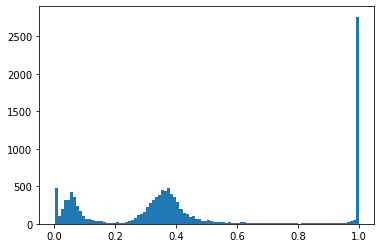

In [63]:
if __name__ == '__main__':
    main(train_df)

if CFG.epochs > 100:
    from IPython.display import clear_output  # セルの出力削除（1000epもログあると重すぎるので消す）
    clear_output()

In [64]:
#%debug

In [65]:
#=====

# Predict and submit

In [66]:
%reload_ext autoreload
%autoreload 2
from src import tta_util

In [67]:
@torch.inference_mode()  # pytorch >= 1.9
def inference(model, pth, test_loader, device, tta_transforms=None, tta_ops=[0]):
    if len(CFG.device_ids) > 1:
        model.load_state_dict(loadpth(pth))
    else:
        model.load_state_dict(torch.load(pth)['model'])
    model.eval().to(device)
    
    if len(CFG.device_ids) > 1:
        LOGGER.info(f"=> inference is_multiGPU {CFG.device_ids}")
        model = nn.DataParallel(model)  # make parallel
        cudnn.benchmark = True
    
    # ttach
    if tta_transforms is not None:
        model = tta.ClassificationTTAWrapper(model, tta_transforms)
    
    LOGGER.info(f"tta_ops: {str(tta_ops)}")
    preds = []
    preds2 = []  # for MultiOutput
    preds3 = []  # for MultiOutput2,3
    for i, (images, _, _,) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        outputs = None
        outputs2 = 0
        outputs3 = 0
        with torch.no_grad():
            
            for _ops in tta_ops:
                
                if "MultiOutput" in CFG.model_cls:
                    if (CFG.model_cls == "CustomModelMultiOutput2") or (CFG.model_cls == "CustomModelMultiOutput3"):
                        o, o2, o3 = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput2,3
                    else:
                        o, o2 = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput
                        o3 = 0
                else:
                    o = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput
                    o2, o3 = 0, 0
                
                if outputs is None:
                    outputs = o
                    outputs2 = o2
                    outputs3 = o3
                else:
                    outputs += o
                    outputs2 += o2
                    outputs3 += o3
        outputs /= len(tta_ops)
        outputs2 /= len(tta_ops)
        outputs3 /= len(tta_ops)
        
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        if "CustomModelMultiOutput" in CFG.model_cls:
            preds2.append(outputs2.argmax(1).cpu().detach().numpy())  # for MultiOutput
        if CFG.model_cls == "CustomModelMultiOutput2":
            preds3.append(outputs3.sigmoid().cpu().detach().numpy())  # for MultiOutput2
        elif CFG.model_cls == "CustomModelMultiOutput3":
            preds3.append(outputs3.argmax(1).cpu().detach().numpy())  # for MultiOutput3
    
    predictions = np.concatenate(preds)
    # for MultiOutput
    if len(preds2) == 0:
        predictions2 = None
    else:
        predictions2 = np.concatenate(preds2) 
    if len(preds3) == 0:
        predictions3 = None
    else:
        predictions3 = np.concatenate(preds3)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    #return predictions, predictions2
    return predictions, predictions2, predictions3  # for MultiOutput2,3

In [68]:
def main_test(test, pths, tta_transforms=None, transforms_type="valid", test_dataset=None, tta_ops=[0], is_cr=False):
    model = eval(CFG.model_cls)(CFG)
    if test_dataset is None:
        test_dataset = TrainDataset(test, 
                                    transforms=get_transforms(data=transforms_type),
                                    is_npy=CFG.is_npy,
                                    #add_ch_type=CFG.add_ch_type,
                                   )
    test_loader = DataLoader(test_dataset, 
                             batch_size=CFG.batch_size * 2, 
                             shuffle=False, 
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    predictions = None
    LOGGER.info(f'========== TEST ==========')  # for MultiOutput
    for i, pth in enumerate(pths):
        print("pth:", pth)
        
        #p, p2 = inference(model, pth, test_loader, device, tta_transforms, tta_ops=tta_ops)  # for MultiOutput
        p, p2, p3 = inference(model, pth, test_loader, device, tta_transforms, tta_ops=tta_ops)  # for MultiOutput2,3
        # 各foldの予測個別で持つ
        test[f'preds_fold{i}'] = p
        # for MultiOutput
        if "CustomModelMultiOutput" in CFG.model_cls:
            test[f'preds_freq_min//N_fold{i}'] = p2
            score2 = accuracy_score(test["freq_min//N"].to_numpy(), p2)
            LOGGER.info(f'freq_min//N {str(Path(pth).stem)} Accuracy: {score2:<.4f}')
            if is_cr:
                LOGGER.info(classification_report(test["freq_min//N"].to_numpy(), p2))
        if CFG.model_cls == "CustomModelMultiOutput2":
            test[f'preds_real_sim_fold{i}'] = p3
            score3 = get_score(test["real_sim"].to_numpy(), p3)
            LOGGER.info(f'real_sim {str(Path(pth).stem)} AUC: {score3:<.4f}')
        elif CFG.model_cls == "CustomModelMultiOutput3":
            test[f'preds_h0deg//10_fold{i}'] = p3
            #score3 = accuracy_score(test["h0deg//10"].to_numpy(), p3)  # testに h0deg//10 は無いのでコメントアウト
            #LOGGER.info(classification_report(test["h0deg//10"].to_numpy(), p3))  # testに h0deg//10 は無いのでコメントアウト
        
        if predictions is None:
            predictions = p
        else:
            predictions += p

    test['preds'] = predictions / len(pths)
    
    return test

In [69]:
# ttach param
# https://www.guruguru.science/competitions/17/discussions/4864ee81-6336-4cad-bb74-a4c9b46e6eb2/
tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip(),
        #tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180, 270]),  # 90度回転
        #tta.Scale(scales=[0.9, 1.1], interpolation="nearest"),  # 画像の大きさscales倍. h * scale_factor, w * scale_factor
        #tta.Add(values=[-1, 0, 1, 2]),  # 画素にfactorの値足す. x + value
        #tta.Multiply(factors=[0.9, 1, 1.1]),  # 画素をfactor倍. x * factor
        #tta.FiveCrops(crop_height=CFG.size//3, crop_width=CFG.size//3),  # 画像を5分割. crop_height: cropする画像の高さ. crop_width: cropする画像の幅
        #tta.Resize(sizes=[(224, 224), (384, 384)], original_size=(CFG.size, CFG.size), interpolation="nearest")  # 指定の大きさにリサイズ
    ]
)
tta_transforms = None

In [70]:
# ==========================================================
# valid inference
# ==========================================================
def _run_valid_tta(tta_ops):
    seed = CFG.seeds[0]
    valid = pd.read_csv(OUTPUT_DIR + f"/folds_seed{seed}.csv")

    # tta inference
    score_list = []
    pred_valid = pd.DataFrame()
    for fold in CFG.trn_fold:
        print(f"===== valid fold{fold} =====")

        # model pths
        pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_score.pth"))
        #pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_loss.pth"))
        print(pths)

        valid_f = valid[valid.fold == fold]
        print(valid_f.shape)

        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            transforms_type = 'valid_norm'
        else:
            transforms_type = 'valid'
        valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type, tta_ops=tta_ops, is_cr=False)

        ## =============================
        ## tta alb
        ## =============================
        #valid_f_tta1 = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
        #valid_f_tta1 = valid_f_tta1.rename(columns={"preds": "preds_tta1"})
        #
        #valid_f = pd.merge(valid_f, valid_f_tta1[["id", "preds_tta1"]], on="id")
        #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_tta1"].to_numpy()) / 2.0
        ## =============================

        ## =============================
        ## tta Dataset
        ## =============================
        #_test_dataset = TrainDataset(valid_f, 
        #                             transforms=get_transforms(data="valid"),
        #                             #prob_spec_start_random=1.0,
        #                             #prob_vshift=1.0,  # CV悪化
        #                             prob_swap_nega=1.0,  # CV悪化
        #                             is_npy=CFG.is_npy,
        #                             add_ch_type=CFG.add_ch_type,
        #                           )
        #valid_f_ttaD = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", test_dataset=_test_dataset)
        #valid_f_ttaD = valid_f_ttaD.rename(columns={"preds": "preds_ttaD"})
        #
        #valid_f = pd.merge(valid_f, valid_f_ttaD[["id", "preds_ttaD"]], on="id")
        #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_ttaD"].to_numpy()) / 2.0
        ## =============================

        score = get_result(valid_f, preds_col="preds", add_info=f"TTA fold{fold} ")
        score_list.append(score)
        pred_valid = pd.concat([pred_valid, valid_f])

    LOGGER.info(f"macro mean folds Score ± std: {str(round(np.mean(score_list), 4))} ± {str(round(np.std(score_list), 4))}")
    tta_oof_score = get_result(pred_valid, preds_col="preds", add_info=f"TTA oof ")
    pred_valid.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)
    display(pred_valid.head())

    #if CFG.is_wandb:
    #    # save log wandb
    #    wandb.log({f"TTA oof Score": tta_oof_score})

In [71]:
_run_valid_tta([0,1,2])
_run_valid_tta([0,1])
_run_valid_tta([0,2])
_run_valid_tta([0])
_run_valid_tta([0,8])
_run_valid_tta([0,1,2,8])

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:22<00:00,  1.19s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score Accuracy: 0.1911
TTA fold0 Score: 0.9147


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:22<00:00,  1.19s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score Accuracy: 0.1865
TTA fold1 Score: 0.9287


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:22<00:00,  1.17s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score Accuracy: 0.1761
TTA fold2 Score: 0.9183


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth']
(2396, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:22<00:00,  1.20s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score Accuracy: 0.1715
TTA fold3 Score: 0.9198


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth']
(2396, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:22<00:00,  1.18s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score Accuracy: 0.1657
TTA fold4 Score: 0.9090
macro mean folds Score ± std: 0.9181 ± 0.0065
TTA oof Score: 0.9176


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std    h1_max    l1_max    h1_min    l1_min  \
5   2.253793  0.400924  0.401087  4.411118  4.955837  0.966125  0.944580   
12  2.250381  0.398699  0.399798  4.495434  4.223328  0.950439  0.823746   
17  2.253459  0.403756  0.401150  4.522430  4.435623  0.918732  0.985977   
18  2.249809  0.401606  0.402489  4.646500  5.572067  1.014404  0.987701   
32  2.257342  0.408922  0.412729  5.706604  6.023422  0.976700  1.003143   

    freq_min//N  h1_l1_mean  h1_l1_std  fold  sqrtSX  F0 type dir_name  F1  \
5           6.0    4.506183   0.802011     0     NaN NaN  NaN      NaN NaN   
12          9.0    4.497386   0.798497     0     NaN NaN  NaN      NaN NaN   
17          1.0    4.504227   0.804906     0     NaN NaN  NaN      NaN NaN   
18          1.0    4.506121   0.804095     0     NaN NaN  NaN      NaN NaN   
32          9.0    4.514927   0.821651     0     NaN NaN  NaN      NaN NaN   

    h0deg  h1_minstd  h1_maxstd  h1_stddiff  l1_minstd  l1_maxstd  l1_stddiff  \
5     NaN        NaN        NaN         NaN        NaN        NaN         NaN   
12    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
17    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
18    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
32    NaN        NaN        NaN         NaN        NaN        NaN         NaN   

    h1_max/l1_max  real_sim  preds_fold0  preds_freq_min//N_fold0     preds  
5             NaN       NaN     0.995816                        5  0.995816  
12            NaN       NaN     0.200758                        6  0.200758  
17            NaN       NaN     0.999488                        1  0.999488  
18            NaN       NaN     0.997258                        1  0.997258  
32            NaN       NaN     0.999826                        8  0.999826

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score Accuracy: 0.1927
TTA fold0 Score: 0.9136


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score Accuracy: 0.1869
TTA fold1 Score: 0.9286


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.25it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score Accuracy: 0.1794
TTA fold2 Score: 0.9170


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth']
(2396, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score Accuracy: 0.1711
TTA fold3 Score: 0.9201


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth']
(2396, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.25it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score Accuracy: 0.1619
TTA fold4 Score: 0.9108
macro mean folds Score ± std: 0.918 ± 0.0062
TTA oof Score: 0.9173


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std    h1_max    l1_max    h1_min    l1_min  \
5   2.253793  0.400924  0.401087  4.411118  4.955837  0.966125  0.944580   
12  2.250381  0.398699  0.399798  4.495434  4.223328  0.950439  0.823746   
17  2.253459  0.403756  0.401150  4.522430  4.435623  0.918732  0.985977   
18  2.249809  0.401606  0.402489  4.646500  5.572067  1.014404  0.987701   
32  2.257342  0.408922  0.412729  5.706604  6.023422  0.976700  1.003143   

    freq_min//N  h1_l1_mean  h1_l1_std  fold  sqrtSX  F0 type dir_name  F1  \
5           6.0    4.506183   0.802011     0     NaN NaN  NaN      NaN NaN   
12          9.0    4.497386   0.798497     0     NaN NaN  NaN      NaN NaN   
17          1.0    4.504227   0.804906     0     NaN NaN  NaN      NaN NaN   
18          1.0    4.506121   0.804095     0     NaN NaN  NaN      NaN NaN   
32          9.0    4.514927   0.821651     0     NaN NaN  NaN      NaN NaN   

    h0deg  h1_minstd  h1_maxstd  h1_stddiff  l1_minstd  l1_maxstd  l1_stddiff  \
5     NaN        NaN        NaN         NaN        NaN        NaN         NaN   
12    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
17    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
18    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
32    NaN        NaN        NaN         NaN        NaN        NaN         NaN   

    h1_max/l1_max  real_sim  preds_fold0  preds_freq_min//N_fold0     preds  
5             NaN       NaN     0.994821                        5  0.994821  
12            NaN       NaN     0.198837                        6  0.198837  
17            NaN       NaN     0.999510                        1  0.999510  
18            NaN       NaN     0.997733                        1  0.997733  
32            NaN       NaN     0.999748                        8  0.999748

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.25it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score Accuracy: 0.1902
TTA fold0 Score: 0.9153


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.25it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score Accuracy: 0.1806
TTA fold1 Score: 0.9282


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score Accuracy: 0.1736
TTA fold2 Score: 0.9204


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth']
(2396, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score Accuracy: 0.1732
TTA fold3 Score: 0.9182


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth']
(2396, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score Accuracy: 0.1686
TTA fold4 Score: 0.9088
macro mean folds Score ± std: 0.9182 ± 0.0064
TTA oof Score: 0.9177


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std    h1_max    l1_max    h1_min    l1_min  \
5   2.253793  0.400924  0.401087  4.411118  4.955837  0.966125  0.944580   
12  2.250381  0.398699  0.399798  4.495434  4.223328  0.950439  0.823746   
17  2.253459  0.403756  0.401150  4.522430  4.435623  0.918732  0.985977   
18  2.249809  0.401606  0.402489  4.646500  5.572067  1.014404  0.987701   
32  2.257342  0.408922  0.412729  5.706604  6.023422  0.976700  1.003143   

    freq_min//N  h1_l1_mean  h1_l1_std  fold  sqrtSX  F0 type dir_name  F1  \
5           6.0    4.506183   0.802011     0     NaN NaN  NaN      NaN NaN   
12          9.0    4.497386   0.798497     0     NaN NaN  NaN      NaN NaN   
17          1.0    4.504227   0.804906     0     NaN NaN  NaN      NaN NaN   
18          1.0    4.506121   0.804095     0     NaN NaN  NaN      NaN NaN   
32          9.0    4.514927   0.821651     0     NaN NaN  NaN      NaN NaN   

    h0deg  h1_minstd  h1_maxstd  h1_stddiff  l1_minstd  l1_maxstd  l1_stddiff  \
5     NaN        NaN        NaN         NaN        NaN        NaN         NaN   
12    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
17    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
18    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
32    NaN        NaN        NaN         NaN        NaN        NaN         NaN   

    h1_max/l1_max  real_sim  preds_fold0  preds_freq_min//N_fold0     preds  
5             NaN       NaN     0.996633                        5  0.996633  
12            NaN       NaN     0.203607                        6  0.203607  
17            NaN       NaN     0.999466                        1  0.999466  
18            NaN       NaN     0.997425                        1  0.997425  
32            NaN       NaN     0.999859                        8  0.999859

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:08<00:00,  2.34it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score Accuracy: 0.1852
TTA fold0 Score: 0.9139


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:07<00:00,  2.42it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score Accuracy: 0.1815
TTA fold1 Score: 0.9283


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:07<00:00,  2.42it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score Accuracy: 0.1681
TTA fold2 Score: 0.9202


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth']
(2396, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:07<00:00,  2.44it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score Accuracy: 0.1649
TTA fold3 Score: 0.9177


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth']
(2396, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:07<00:00,  2.41it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score Accuracy: 0.1674
TTA fold4 Score: 0.9120
macro mean folds Score ± std: 0.9184 ± 0.0057
TTA oof Score: 0.9176


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std    h1_max    l1_max    h1_min    l1_min  \
5   2.253793  0.400924  0.401087  4.411118  4.955837  0.966125  0.944580   
12  2.250381  0.398699  0.399798  4.495434  4.223328  0.950439  0.823746   
17  2.253459  0.403756  0.401150  4.522430  4.435623  0.918732  0.985977   
18  2.249809  0.401606  0.402489  4.646500  5.572067  1.014404  0.987701   
32  2.257342  0.408922  0.412729  5.706604  6.023422  0.976700  1.003143   

    freq_min//N  h1_l1_mean  h1_l1_std  fold  sqrtSX  F0 type dir_name  F1  \
5           6.0    4.506183   0.802011     0     NaN NaN  NaN      NaN NaN   
12          9.0    4.497386   0.798497     0     NaN NaN  NaN      NaN NaN   
17          1.0    4.504227   0.804906     0     NaN NaN  NaN      NaN NaN   
18          1.0    4.506121   0.804095     0     NaN NaN  NaN      NaN NaN   
32          9.0    4.514927   0.821651     0     NaN NaN  NaN      NaN NaN   

    h0deg  h1_minstd  h1_maxstd  h1_stddiff  l1_minstd  l1_maxstd  l1_stddiff  \
5     NaN        NaN        NaN         NaN        NaN        NaN         NaN   
12    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
17    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
18    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
32    NaN        NaN        NaN         NaN        NaN        NaN         NaN   

    h1_max/l1_max  real_sim  preds_fold0  preds_freq_min//N_fold0     preds  
5             NaN       NaN     0.995846                        5  0.995846  
12            NaN       NaN     0.202578                        6  0.202578  
17            NaN       NaN     0.999491                        1  0.999491  
18            NaN       NaN     0.998348                        1  0.998348  
32            NaN       NaN     0.999760                        8  0.999760

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth


tta_ops: [0, 8]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score Accuracy: 0.1752
TTA fold0 Score: 0.9135


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth


tta_ops: [0, 8]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.27it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score Accuracy: 0.1723
TTA fold1 Score: 0.9265


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth


tta_ops: [0, 8]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.25it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score Accuracy: 0.1673
TTA fold2 Score: 0.9189


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth']
(2396, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth


tta_ops: [0, 8]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.25it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score Accuracy: 0.1682
TTA fold3 Score: 0.9180


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth']
(2396, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth


tta_ops: [0, 8]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.25it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score Accuracy: 0.1536
TTA fold4 Score: 0.9105
macro mean folds Score ± std: 0.9175 ± 0.0054
TTA oof Score: 0.9168


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std    h1_max    l1_max    h1_min    l1_min  \
5   2.253793  0.400924  0.401087  4.411118  4.955837  0.966125  0.944580   
12  2.250381  0.398699  0.399798  4.495434  4.223328  0.950439  0.823746   
17  2.253459  0.403756  0.401150  4.522430  4.435623  0.918732  0.985977   
18  2.249809  0.401606  0.402489  4.646500  5.572067  1.014404  0.987701   
32  2.257342  0.408922  0.412729  5.706604  6.023422  0.976700  1.003143   

    freq_min//N  h1_l1_mean  h1_l1_std  fold  sqrtSX  F0 type dir_name  F1  \
5           6.0    4.506183   0.802011     0     NaN NaN  NaN      NaN NaN   
12          9.0    4.497386   0.798497     0     NaN NaN  NaN      NaN NaN   
17          1.0    4.504227   0.804906     0     NaN NaN  NaN      NaN NaN   
18          1.0    4.506121   0.804095     0     NaN NaN  NaN      NaN NaN   
32          9.0    4.514927   0.821651     0     NaN NaN  NaN      NaN NaN   

    h0deg  h1_minstd  h1_maxstd  h1_stddiff  l1_minstd  l1_maxstd  l1_stddiff  \
5     NaN        NaN        NaN         NaN        NaN        NaN         NaN   
12    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
17    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
18    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
32    NaN        NaN        NaN         NaN        NaN        NaN         NaN   

    h1_max/l1_max  real_sim  preds_fold0  preds_freq_min//N_fold0     preds  
5             NaN       NaN     0.996027                        5  0.996027  
12            NaN       NaN     0.191058                        6  0.191058  
17            NaN       NaN     0.999524                        1  0.999524  
18            NaN       NaN     0.998619                        2  0.998619  
32            NaN       NaN     0.999632                        8  0.999632

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:29<00:00,  1.57s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score Accuracy: 0.1869
TTA fold0 Score: 0.9146


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:29<00:00,  1.56s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score Accuracy: 0.1823
TTA fold1 Score: 0.9279


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth']
(2397, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:29<00:00,  1.56s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score Accuracy: 0.1769
TTA fold2 Score: 0.9189


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth']
(2396, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:29<00:00,  1.56s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score Accuracy: 0.1770
TTA fold3 Score: 0.9193


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth']
(2396, 44)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:29<00:00,  1.56s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score Accuracy: 0.1653
TTA fold4 Score: 0.9091
macro mean folds Score ± std: 0.918 ± 0.0062
TTA oof Score: 0.9176


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std    h1_max    l1_max    h1_min    l1_min  \
5   2.253793  0.400924  0.401087  4.411118  4.955837  0.966125  0.944580   
12  2.250381  0.398699  0.399798  4.495434  4.223328  0.950439  0.823746   
17  2.253459  0.403756  0.401150  4.522430  4.435623  0.918732  0.985977   
18  2.249809  0.401606  0.402489  4.646500  5.572067  1.014404  0.987701   
32  2.257342  0.408922  0.412729  5.706604  6.023422  0.976700  1.003143   

    freq_min//N  h1_l1_mean  h1_l1_std  fold  sqrtSX  F0 type dir_name  F1  \
5           6.0    4.506183   0.802011     0     NaN NaN  NaN      NaN NaN   
12          9.0    4.497386   0.798497     0     NaN NaN  NaN      NaN NaN   
17          1.0    4.504227   0.804906     0     NaN NaN  NaN      NaN NaN   
18          1.0    4.506121   0.804095     0     NaN NaN  NaN      NaN NaN   
32          9.0    4.514927   0.821651     0     NaN NaN  NaN      NaN NaN   

    h0deg  h1_minstd  h1_maxstd  h1_stddiff  l1_minstd  l1_maxstd  l1_stddiff  \
5     NaN        NaN        NaN         NaN        NaN        NaN         NaN   
12    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
17    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
18    NaN        NaN        NaN         NaN        NaN        NaN         NaN   
32    NaN        NaN        NaN         NaN        NaN        NaN         NaN   

    h1_max/l1_max  real_sim  preds_fold0  preds_freq_min//N_fold0     preds  
5             NaN       NaN     0.995916                        5  0.995916  
12            NaN       NaN     0.195418                        6  0.195418  
17            NaN       NaN     0.999505                        1  0.999505  
18            NaN       NaN     0.997790                        2  0.997790  
32            NaN       NaN     0.999767                        8  0.999767

In [72]:
#%debug

In [73]:
#=====

In [74]:
def _run_test_tta(tta_ops):
    if IS_MAKE_SUB:
        # model pths
        pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
        #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
        print(pths)

        # 'h0deg//10'列無いとエラーになるので入れとく
        test_df['h0deg//10'] = 0

        # ==========================================================
        # test inference
        # ==========================================================
        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            transforms_type = 'valid_norm'
        else:
            transforms_type = 'valid'
        #submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type)
        submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type, tta_ops=tta_ops)

        ## =============================
        ## tta alb
        ## =============================
        #submit_tta1 = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
        #submit_tta1 = submit_tta1.rename(columns={"preds": "preds_tta1"})
        #
        #submit = pd.merge(submit, submit_tta1[["id", "preds_tta1"]], on="id")
        #submit["preds"] = (submit["preds"].to_numpy() + submit["preds_tta1"].to_numpy()) / 2.0
        ## =============================

        submit["target"] = submit["preds"].to_numpy()
        display(submit.head())
        submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)

        submit = submit[["id", "target"]]
        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))

        # Write prediction
        submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_submission_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)
        display(submit)

        plt.hist(submit["target"], bins=100)
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [01:13<00:00,  1.17s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score Accuracy: 0.2015


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [01:13<00:00,  1.17s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score Accuracy: 0.1976


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [01:13<00:00,  1.17s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score Accuracy: 0.1941


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [01:13<00:00,  1.17s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score Accuracy: 0.2018


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [01:13<00:00,  1.17s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score Accuracy: 0.1812


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.304826   
1  1.248537e+09         42746.0  0.552492   
2  1.248567e+09         55878.0  0.267893   
3  1.248537e+09         48020.0  0.745487   
4  1.248543e+09         45246.0  0.873052   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std    h1_max    l1_max    h1_min  \
0  2.251338  2.247327  0.397542  0.397476  4.292206  4.231491  0.954292   
1  2.250531  2.253083  0.399520  0.399918  4.516495  4.229019  1.000900   
2  2.249787  2.250360  0.399082  0.401004  4.529892  4.876816  0.912964   
3  2.251309  2.250812  0.399954  0.399532  4.189644  4.518730  1.041290   
4  2.250533  2.250065  0.402394  0.400455  4.381638  4.307745  0.955505   

     l1_min     h1_minstd     h1_maxstd  h1_stddiff     l1_minstd  \
0  1.010231  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
1  0.952278  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
2  0.956436  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
3  0.947411  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
4  0.920578  1.058791e-22  1.058791e-22         0.0  1.058791e-22   

      l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  freq_min//N  h1_l1_mean  \
0  1.058791e-22         0.0       1.085967         0          6.0    4.498665   
1  1.058791e-22         0.0       0.971284         0          2.0    4.503615   
2  1.058791e-22         0.0       1.037622         0          3.0    4.500148   
3  1.058791e-22         0.0       1.025819         0          1.0    4.502120   
4  1.058791e-22         0.0       0.976649         0          9.0    4.500598   

   h1_l1_std  h0deg//10  preds_fold0  preds_freq_min//N_fold0  preds_fold1  \
0   0.795017          0     0.299416                        6     0.357132   
1   0.799438          0     0.387747                        6     0.544831   
2   0.800086          0     0.247750                        6     0.368039   
3   0.799486          0     0.704948                        2     0.935600   
4   0.802849          0     0.860991                        1     0.954694   

   preds_freq_min//N_fold1  preds_fold2  preds_freq_min//N_fold2  preds_fold3  \
0                        7     0.211353                        3     0.340731   
1                        7     0.674273                        1     0.508636   
2                        4     0.086116                        3     0.321374   
3                        2     0.361794                        2     0.933441   
4                        2     0.805557                        1     0.962845   

   preds_freq_min//N_fold3  preds_fold4  preds_freq_min//N_fold4     preds  
0           

target range [0.129587, 0.999930]


id    target
0     00054c878  0.304826
1     0007285a3  0.552492
2     00076c5a6  0.267893
3     001349290  0.745487
4     001a52e92  0.873052
...         ...       ...
7970  ffbce04ef  0.992561
7971  ffc2d976b  0.254064
7972  ffc905909  0.282531
7973  ffe276f3e  0.288868
7974  fffa17f67  0.231765

[7975 rows x 2 columns]

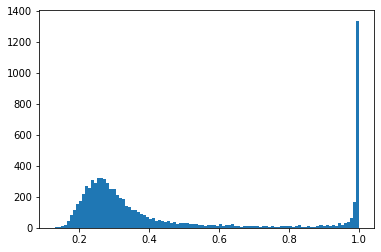

['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.26it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score Accuracy: 0.2011


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score Accuracy: 0.1984


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score Accuracy: 0.1930


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score Accuracy: 0.2028


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth


tta_ops: [0, 1]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score Accuracy: 0.1777


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.313974   
1  1.248537e+09         42746.0  0.554663   
2  1.248567e+09         55878.0  0.266133   
3  1.248537e+09         48020.0  0.714594   
4  1.248543e+09         45246.0  0.885038   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std    h1_max    l1_max    h1_min  \
0  2.251338  2.247327  0.397542  0.397476  4.292206  4.231491  0.954292   
1  2.250531  2.253083  0.399520  0.399918  4.516495  4.229019  1.000900   
2  2.249787  2.250360  0.399082  0.401004  4.529892  4.876816  0.912964   
3  2.251309  2.250812  0.399954  0.399532  4.189644  4.518730  1.041290   
4  2.250533  2.250065  0.402394  0.400455  4.381638  4.307745  0.955505   

     l1_min     h1_minstd     h1_maxstd  h1_stddiff     l1_minstd  \
0  1.010231  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
1  0.952278  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
2  0.956436  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
3  0.947411  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
4  0.920578  1.058791e-22  1.058791e-22         0.0  1.058791e-22   

      l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  freq_min//N  h1_l1_mean  \
0  1.058791e-22         0.0       1.085967         0          6.0    4.498665   
1  1.058791e-22         0.0       0.971284         0          2.0    4.503615   
2  1.058791e-22         0.0       1.037622         0          3.0    4.500148   
3  1.058791e-22         0.0       1.025819         0          1.0    4.502120   
4  1.058791e-22         0.0       0.976649         0          9.0    4.500598   

   h1_l1_std  h0deg//10  preds_fold0  preds_freq_min//N_fold0  preds_fold1  \
0   0.795017          0     0.301190                        7     0.361746   
1   0.799438          0     0.347062                        6     0.539013   
2   0.800086          0     0.252971                        6     0.372880   
3   0.799486          0     0.639531                        2     0.906749   
4   0.802849          0     0.901588                        1     0.957500   

   preds_freq_min//N_fold1  preds_fold2  preds_freq_min//N_fold2  preds_fold3  \
0                        7     0.242710                        3     0.341528   
1                        7     0.664734                        1     0.505449   
2                        7     0.087110                        3     0.323548   
3                        2     0.368832                        2     0.922026   
4                        2     0.728240                        2     0.971051   

   preds_freq_min//N_fold3  preds_fold4  preds_freq_min//N_fold4     preds  
0           

target range [0.129719, 0.999916]


id    target
0     00054c878  0.313974
1     0007285a3  0.554663
2     00076c5a6  0.266133
3     001349290  0.714594
4     001a52e92  0.885038
...         ...       ...
7970  ffbce04ef  0.992478
7971  ffc2d976b  0.252923
7972  ffc905909  0.294176
7973  ffe276f3e  0.283556
7974  fffa17f67  0.235336

[7975 rows x 2 columns]

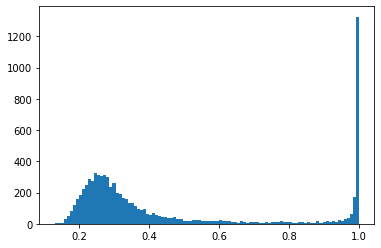

['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score Accuracy: 0.2046


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score Accuracy: 0.1971


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.28it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score Accuracy: 0.1957


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.28it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score Accuracy: 0.2044


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth


tta_ops: [0, 2]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score Accuracy: 0.1794


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.295645   
1  1.248537e+09         42746.0  0.545114   
2  1.248567e+09         55878.0  0.273748   
3  1.248537e+09         48020.0  0.760169   
4  1.248543e+09         45246.0  0.875466   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std    h1_max    l1_max    h1_min  \
0  2.251338  2.247327  0.397542  0.397476  4.292206  4.231491  0.954292   
1  2.250531  2.253083  0.399520  0.399918  4.516495  4.229019  1.000900   
2  2.249787  2.250360  0.399082  0.401004  4.529892  4.876816  0.912964   
3  2.251309  2.250812  0.399954  0.399532  4.189644  4.518730  1.041290   
4  2.250533  2.250065  0.402394  0.400455  4.381638  4.307745  0.955505   

     l1_min     h1_minstd     h1_maxstd  h1_stddiff     l1_minstd  \
0  1.010231  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
1  0.952278  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
2  0.956436  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
3  0.947411  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
4  0.920578  1.058791e-22  1.058791e-22         0.0  1.058791e-22   

      l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  freq_min//N  h1_l1_mean  \
0  1.058791e-22         0.0       1.085967         0          6.0    4.498665   
1  1.058791e-22         0.0       0.971284         0          2.0    4.503615   
2  1.058791e-22         0.0       1.037622         0          3.0    4.500148   
3  1.058791e-22         0.0       1.025819         0          1.0    4.502120   
4  1.058791e-22         0.0       0.976649         0          9.0    4.500598   

   h1_l1_std  h0deg//10  preds_fold0  preds_freq_min//N_fold0  preds_fold1  \
0   0.795017          0     0.287864                        6     0.353721   
1   0.799438          0     0.410971                        6     0.545296   
2   0.800086          0     0.251667                        6     0.376617   
3   0.799486          0     0.755961                        2     0.946124   
4   0.802849          0     0.771751                        1     0.961884   

   preds_freq_min//N_fold1  preds_fold2  preds_freq_min//N_fold2  preds_fold3  \
0                        7     0.185530                        3     0.339507   
1                        4     0.626814                        1     0.490164   
2                        3     0.084753                        3     0.326517   
3                        2     0.389106                        2     0.935717   
4                        2     0.885917                        1     0.962701   

   preds_freq_min//N_fold3  preds_fold4  preds_freq_min//N_fold4     preds  
0           

target range [0.127684, 0.999941]


id    target
0     00054c878  0.295645
1     0007285a3  0.545114
2     00076c5a6  0.273748
3     001349290  0.760169
4     001a52e92  0.875466
...         ...       ...
7970  ffbce04ef  0.992108
7971  ffc2d976b  0.255776
7972  ffc905909  0.247678
7973  ffe276f3e  0.279655
7974  fffa17f67  0.235394

[7975 rows x 2 columns]

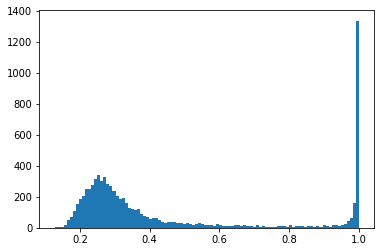

['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.50it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score Accuracy: 0.2006


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.51it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score Accuracy: 0.1929


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:24<00:00,  2.53it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score Accuracy: 0.1900


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.48it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score Accuracy: 0.2013


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth


tta_ops: [0]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.49it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score Accuracy: 0.1724


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.303649   
1  1.248537e+09         42746.0  0.538475   
2  1.248567e+09         55878.0  0.276054   
3  1.248537e+09         48020.0  0.712859   
4  1.248543e+09         45246.0  0.908610   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std    h1_max    l1_max    h1_min  \
0  2.251338  2.247327  0.397542  0.397476  4.292206  4.231491  0.954292   
1  2.250531  2.253083  0.399520  0.399918  4.516495  4.229019  1.000900   
2  2.249787  2.250360  0.399082  0.401004  4.529892  4.876816  0.912964   
3  2.251309  2.250812  0.399954  0.399532  4.189644  4.518730  1.041290   
4  2.250533  2.250065  0.402394  0.400455  4.381638  4.307745  0.955505   

     l1_min     h1_minstd     h1_maxstd  h1_stddiff     l1_minstd  \
0  1.010231  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
1  0.952278  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
2  0.956436  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
3  0.947411  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
4  0.920578  1.058791e-22  1.058791e-22         0.0  1.058791e-22   

      l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  freq_min//N  h1_l1_mean  \
0  1.058791e-22         0.0       1.085967         0          6.0    4.498665   
1  1.058791e-22         0.0       0.971284         0          2.0    4.503615   
2  1.058791e-22         0.0       1.037622         0          3.0    4.500148   
3  1.058791e-22         0.0       1.025819         0          1.0    4.502120   
4  1.058791e-22         0.0       0.976649         0          9.0    4.500598   

   h1_l1_std  h0deg//10  preds_fold0  preds_freq_min//N_fold0  preds_fold1  \
0   0.795017          0     0.279974                        6     0.359502   
1   0.799438          0     0.351266                        6     0.534118   
2   0.800086          0     0.266354                        6     0.395152   
3   0.799486          0     0.688919                        2     0.904846   
4   0.802849          0     0.801520                        1     0.971868   

   preds_freq_min//N_fold1  preds_fold2  preds_freq_min//N_fold2  preds_fold3  \
0                        7     0.216865                        3     0.339874   
1                        7     0.555607                        1     0.465368   
2                        4     0.085352                        3     0.336128   
3                        2     0.431964                        2     0.914830   
4                        2     0.858953                        2     0.977308   

   preds_freq_min//N_fold3  preds_fold4  preds_freq_min//N_fold4     preds  
0           

target range [0.126093, 0.999931]


id    target
0     00054c878  0.303649
1     0007285a3  0.538475
2     00076c5a6  0.276054
3     001349290  0.712859
4     001a52e92  0.908610
...         ...       ...
7970  ffbce04ef  0.990598
7971  ffc2d976b  0.255416
7972  ffc905909  0.235321
7973  ffe276f3e  0.260816
7974  fffa17f67  0.246537

[7975 rows x 2 columns]

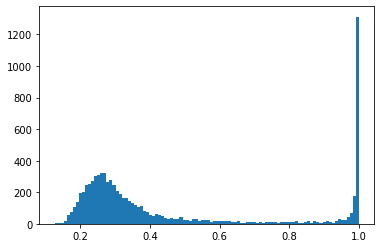

['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth


tta_ops: [0, 8]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.28it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score Accuracy: 0.1972


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth


tta_ops: [0, 8]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score Accuracy: 0.1906


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth


tta_ops: [0, 8]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.28it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score Accuracy: 0.1819


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth


tta_ops: [0, 8]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.27it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score Accuracy: 0.1931


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth


tta_ops: [0, 8]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:49<00:00,  1.28it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score Accuracy: 0.1673


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.301338   
1  1.248537e+09         42746.0  0.710343   
2  1.248567e+09         55878.0  0.267889   
3  1.248537e+09         48020.0  0.702648   
4  1.248543e+09         45246.0  0.844713   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std    h1_max    l1_max    h1_min  \
0  2.251338  2.247327  0.397542  0.397476  4.292206  4.231491  0.954292   
1  2.250531  2.253083  0.399520  0.399918  4.516495  4.229019  1.000900   
2  2.249787  2.250360  0.399082  0.401004  4.529892  4.876816  0.912964   
3  2.251309  2.250812  0.399954  0.399532  4.189644  4.518730  1.041290   
4  2.250533  2.250065  0.402394  0.400455  4.381638  4.307745  0.955505   

     l1_min     h1_minstd     h1_maxstd  h1_stddiff     l1_minstd  \
0  1.010231  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
1  0.952278  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
2  0.956436  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
3  0.947411  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
4  0.920578  1.058791e-22  1.058791e-22         0.0  1.058791e-22   

      l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  freq_min//N  h1_l1_mean  \
0  1.058791e-22         0.0       1.085967         0          6.0    4.498665   
1  1.058791e-22         0.0       0.971284         0          2.0    4.503615   
2  1.058791e-22         0.0       1.037622         0          3.0    4.500148   
3  1.058791e-22         0.0       1.025819         0          1.0    4.502120   
4  1.058791e-22         0.0       0.976649         0          9.0    4.500598   

   h1_l1_std  h0deg//10  preds_fold0  preds_freq_min//N_fold0  preds_fold1  \
0   0.795017          0     0.264420                        6     0.363165   
1   0.799438          0     0.691569                        1     0.759201   
2   0.800086          0     0.225196                        6     0.384814   
3   0.799486          0     0.685438                        2     0.923097   
4   0.802849          0     0.614953                        2     0.953484   

   preds_freq_min//N_fold1  preds_fold2  preds_freq_min//N_fold2  preds_fold3  \
0                        7     0.204261                        3     0.339851   
1                        2     0.722367                        1     0.704103   
2                        4     0.090912                        3     0.322617   
3                        2     0.435422                        1     0.915390   
4                        2     0.799604                        2     0.958154   

   preds_freq_min//N_fold3  preds_fold4  preds_freq_min//N_fold4     preds  
0           

target range [0.123656, 0.999955]


id    target
0     00054c878  0.301338
1     0007285a3  0.710343
2     00076c5a6  0.267889
3     001349290  0.702648
4     001a52e92  0.844713
...         ...       ...
7970  ffbce04ef  0.991654
7971  ffc2d976b  0.259887
7972  ffc905909  0.250136
7973  ffe276f3e  0.247224
7974  fffa17f67  0.267240

[7975 rows x 2 columns]

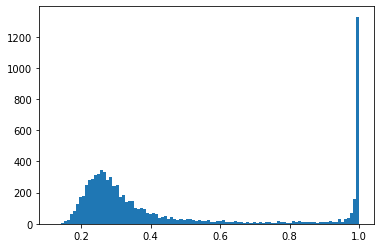

['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [01:38<00:00,  1.56s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold0_seed0_best_score Accuracy: 0.2004


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|███████████████████████████████████████████████████████████████████████| 63/63 [01:38<00:00,  1.56s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold1_seed0_best_score Accuracy: 0.1929


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|███████████████████████████████████████████| 63/63 [01:37<00:00,  1.55s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold2_seed0_best_score Accuracy: 0.1911


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:39<00:00,  1.57s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold3_seed0_best_score Accuracy: 0.2031


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:38<00:00,  1.57s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_3_GN_fold4_seed0_best_score Accuracy: 0.1759


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.303281   
1  1.248537e+09         42746.0  0.636533   
2  1.248567e+09         55878.0  0.265900   
3  1.248537e+09         48020.0  0.734643   
4  1.248543e+09         45246.0  0.853452   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std    h1_max    l1_max    h1_min  \
0  2.251338  2.247327  0.397542  0.397476  4.292206  4.231491  0.954292   
1  2.250531  2.253083  0.399520  0.399918  4.516495  4.229019  1.000900   
2  2.249787  2.250360  0.399082  0.401004  4.529892  4.876816  0.912964   
3  2.251309  2.250812  0.399954  0.399532  4.189644  4.518730  1.041290   
4  2.250533  2.250065  0.402394  0.400455  4.381638  4.307745  0.955505   

     l1_min     h1_minstd     h1_maxstd  h1_stddiff     l1_minstd  \
0  1.010231  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
1  0.952278  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
2  0.956436  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
3  0.947411  1.058791e-22  1.058791e-22         0.0  1.058791e-22   
4  0.920578  1.058791e-22  1.058791e-22         0.0  1.058791e-22   

      l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  freq_min//N  h1_l1_mean  \
0  1.058791e-22         0.0       1.085967         0          6.0    4.498665   
1  1.058791e-22         0.0       0.971284         0          2.0    4.503615   
2  1.058791e-22         0.0       1.037622         0          3.0    4.500148   
3  1.058791e-22         0.0       1.025819         0          1.0    4.502120   
4  1.058791e-22         0.0       0.976649         0          9.0    4.500598   

   h1_l1_std  h0deg//10  preds_fold0  preds_freq_min//N_fold0  preds_fold1  \
0   0.795017          0     0.286392                        6     0.359549   
1   0.799438          0     0.553422                        1     0.662585   
2   0.800086          0     0.231919                        6     0.369669   
3   0.799486          0     0.699286                        2     0.936230   
4   0.802849          0     0.777783                        1     0.948365   

   preds_freq_min//N_fold1  preds_fold2  preds_freq_min//N_fold2  preds_fold3  \
0                        7     0.206440                        3     0.340505   
1                        3     0.724713                        1     0.621061   
2                        4     0.088681                        3     0.318357   
3                        2     0.380574                        2     0.929414   
4                        2     0.786894                        1     0.955465   

   preds_freq_min//N_fold3  preds_fold4  preds_freq_min//N_fold4     preds  
0           

target range [0.127470, 0.999945]


id    target
0     00054c878  0.303281
1     0007285a3  0.636533
2     00076c5a6  0.265900
3     001349290  0.734643
4     001a52e92  0.853452
...         ...       ...
7970  ffbce04ef  0.992914
7971  ffc2d976b  0.256425
7972  ffc905909  0.278128
7973  ffe276f3e  0.274299
7974  fffa17f67  0.244967

[7975 rows x 2 columns]

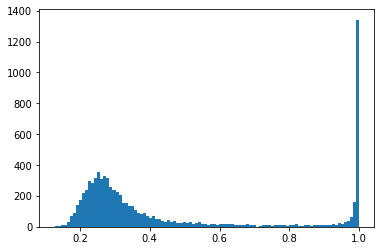

In [75]:
_run_test_tta([0,1,2])
_run_test_tta([0,1])
_run_test_tta([0,2])
_run_test_tta([0])
_run_test_tta([0,8])
_run_test_tta([0,1,2,8])

In [76]:
if CFG.is_wandb:
    wandb.finish()

In [77]:
## submitファイル連結
#if IS_MAKE_SUB:
#    
#    # シュミレーションデータのsubmitファイル
#    _name = CFG.name.replace("_real", "_sim")
#    sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_submission.csv'
#    
#    if os.path.isfile(sim_csv):
#        submit_real = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv')
#        submit_sim = pd.read_csv(sim_csv)
#        submit = pd.concat([submit_sim, submit_real])
#        
#        # 行の順番をtest_dfの順番にする
#        test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
#        submit = pd.merge(test_df[["id"]], submit, on="id")
#        
#        submit = submit[["id", "target"]]
#        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))
#
#        # Write prediction
#        submit.to_csv(OUTPUT_DIR + f'/{CFG.name.split("_real")[0]}_sim_real_submission.csv', index=False)
#        display(submit)
#
#        plt.hist(submit["target"], bins=100)
#        plt.show()
#        plt.clf()  # メモリ解放
#        plt.close()

# Stacking

In [78]:
#### stacking用にtest set全体で推論
#test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
#test_df["target"] = 0.5
#if cfg_is_npy:
#    test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
#else:
#    test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
#    
#if IS_MAKE_SUB:
#    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
#    
#    if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
#        transforms_type = 'valid_norm'
#    else:
#        transforms_type = 'valid'
#    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type)
#
#    submit["target"] = submit["preds"].to_numpy()
#    display(submit.head())
#    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv', index=False)

In [79]:
import joblib
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


def table_train_fn(df, feature_cols, target_col, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    lgb_params = {
            "objective": "binary",
            "learning_rate": 0.03,
            "n_estimators": 100_000,
        }
    
    Y_pred = np.zeros((len(df)))

    for i in tqdm(CFG.seeds):
        print(f"------------ seed:{i} ------------")
        set_seed(seed=i)
        folds = df.copy()

        for j in range(CFG.n_fold):
            print(f"------------ fold:{j} ------------")

            train = folds[folds["fold"] != j]
            val = folds[folds["fold"] == j]
            val_idx = val.index
            
            X_train, X_val = train[feature_cols], val[feature_cols]
            y_train, y_val = train[target_col], val[target_col]
            X_train, X_val = X_train.values, X_val.values
            y_train, y_val = y_train.values, y_val.values

            ### lgb.LGBMClassifier
            #model = lgb.LGBMClassifier(random_state=i, **lgb_params)
            #model.fit(X_train, y_train,
            #          eval_set=[(X_val, y_val)],
            #          eval_metric="error",
            #          early_stopping_rounds=100,
            #          verbose=-1,
            #         )
            
            ### RandomForestClassifier
            #model = RandomForestClassifier(random_state=i)
            #model = model.fit(X_train, y_train)
            
            ### LogisticRegression
            model = LogisticRegression(random_state=i)
            model = model.fit(X_train, y_train)
            
            pred = model.predict_proba(X_val) / len(CFG.seeds)
            Y_pred[val_idx] += pred[:,1]
            
            joblib.dump(model, out_dir + f"/model_seed_{i}_fold_{j}_{target_col}.jlb", compress=True)

    folds["pred"] = Y_pred
    print("oof score:", get_score(folds[target_col].values, folds["pred"].values))
    
    folds.to_csv(out_dir + f"/{target_col}_oof.csv", index=False)
    
    return folds

def table_test_fn(df, feature_cols, target_col, out_dir, model_paths):
    os.makedirs(out_dir, exist_ok=True)
    X = df[feature_cols]
    Y_pred = np.zeros((len(df)))
    for m_p in sorted(model_paths):
        model = joblib.load(m_p)
        
        ### LogisticRegression
        print("model.coef_:", model.coef_)
        
        pred = model.predict_proba(X) / len(model_paths)
        Y_pred += pred[:,1]
    df[target_col] = Y_pred
    df[["id", "target"]].to_csv(out_dir + f"/{target_col}_sub.csv", index=False)
    return df


#### train
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_oof_df_seed{CFG.seeds[0]}.csv'
#if os.path.isfile(sim_csv):
#    sim_oof = pd.read_csv(sim_csv)
#    real_oof = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{CFG.seeds[0]}.csv')
#    stacking_oof = pd.merge(real_oof[["id", "target", "fold", "preds"]], sim_oof[["id", "preds"]], on="id")
#    stacking_oof = stacking_oof.rename(columns={"preds_x":'real_p', "preds_y":'sim_p'})
#    #display(stacking_oof)
#    _ = table_train_fn(stacking_oof, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking")
#
#### test
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_test_all.csv'
#if os.path.isfile(sim_csv):
#    sim_sub = pd.read_csv(sim_csv)
#    real_sub = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv')
#    stacking_sub = pd.merge(real_sub[["id", "target"]], sim_sub[["id", "target"]], on="id")
#    stacking_sub = stacking_sub.rename(columns={"target_x":'real_p', "target_y":'sim_p'})
#    stacking_sub = table_test_fn(stacking_sub, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking", 
#                                 glob.glob(OUTPUT_DIR + "/stacking/*.jlb"))
#    display(stacking_sub)
#    plt.hist(stacking_sub["target"], bins=100)
#    plt.show()
#    plt.clf()  # メモリ解放
#    plt.close()